In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import pynwb
import graph
import glob
import os
from pathlib import Path 
import h5py

from sklearn.cluster import KMeans
from numpy import linalg as LA
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import ttest_rel
from scipy.stats import norm
from scipy.stats import f
from scipy.stats import chi2
from scipy import signal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import matplotlib
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
import joblib
import pickle
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

import pywt
import matplotlib.colors as mcolors
from scipy.signal import filtfilt, hilbert, remez, sosfiltfilt, butter, coherence

import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class RippleDataset:
    
    def __init__(self, h5_path):
        self.f = h5py.File(h5_path, 'r')
        self.band_sig = self.f['band_sig']
        self.power = self.f['power']
        self.zscored = self.f['zscored']
        self.peaks = self.f['peaks']

    def get_time(self, time):
        return {
            'band_sig': self.band_sig[time, :],
            'power': self.power[time, :],
            'zscored': self.zscored[time, :],
            'peaks': self.peaks
        }

    def close(self):
        self.f.close()


In [2]:
date = '031723'
nwbfile = load_data.load_nwbfile('Bart',date)
timestamps, lfpData = load_data.load_LFP(date)

trial_df = nwbfile.intervals['trials'].to_dataframe()
node_df = nwbfile.intervals['node_on'].to_dataframe().drop('timeseries',axis=1)
choice_df = nwbfile.intervals['action_on'].to_dataframe().drop('timeseries',axis=1)
reward_df = nwbfile.intervals['reward_on'].to_dataframe().drop('timeseries',axis=1)
fix_df = nwbfile.intervals['fixations'].to_dataframe().drop('timeseries',axis=1)

# get good units

unitNames = nwbfile.units.to_dataframe()
unit_params = {"drift": 2, "min_fr": 1}

region = 'HPC'
HPC_unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
HPC_channels = np.arange(unitNames.query('region==@region').start_channel.min()-1, unitNames.query('region==@region').end_channel.max())

region = 'OFC'
OFC_unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
OFC_channels = np.arange(unitNames.query('region==@region').start_channel.min()-1, unitNames.query('region==@region').end_channel.max())

In [ ]:
# Usage
ds = RippleDataset("D:/SWR/Session_031723_ripples.h5")
chunk = ds.get_time(np.arange(2000))
ds.close()

In [3]:
def plot_beh_event(trial, ax, color='w'): 

    this_trial = trial_df[trial_df.trial==trial]
    trial_on = this_trial.start_time.values[0]
    trial_end = this_trial.stop_time.values[0]-trial_on
    node_on = node_df.query('(trial==@trial)').t_on.values-trial_on
    action_on = choice_df.query('trial==@trial').t_on.values-trial_on
    reward_on = reward_df.query('trial==@trial').t_on.values-trial_on

    if len(color)==0:
        ax.axvline(node_on,color='r')
        ax.axvline(action_on,color='g')
        ax.axvline(reward_on,color='b')
    else:
        ax.axvline(node_on,color=color)
        ax.axvline(action_on,color=color)
        ax.axvline(reward_on,color=color)

    if len(color) == 0:
        colors = {'node': 'r', 'action': 'g', 'reward': 'b'}
    else:
        colors = {'node': color, 'action': color, 'reward': color}

    # Ensure everything is iterable
    def to_iter(x):
        return x if np.iterable(x) and not isinstance(x, (str, bytes)) else [x]

    node_on   = to_iter(node_on)
    action_on = to_iter(action_on)
    reward_on = to_iter(reward_on)

    # Plot each event
    for x in node_on:
        ax.axvline(x, color=colors['node'])
    for x in action_on:
        ax.axvline(x, color=colors['action'])
    for x in reward_on:
        ax.axvline(x, color=colors['reward'])
        
    ax.set_xlim(0,trial_end)

In [5]:
def plot_eye_trace(trial, ax, eye_idx=2):
    
    trial_of_interest = trial_df[trial_df.trial==trial] 
    fixations_during_trial = fix_df[fix_df.trial==trial] 
    
    eyes = trial_of_interest.timeseries.iloc[0][eye_idx]   
    fixation_trace = eyes.data
    
    ax.plot(fixation_trace[:, 0],color='gray')
    ax.plot(fixation_trace[:, 1],color='lightgray')
    

In [53]:
def plot_fixation_nodes(trial, ax, eye_idx=2):
    
    this_trial = trial_df[trial_df.trial==trial] 
    fixations_during_trial = fix_df[fix_df.trial==trial] 

    trial_on = this_trial.start_time.values[0]
    
    eyes = this_trial.timeseries.iloc[0][eye_idx]   

    # this is to plot x,y 2d plane
    for _, fix in fixations_during_trial.iterrows():

        fix_node = fix.fix_node
        if fix.active_prob>0.8:
            ax.axvspan(fix.start_time-trial_on,fix.stop_time-trial_on,0,1,color='red',alpha=0.15)
        if fix.active_prob<0.2:
            ax.axvspan(fix.start_time-trial_on,fix.stop_time-trial_on,0,1,color='blue',alpha=0.15)
        ax.text(fix.start_time-trial_on,0.8,str(fix_node),fontsize=16)

    trial_end = this_trial.stop_time.values[0]-trial_on
    ax.set_xlim(0,trial_end)
    

In [11]:
def plot_spike_raster(trial, unit_idx, ax, neural_idx=0):

    this_trial = trial_df[trial_df.trial==trial] 
    trial_on = this_trial.start_time.values[0]
    trial_end = this_trial.stop_time.values[0]-trial_on
    
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    FR = spikes.data[:, unit_idx]
    
    X, Y = np.where(FR)
    X = (X + spikes.timestamps[0]-trial_on)
    ax.scatter(X, Y, marker = "|", c="k", s=1)

    ax.set_xlim(0,trial_end)
    ax.set_ylabel("Neuron #")
    ax.set_xlabel("Time in session (ms)")
    # sns.despine()
    

In [31]:
def get_raw_LFP(trial):

    this_trial = trial_df[trial_df.trial==trial] 
    trial_on = this_trial.start_time.values[0]
    trial_end = this_trial.stop_time.values[0]-trial_on

    idx = (timestamps>trial_on) & (timestamps<trial_end+trial_on)
    raw_LFP = lfpData[idx,:].astype(np.float32)

    return raw_LFP

In [56]:
def plot_raw_LFP(raw_LFP, ax, channels):

    colors = ['purple','green','coral']

    this_trial = trial_df[trial_df.trial==trial] 
    trial_on = this_trial.start_time.values[0]
    trial_end = this_trial.stop_time.values[0]-trial_on
    

    if len(channels)==1:
        selected_ = channels
    else:
        selected_ = channels[4::8]

    for ch in selected_:
        
        probenumber = int(ch/32)+1
        
        if  ch%32==4:
            ax.plot(np.arange(trial_end),raw_LFP[:,ch]-ch*0.02,color=colors[probenumber-int(channels[0]/32)-1],label=unitNames.query('probe==@probenumber').subfield.values[0])
        else:
            ax.plot(np.arange(trial_end),raw_LFP[:,ch]-ch*0.02,color=colors[probenumber-int(channels[0]/32)-1])

    ax.legend(loc=(1,0.4))
    ax.set_xlim(0,trial_end)


In [22]:
def preprocess_LFP(lfp, fs=1000):
    
    # notch filter, remove 60Hz and harmonics, iirnotch is better than butterworth
    
    preprocessed = lfp.copy()
    
    for f0 in [60, 120, 180, 240]:

        b, a = signal.iirnotch(f0,f0/2,fs)
        sos = signal.tf2sos(b,a)
        preprocessed = sosfiltfilt(sos, preprocessed)
    
    return preprocessed

In [205]:
def get_spectrum(trial_data, fs = 1000, wavelet = 'cmor2.5-1.5'):

    frequencies = np.logspace(np.log10(1), np.log10(300), 64) / fs
    scale = pywt.frequency2scale(wavelet, frequencies)
    coeffs, freqs = pywt.cwt(trial_data, scale, wavelet, sampling_period=1/fs)

    return coeffs, freqs

Text(0.5, 1.0, 'Wavelet analysis')

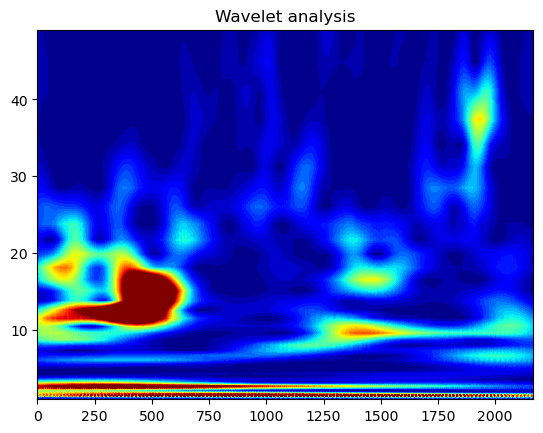

In [206]:
coeffs, freqs = get_spectrum(preprocessed[:,channel])
fig, ax = plt.subplots()
plot_spectrum(coeffs, freqs, [0,50], 0, ax)
plt.title('Wavelet analysis')

In [21]:
def plot_spectrum(coeffs, freq, band, normalization, ax):

    if normalization:
        wavelet_spectrum = np.abs(coeffs) ** 2
        mean = wavelet_spectrum.mean(axis=1,keepdims=True)
        std = wavelet_spectrum.std(axis=1,keepdims=True)
        zscored = (wavelet_spectrum-mean)/std
    else:
        zscored = np.abs(coeffs) ** 2

    cmin, cmax = np.percentile(zscored.ravel(),[2.5,97.5])
    norm = mcolors.Normalize(vmin=cmin, vmax=cmax, clip=True)
    
    c = ax.contourf(
        np.arange(zscored.shape[1]),
        freq[(freq>band[0]) & (freq<band[1])],
        zscored[(freq>band[0]) & (freq<band[1]),:],
        levels = 100,
        norm = norm,
        cmap='jet'
        # vmin=0, vmax=0.1,  # ✅ consistent color scale
        # levels = np.linspace(0, 0.11, 100)
    )

    ax.set_xlim(0,coeffs.shape[1])

In [49]:
def plot_theta(raw, band_sig, power, phase, ax):

    ax.plot(raw, label='raw', color='gray')
    ax.plot(band_sig, label='signal', color='k')
    # ax.plot(power, label='envelop')
    # ax.plot(phase*0.01+band_sig.min()-0.1,label='phase')
    ax.legend()
    ax.set_xlim(0,len(band_sig))

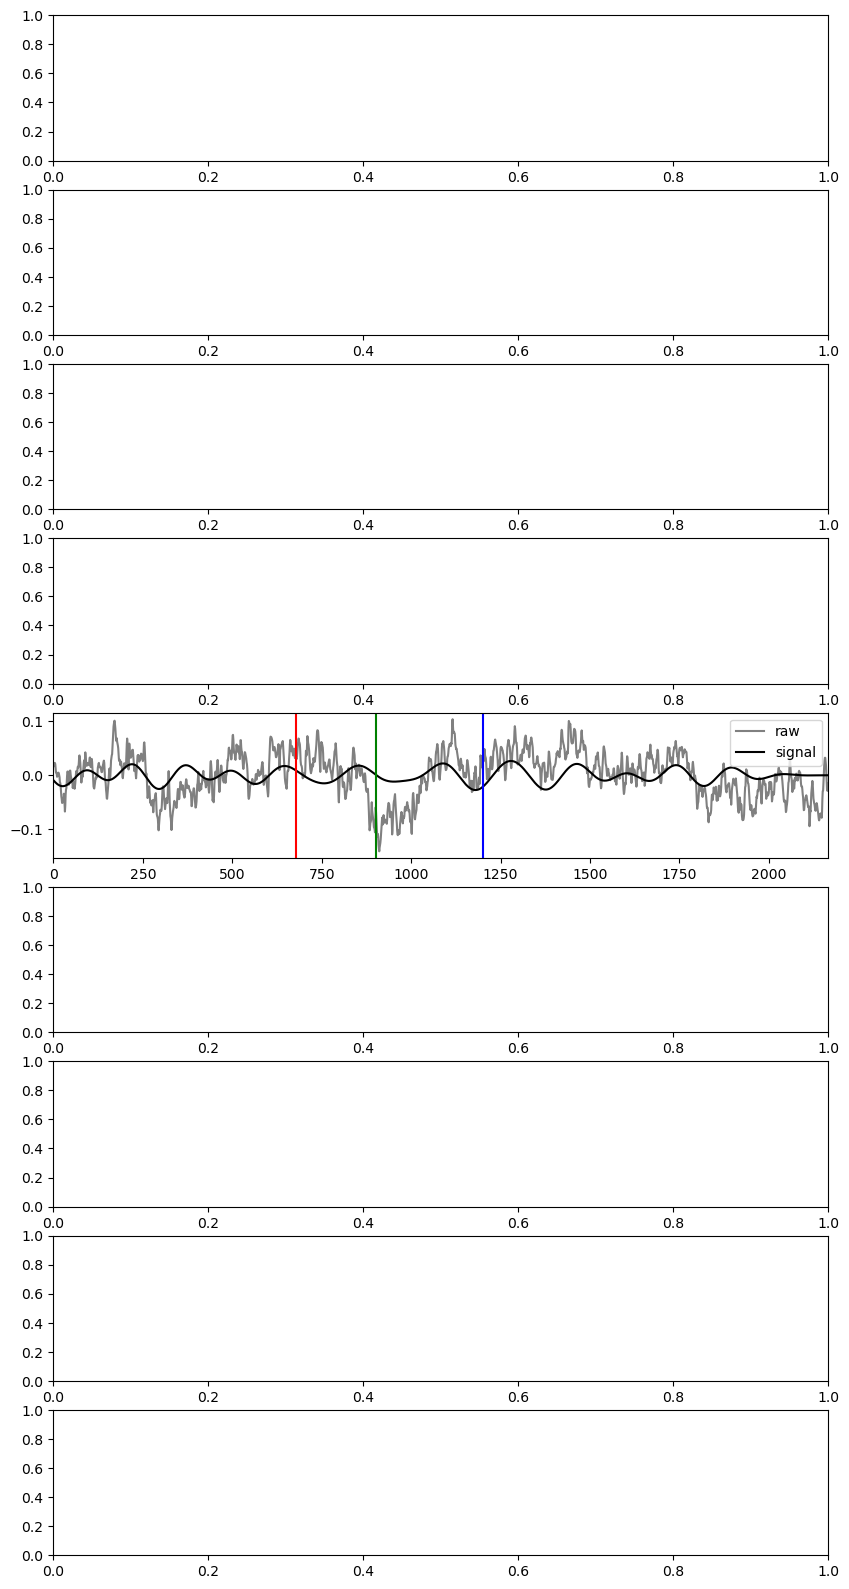

In [50]:
if region=='HPC':
    channels = HPC_channels
    unit_idx = HPC_unit_idx
if region=='OFC':
    channels = OFC_channels
    unit_idx = OFC_unit_idx

trial=0

plt.close('all')
fig, axes = plt.subplots(9,1,figsize=(10,20))


plot_theta(raw_LFP[:,channel], theta_band[:,channel], theta_power[:,channel], theta_phase[:,channel], axes[4])
plot_beh_event(trial, axes[4], color=[])

In [24]:
def detect_ripple(zscored, fs=1000):
    
    gauss_kernel = signal.windows.gaussian(101,20) # gaussian smoothing s.d. 12.5ms
    gauss_kernel /= gauss_kernel.sum()  # normalize
    smoothed = signal.convolve(zscored.ravel(),gauss_kernel,mode='same')
    
    candidate_peaks,_ = signal.find_peaks(smoothed,height=3,distance=50)


    # 4. only keep peaks with >50ms width above 3sd
    true_peaks = []
    ons = []
    offs = []

    for _peak in candidate_peaks:

        if (_peak-50>0) & (_peak+50<len(zscored)):

            try:
                on = np.max(np.where(zscored[_peak-50:_peak]<3)[0]) + _peak - 50
                off = np.min(np.where(zscored[_peak:_peak+50]<3)[0]) + _peak
                    
                if off-on>20:
                    
                    true_peaks.append(_peak)
                    ons.append(on)
                    offs.append(off)
            except:
                pass

    true_peaks = np.array(true_peaks)
    ons = np.array(ons)
    offs = np.array(offs)

    return true_peaks, ons, offs

In [25]:
def plot_SWR(rippleband, smoothed, true_peaks, ons, offs, ax):
    
    ax.plot(rippleband*50-3,color='grey')

    ax.plot(smoothed,color='r',alpha=0.5)
    ax.axhline(3,color='k',lw=0.5)
    
    for ii in range(len(true_peaks)):
        ax.axvspan(ons[ii],offs[ii],color='m',alpha=0.1)

    ax.set_xlim(0,len(rippleband))

In [26]:
def freq_band(preprocessed, band, fs=1000):

    # 1. bandpass, ripple band 150-250 (rat), NHP band 80-180
    
    sos = butter(5, band, btype='bandpass', output='sos', fs=fs)
    band_sig = sosfiltfilt(sos, preprocessed,axis=0)

    # 2. calculate the power and phase of this frequency band

    hilb_sig = hilbert(band_sig, axis=0)
    power = np.abs(hilb_sig)
    phase = np.angle(hilb_sig)


    return band_sig, power, phase

KeyboardInterrupt: 

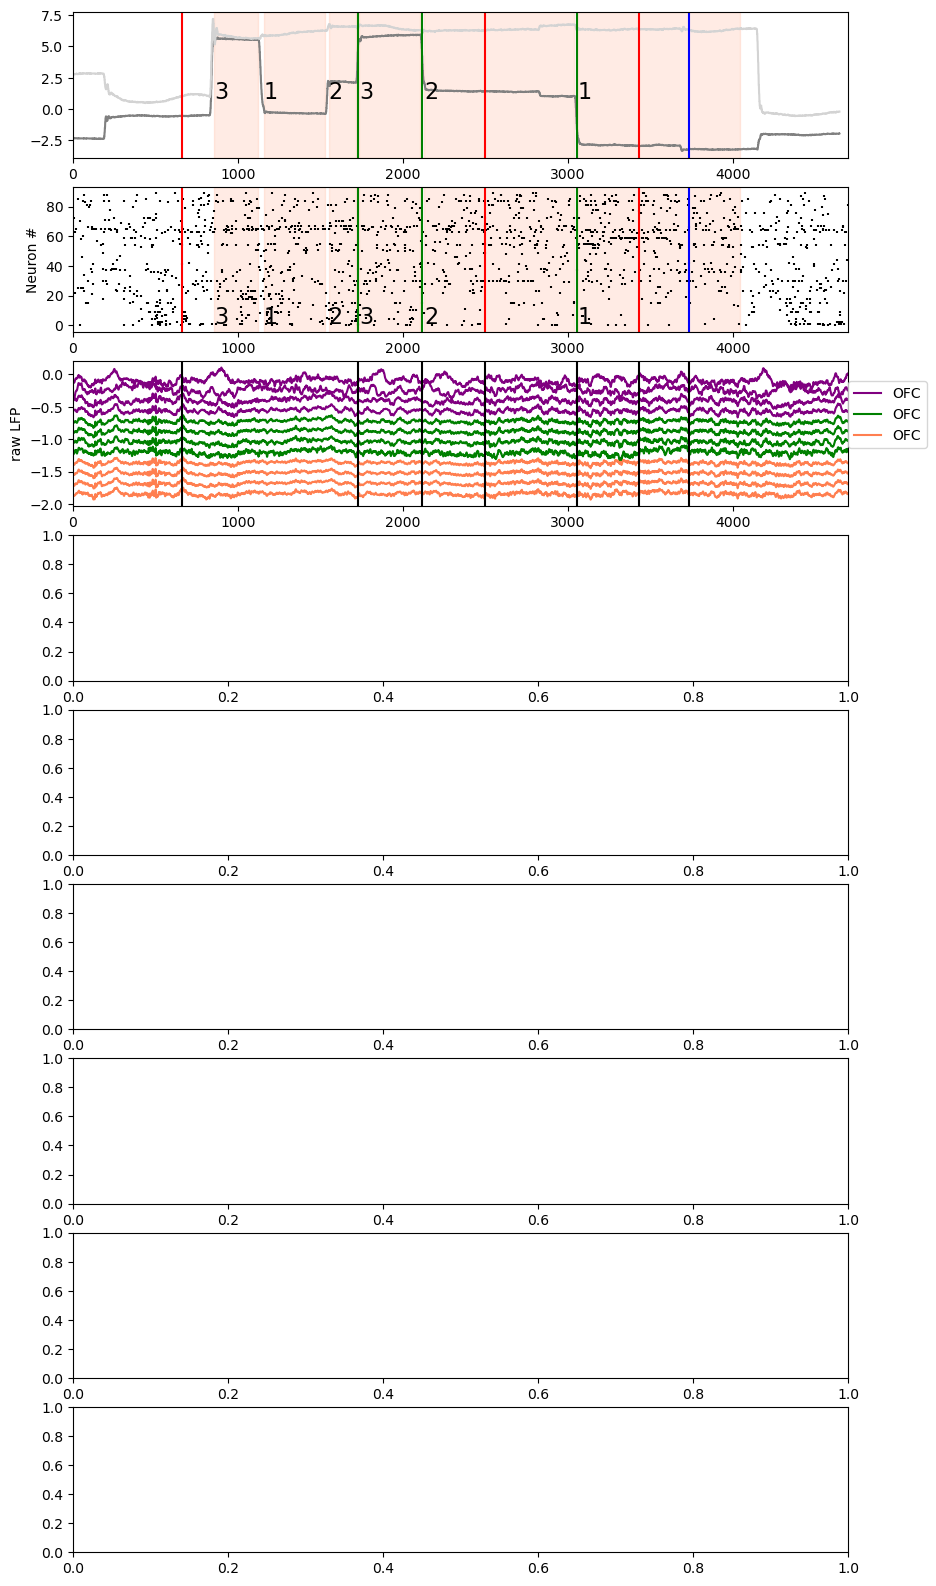

In [115]:
for trial in trial_df.trial.values:
    plot_a_trial(date, trial, region='OFC')

In [79]:
channels = HPC_channels
unit_idx = HPC_unit_idx

In [129]:
preprocessed = preprocess_LFP(raw_LFP[:,channels])
theta_band, theta_power, theta_phase = freq_band(preprocessed, [10,20])
channel = np.argmax(theta_power.mean(axis=0))

Text(0.5, 1.0, 'Session 031723, HPC, channel 127')

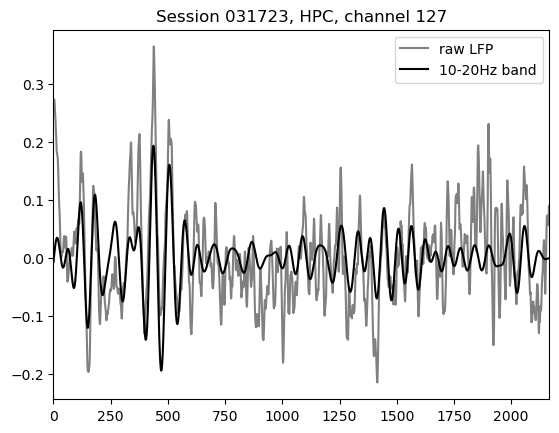

In [202]:
fig, ax = plt.subplots()
plot_theta(raw_LFP[:,96:][:,channel],theta_band[:,channel], theta_power[:,channel], theta_phase[:,channel], ax)
plt.legend(['raw LFP','10-20Hz band'])
plt.title('Session %s, HPC, channel %i' % (date,channels[channel]))

(0.0, 30.0)

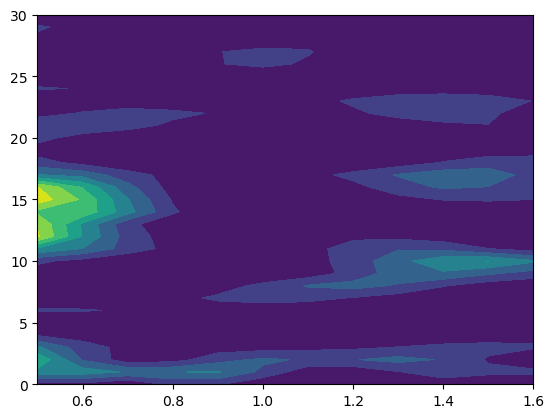

In [201]:
fs=1000
f, t, Sxx = signal.spectrogram(
    preprocessed[:,channel], 
    fs=fs, 
    window='hann',
    nperseg=int(fs),
    noverlap=int(fs*0.9),
    detrend='linear',
    scaling='density',
    mode='psd'
)

plt.close('all')
plt.contourf(
        t,
        f,
        Sxx
        # levels = 100,
        # norm = norm,
        # cmap='jet'
        # vmin=0, vmax=0.1,  # ✅ consistent color scale
        # levels = np.linspace(0, 0.11, 100)
    )
plt.ylim(0,30)

In [133]:
from scipy.signal import ShortTimeFFT

In [198]:
window = signal.windows.tukey(int(fs*2))

# g_std = fs*250  # standard deviation for Gaussian window in samples
# window = signal.windows.gaussian(fs, std=g_std, sym=True)  # symmetric Gaussian window

SFT = ShortTimeFFT(window, hop=10, fs=fs, scale_to='psd', fft_mode='onesided')
Sx = SFT.stft(preprocessed[:,channel])  # perform the STFT

(0.0, 50.0)

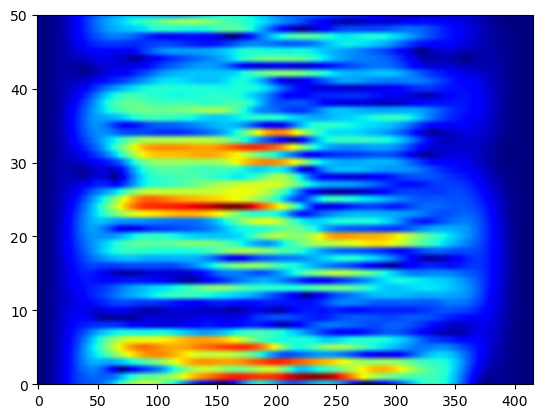

In [199]:
plt.close('all')
plt.imshow(abs(Sx), origin='lower', aspect='auto',
                 cmap='jet')
plt.ylim(0,50)

In [ ]:
def fft_spectrum(preprocessed_LFP, timestamps, fs = 1000):

    for ii in timestamps:
        
        chunk = preprocessed_LFP[ii-500:ii+500]
        # sampling rate
        f, t, Sxx = signal.spectrogram(
            chunk, 
            fs=fs, 
            window='hann',
            nperseg=fs,
            noverlap=fs*0.9,
            detrend=False,
            scaling='density',
            mode='psd'
        )

Text(0.5, 1.0, 'Wavelet analysis')

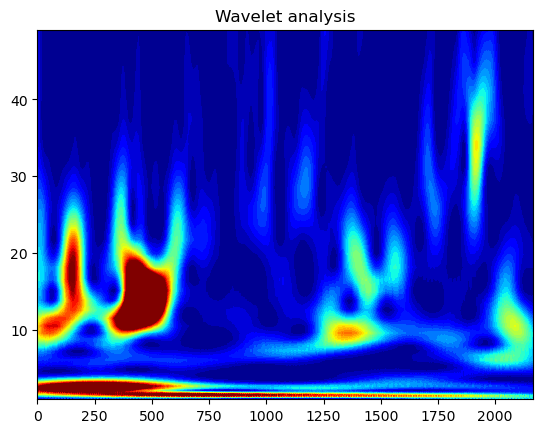

In [131]:
coeffs, freqs = get_spectrum(preprocessed[:,channel])
fig, ax = plt.subplots()
plot_spectrum(coeffs, freqs, [0,50], 0, ax)
plt.title('Wavelet analysis')

In [208]:
data = np.load('D:/SWR/Session %s, Band 80 180 ripples.npy' % date, allow_pickle=True)    
# all_peaks, _ = data['peaks'], data['durs']

In [238]:
all_peaks = data.item()['peaks']
all_ons = data.item()['ons']
all_offs = data.item()['offs']

In [244]:
ripple = all_peaks[probe-3][ch]
trial_ripple = ripple[(ripple>trial_on) & (ripple<trial_on+trial_end)]
trial_ripple

array([], dtype=int64)

In [271]:
SWR_band.shape

(2167, 96)

In [270]:
trial = 0
this_trial = trial_df[trial_df.trial==trial]
trial_on = this_trial.start_time.values[0]
trial_end = this_trial.stop_time.values[0]-trial_on

timestamps = np.arange(trial_on, trial_on+trial_end)

preprocessed = preprocess_LFP(raw_LFP[:,channels])
SWR_band, SWR_power, SWR_phase = freq_band(preprocessed, [80,180])

In [ ]:
channel = 131

plt.close('all')
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(np.arange(0,trial_end),raw_LFP[:,channel],'gray')
plt.plot(np.arange(0,trial_end),SWR_band[:, channel]*5-0.2,'k-')
# plt.plot(np.arange(-1000,1000),smoothed[timestamps]*5-4,'k-')

ax2 = ax.twinx()

ax2.plot(np.arange(-1000,1000),zscored[timestamps],'r-')
plt.vlines(peaks_comb[(peaks_comb>timestamps[0]) & (peaks_comb<timestamps[-1])]-center,zscored[timestamps].min(),zscored[timestamps].max())    
plt.axvspan(ons_comb[idx]-center,offs_comb[idx]-center,color='magenta',alpha=0.1)

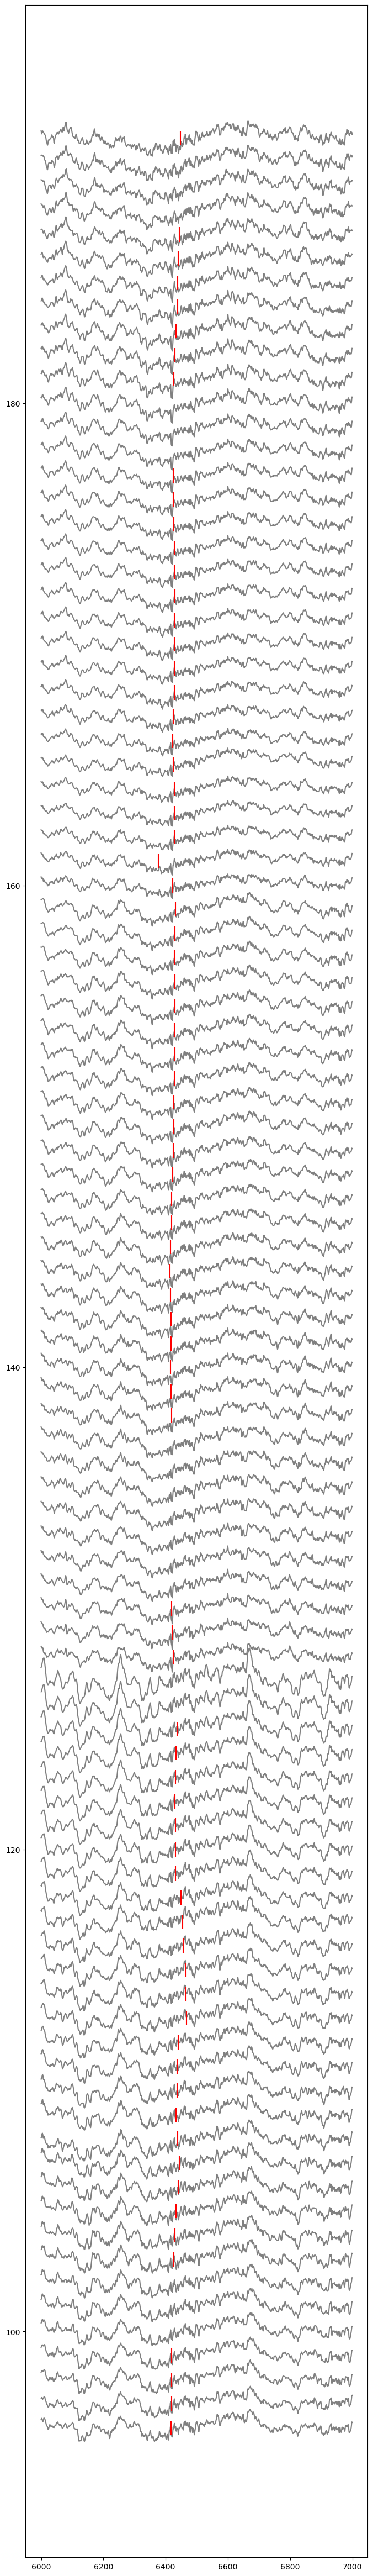

In [267]:
plt.close('all')
plt.figure(figsize=(8,60))

timestamps = np.arange(6000,7000)

for ii in channels:

    probe, ch = np.divmod(ii,32)
    ripple = all_peaks[probe-3][ch]
    trial_ripple = ripple[(ripple>timestamps[0]) & (ripple<timestamps[-1])]
    
    # trial_SWR_on = (all_ons[probe-3][ch]>trial_on) & (all_ons[probe-3][ch]<trial_on+trial_end)
    # trial_SWR_off = (all_offs[probe-3][ch]>trial_on) & (all_offs[probe-3][ch]<trial_on+trial_end)
    
    plt.plot(timestamps,lfpData[timestamps,ii]*5+ii,color='gray')
    if len(trial_ripple)>0:
        plt.vlines(trial_ripple,ii-0.3,ii+0.3,color='r')

In [251]:
ripple_raster = np.zeros((lfpData.shape[0],len(channels)))

In [254]:
for ii in channels:

    probe, ch = np.divmod(ii,32)
    ripple_raster[all_peaks[probe-3][ch]]=1

(0.0, 100000.0)

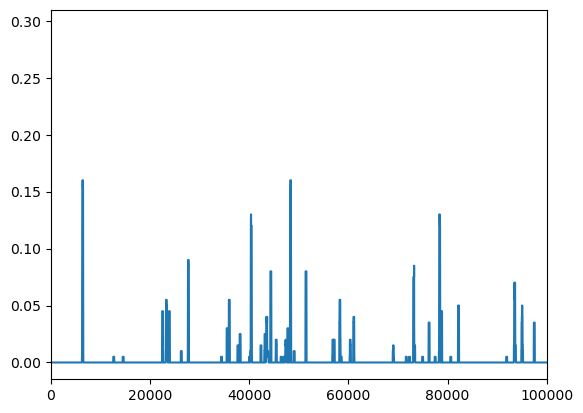

In [262]:
plt.close('all')
plt.plot(np.convolve(ripple_raster.mean(axis=1),np.ones(200)/200,mode='same'))
plt.xlim(0,100000)

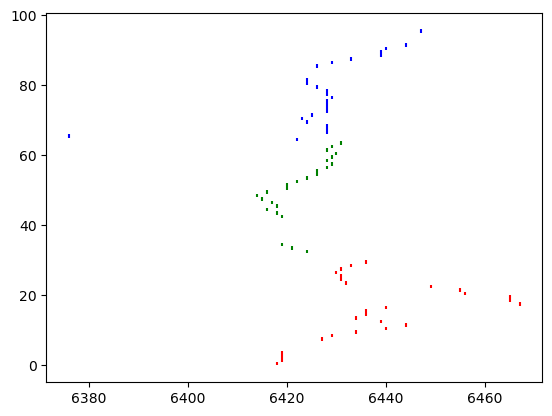

In [264]:
plt.close('all')

tt = 10000

for ii in range(32):
    ripples = all_peaks[0][ii]
    plt.vlines(ripples[ripples<tt],ii,ii+1,color='r')

for ii in range(32):
    ripples = all_peaks[1][ii]
    plt.vlines(ripples[ripples<tt],ii+32,ii+33,color='g')

for ii in range(32):
    ripples = all_peaks[2][ii]
    plt.vlines(ripples[ripples<tt],ii+64,ii+65,color='b')

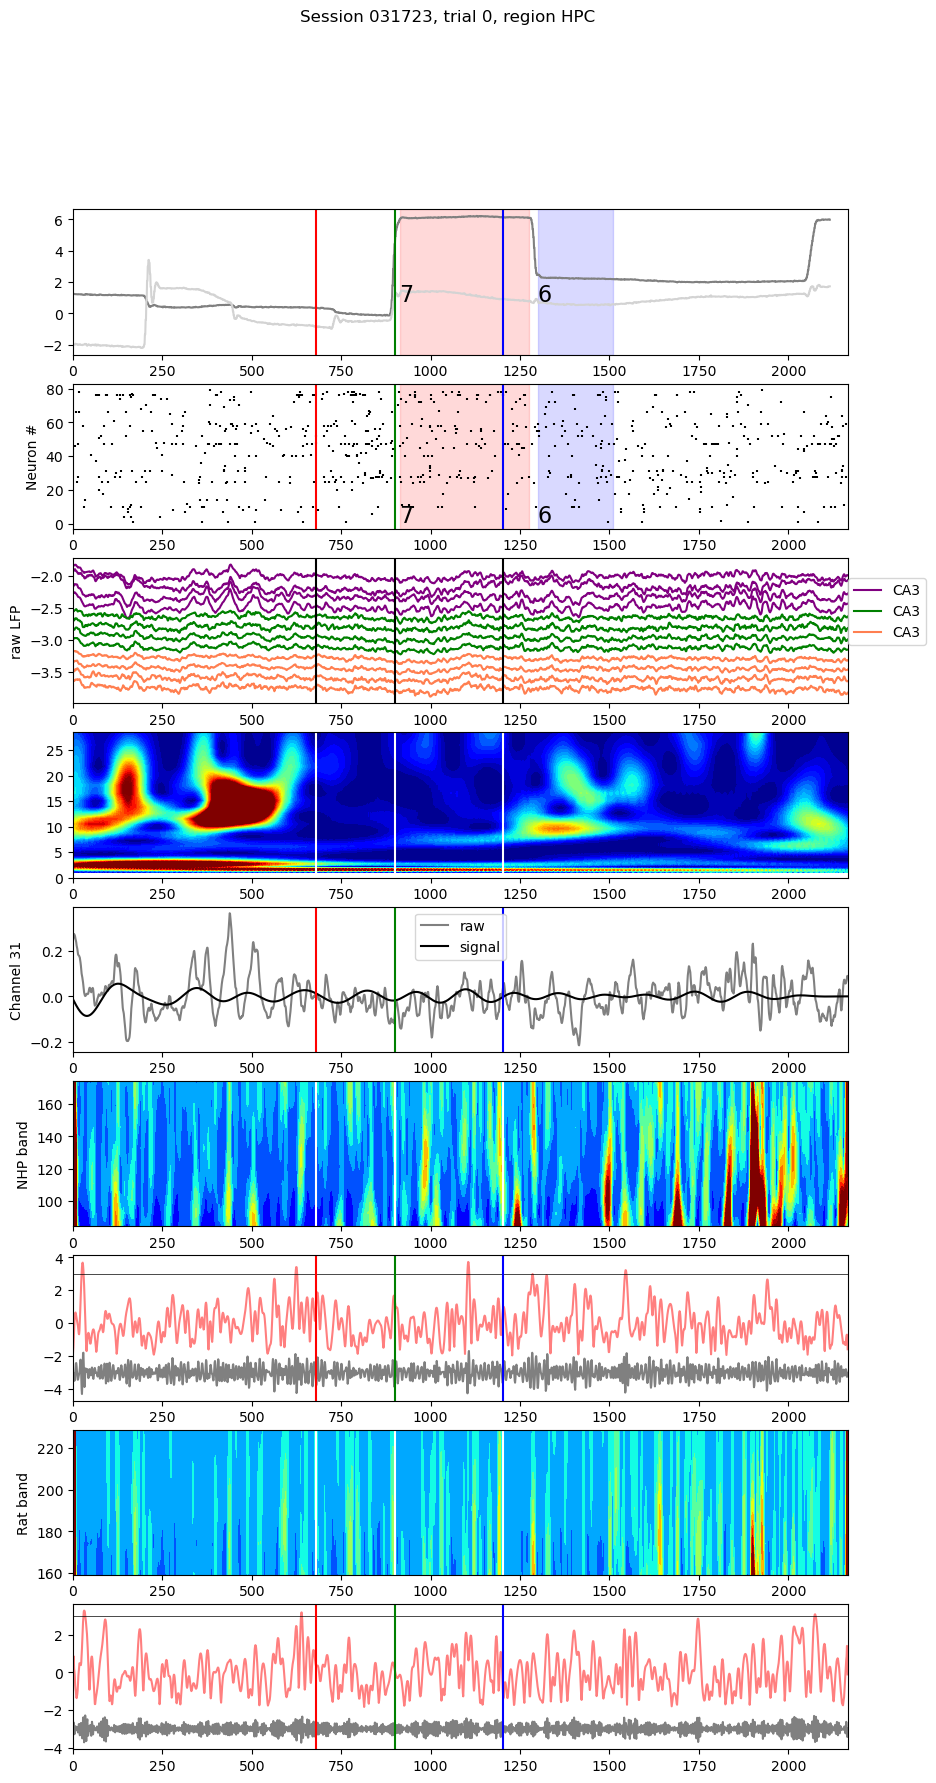

In [68]:
plot_a_trial(date, 0, region='HPC')

In [67]:
def plot_a_trial(date, trial, region = 'HPC'):

    if region=='HPC':
        channels = HPC_channels
        unit_idx = HPC_unit_idx
    if region=='OFC':
        channels = OFC_channels
        unit_idx = OFC_unit_idx
    
    plt.close('all')
    fig, axes = plt.subplots(9,1,figsize=(10,20))

    plot_eye_trace(trial, axes[0])
    plot_beh_event(trial, axes[0], color=[])
    plot_fixation_nodes(trial, axes[0])
    
    plot_beh_event(trial, axes[1], color=[])
    plot_fixation_nodes(trial, axes[1])
    plot_spike_raster(trial, unit_idx, axes[1])

    raw_LFP = get_raw_LFP(trial)
    plot_raw_LFP(raw_LFP, axes[2], channels)
    plot_beh_event(trial, axes[2], color='k')
    axes[2].set_ylabel('raw LFP')
    
    # theta band filter all channels, find the one with highest theta power
    preprocessed = preprocess_LFP(raw_LFP[:,channels])
    theta_band, theta_power, theta_phase = freq_band(preprocessed, [4,8])
    channel = np.argmax(theta_power.mean(axis=0))
    
    coeffs, freqs = get_spectrum(preprocessed[:,channel])
    plot_spectrum(coeffs, freqs, [0,30], 0, axes[3])
    plot_beh_event(trial, axes[3], color='w')
    axes[3].set_yticks(np.arange(0,30,5))
    
    plot_theta(raw_LFP[:,channels[channel]],theta_band[:,channel], theta_power[:,channel], theta_phase[:,channel], axes[4])
    plot_beh_event(trial, axes[4], color=[])
    axes[4].set_ylabel('Channel %i' % channel)
    
    # SWR band filter all channels, find the one with highest SWR power, NHP band
    
    SWR_band, SWR_power, SWR_phase = freq_band(preprocessed, [80,180])
    zscored = (SWR_power-SWR_power.mean(axis=0,keepdims=True))/SWR_power.std(axis=0,keepdims=True)
    raw_channel = np.argmax(SWR_power.mean(axis=0))
    # _, zscore_channel = np.unravel_index(np.argmax(zscored), SWR_power.shape)
    
    
    plot_spectrum(coeffs, freqs, [80,180], 1, axes[5])
    plot_beh_event(trial, axes[5], color='w')
    axes[5].set_ylabel('NHP band')
    
    true_peaks, ons, offs = detect_ripple(zscored[:,raw_channel])
    plot_SWR(SWR_band[:,raw_channel], zscored[:,raw_channel], true_peaks, ons, offs, axes[6])
    plot_beh_event(trial, axes[6], color=[])
    
    # true_peaks, ons, offs = detect_ripple(zscored[:,zscore_channel])
    # plot_SWR(SWR_band[:,zscore_channel], zscored[:,zscore_channel], true_peaks, ons, offs, axes[7])
    
    
    # Rat band
    SWR_band, SWR_power, SWR_phase = freq_band(preprocessed, [150,250])
    zscored = (SWR_power-SWR_power.mean(axis=0,keepdims=True))/SWR_power.std(axis=0,keepdims=True)
    raw_channel = np.argmax(SWR_power.mean(axis=0))
    # _, zscore_channel = np.unravel_index(np.argmax(zscored), SWR_power.shape)
    
    
    plot_spectrum(coeffs, freqs, [150,250], 1, axes[7])
    plot_beh_event(trial, axes[7], color='w')
    axes[7].set_ylabel('Rat band')
    
    # axes[6].set_ylabel('NHP band')
    true_peaks, ons, offs = detect_ripple(zscored[:,raw_channel])
    plot_SWR(SWR_band[:,raw_channel], zscored[:,raw_channel], true_peaks, ons, offs, axes[8])
    plot_beh_event(trial, axes[8], color=[])

    title = 'Session %s, trial %i, region %s' % (date, trial, region)
    plt.suptitle(title)
    plt.savefig('D:/Figures/Bart/'+title)

In [ ]:
# train decoder on choice fixations

for trial in trial_cand[:10]:
        
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    FR = spikes.data[:,unit_idx]
    
    # get spikes between trial onset to 1st action onset 
    w=100
    eye_idx = 2
    neural_idx = 0
    
    # pull trial for a single trial
    # plot eye trace in 4*4 grid
    eyes = trial_df[trial_df.trial==trial].timeseries.iloc[0][eye_idx]
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    trial_on = trial_df[trial_df.trial==trial].start_time.values[0]
    
    fixations_during_trial = fix_df.query("trial == @ trial")
    
    node_df = nwbfile.intervals["node_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    node_on = node_df.t_on.values[0]-trial_on
    action_df = nwbfile.intervals["action_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    action_on = action_df.t_on.values[0]-trial_on
        
    color_seq = sns.color_palette('Set1',len(fixations_during_trial))
    
    plt.close('all')
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(nrows=4, ncols=3)
    ax=fig.add_subplot(gs[0,2])
    ax.plot(eyes.data[:, 0], eyes.data[:, 1], alpha=0.5, c="k", lw=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
        
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        if fix.planning:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=2)
        if fix.choice:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=4)
    
        ii=ii+1
    
    
    ax.set_ylim([-12, 12])
    ax.set_xlim([-12, 12])
    ax.set_title("Fixations during trial %i" % trial)
    
    # sns.despine(bottom=False,left=False)
    
    # plot eyetracking data separately for x, y, for alignment with neural data visualization
    ax = fig.add_subplot(gs[0,:2])
    ax.plot(eyes.timestamps-trial_on, eyes.data)
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
            
        if fix.planning:
            ax.plot(eyes.timestamps[idx]-trial_on,fixation_trace, c='k', ls='-',lw=2)
            
        ii=ii+1
    
    ax.set_ylabel("Eyes (DV)")
    ax.set_ylim([-12, 12])
    
    
    # plot spike raster
    FR = spikes.data[:, unit_idx]
    ax = fig.add_subplot(gs[1,:2])
    X, Y = np.where(FR)
    X = (X + spikes.timestamps[0]-trial_on)
    ax.scatter(X, Y, marker = "|", c="k", s=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
       
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1,label=f"Node {fix.fix_node}")
    
        ii=ii+1
    
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Neuron #")
    # ax.set_xlabel("Time in session (ms)")
    ax.legend(loc=(1.1,0.3))
    sns.despine()
    
    
    # plot predicted probability for node of interest only
    
    timestamps = np.arange(150,FR.shape[0]-150+50,50)
    w=150
        
    pred_val = np.zeros(len(timestamps))
    
    for ii,t in enumerate(timestamps): 
    
        pred_val[ii] = lasso_cv.predict(FR[t-w:t+w,:].mean(axis=0, keepdims=True))[0]
    
    
    colors16 = [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728",
        "#9467bd","#8c564b","#e377c2","#7f7f7f",
        "#bcbd22","#17becf","#a55194","#393b79",
        "#637939","#8c6d31","#843c39","#cedb9c"
    ]
    
    
    ax = fig.add_subplot(gs[2,:2])   
    ax.plot(timestamps,pred_val)  
    ax.set_ylim(1,1.5)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
    
        ii=ii+1
    
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Value estimates")
    # ax.set_ylim(0,0.15)
    # ax.set_xlabel("Time in session (ms)")
    # ax.legend(ncols=2,loc=(1.1,0.5))
    sns.despine()

    
    plt.suptitle('Value estimate Target %i, Flash %i' % (trial_df[trial_df.trial==trial].target.values[0],
                  trial_df[trial_df.trial==trial].blocktrialnumber.values[0]),fontsize=20)
    plt.savefig('Flash trial value estimates trial %i, target, session %s, OFC' % (trial, date))


In [25]:
def plot_eye_trace_2d(trial, ax, eye_idx=2):
    
    trial_of_interest = trial_df[trial_df.trial==trial] 
    fixations_during_trial = fix_df[fix_df.trial==trial] 
    
    eyes = trial_of_interest.timeseries.iloc[0][eye_idx]   

    # this is to plot x,y 2d plane
    for _, fix in fixations_during_trial.iterrows():
        
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        if fix.planning:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=2)
        if fix.choice:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=4)
    

In [2]:
def get_spike_table(nwbfile, region, epoch, unitNumber=[], query="", window_size=0, unit_params = {"drift": 2, "min_fr": 1}):
    """_summary_

    Returns:
        (np.array, pd.DataFrame) : spike table aligned to the specified epoch, dataframe with step metadata
        
    """
    assert epoch in nwbfile.intervals.keys(), f"Epoch {epoch} not found in nwbfile intervals. Available epochs: {nwbfile.intervals.keys()}"
    
    assert region in ["HPC", "OFC"], f"Region {region} not found. Available regions: ['HPC', 'OFC']"

    
    unitNames = nwbfile.units.to_dataframe()
    
    if len(unitNumber)==0:
        # get all good units
        unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    else:
        # get a specific unit
        unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) 
                            & (unitNames.fr >= unit_params["min_fr"]) & (unitNames.unitNumber==unitNumber))[0]
        
    unitNames = unitNames.iloc[unit_idx, :].reset_index(drop=True)

    
    # subsample an epoch with a specific query
    if query == "":
        df = nwbfile.intervals[epoch].to_dataframe()#["timeseries"]
    else:
        df = nwbfile.intervals[epoch].to_dataframe().query(query)#["timeseries"]

    neural_timeseries_index = 0
    sample_index = df.index
    
    if epoch!='fixations':
        
        epoch_win_size = df["window_size"].values[0]
        spikes = np.zeros((len(sample_index), epoch_win_size*2, len(unit_idx)), dtype=np.float32)
        print("Building Spike Table")
        if window_size != 0:
            for i, _sample in tqdm(enumerate(sample_index)):
                sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
                sample_data = movmean(sample_data.T, window_size).T
                spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
        else:
            for i, _sample in tqdm(enumerate(sample_index)):
                sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
                spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
    

    if epoch=='fixations':
        
        spikes = np.zeros((len(df), len(unit_idx)), dtype=np.float32)
        
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            spikes[i,:] = sample_data.mean(axis=0)
        
        df['planning'] = (df.duration<300) & (df.active_prob<0.2)
        df['choice'] = (df.duration>300) & (df.active_prob>0.2)
    
    df = graph.append_use_tele(df)
    df = df.drop(columns=["timeseries"])
    
    return spikes, df, unitNames

In [3]:
def combine_data(region,epoch,query,animal):
    
    # combine all sessions
    if animal=='London':
        DATA_DIR = Path('D:/Teleworld/london/neural')
    if animal=='Bart':
        DATA_DIR = Path('D:/')
    
    os.chdir(DATA_DIR)
    filenames = glob.glob('*.nwb') # sorted()
        
    df = pd.DataFrame()
    spikes = [[] for i in range(len(filenames))]
    neuron_df = pd.DataFrame()
    
    for ii, filename in enumerate(filenames):

        print(filename)
        if animal=='London':
            date = filename[-17:-11] 
        if animal=='Bart':
            date = filename[-10:-4]
        
        nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
        temp_spikes, temp_df, unitNames = get_spike_table(nwbfile, region, epoch, query = query, window_size = 0)
        
        temp_df.insert(0,'Session',date)
        df = pd.concat([df,temp_df]).reset_index(drop=True)
        spikes[ii] = temp_spikes
    
        unitNames.insert(0,'Session',date)
        neuron_df = pd.concat([neuron_df,unitNames]).reset_index(drop=True)

    if epoch=='action_on':
        df['prenode'] = np.insert(df.node.values[:-1], 0, -1)
        df['postnode'] = np.insert(df.node.values[1:], -1, -1)
        df.loc[df.step==0,'prenode'] = -1
        df.loc[df.step==df.nsteps,'postnode'] = -1

    if epoch=='fixations':
        df['node']=df['fix_node']
        df['distance'] = df.apply(lambda row: graph.distance(row['fix_node'], row['target']), axis=1)    
        
    return df, spikes, neuron_df

In [50]:
choice_df.Session.unique()

array(['101124', '100324', '092124', '092324', '092524', '100124',
       '100924'], dtype=object)

In [4]:
def plot_psth2(ax,var,df,spikes): 

    for node in np.arange(0, 16):
        
        idx = df[var].values == node
        x, y = xy(node, 4, 4)
        trace = movmean(np.mean(spikes[idx,:,int(nid)],axis=0)*1000, w=75).flatten()
        t = np.arange(-500, 500)
        ax.plot(t,trace,c= cmap_2d[x, y])
        ax.axvline(0,color='k',linestyle='--',lw=0.8)
        ax.set_title(var)

In [5]:
sz1 = 12
sz2 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [6]:
DATA_DIR = Path('D:/Teleworld/london/neural')
os.chdir(DATA_DIR)

In [29]:
# decode target identity
for region in ['HPC','OFC']:
    
    choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,region,"node_on","(trialerror == 1)")
    choice_df['istarget'] = choice_df['target']==choice_df['node']
    chosen_accuracy_all = decode_target(choice_df, choice_spikes, LinearDiscriminantAnalysis(),rep=20)  #  # SVC(probability=True)
    print('~~~~~~~~~~target identity decoding accuracy %s Flash trials' % region)
    np.save('target identity decoding accuracy %s Flash trials' % region, chosen_accuracy_all, allow_pickle=True)

    for te in [1,2]:
        choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,region,"node_on","(blocktrialnumber == @te)")
        choice_df['istarget'] = choice_df['target']==choice_df['node']
        chosen_accuracy_all = decode_target(choice_df, choice_spikes, LinearDiscriminantAnalysis(),rep=20)  #  # SVC(probability=True)
        print('~~~~~~~~~~~target identity decoding accuracy %s Flash %i' % (region,te))
        np.save('target identity decoding accuracy %s Flash %i' % (region,te), chosen_accuracy_all, allow_pickle=True)

London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


190it [00:00, 2094.74it/s]

London_TeleWorld_4x4_100324_spikes.nwb


Building Spike Table


180it [00:00, 1997.88it/s]

London_TeleWorld_4x4_092124_spikes.nwb


Building Spike Table


180it [00:00, 1333.46it/s]

London_TeleWorld_4x4_092324_spikes.nwb


Building Spike Table


180it [00:00, 475.08it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


179it [00:00, 364.62it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


182it [00:00, 401.72it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


182it [00:00, 461.66it/s]


0 101124


100%|██████████| 20/20 [01:59<00:00,  5.97s/it]


1 100324


100%|██████████| 20/20 [02:28<00:00,  7.41s/it]


2 092124


100%|██████████| 20/20 [05:41<00:00, 17.05s/it]


3 092324


100%|██████████| 20/20 [02:59<00:00,  8.97s/it]


4 092524


100%|██████████| 20/20 [04:18<00:00, 12.91s/it]


5 100124


100%|██████████| 20/20 [07:00<00:00, 21.03s/it]


6 100924


100%|██████████| 20/20 [07:17<00:00, 21.88s/it]


~~~~~~~~~~target identity decoding accuracy HPC Flash trials
London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


94it [00:00, 416.75it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


90it [00:00, 475.20it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


89it [00:00, 383.58it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


90it [00:00, 451.68it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


90it [00:00, 381.84it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


91it [00:00, 374.22it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


90it [00:00, 412.42it/s]


0 101124


100%|██████████| 20/20 [02:01<00:00,  6.07s/it]


1 100324


100%|██████████| 20/20 [02:27<00:00,  7.37s/it]


2 092124


100%|██████████| 20/20 [05:59<00:00, 18.00s/it]


3 092324


100%|██████████| 20/20 [03:01<00:00,  9.09s/it]


4 092524


100%|██████████| 20/20 [04:19<00:00, 12.96s/it]


5 100124


100%|██████████| 20/20 [06:38<00:00, 19.91s/it]


6 100924


100%|██████████| 20/20 [05:45<00:00, 17.29s/it]


~~~~~~~~~~~target identity decoding accuracy HPC Flash 1
London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


95it [00:00, 376.85it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


90it [00:00, 719.64it/s]

London_TeleWorld_4x4_092124_spikes.nwb


Building Spike Table


90it [00:00, 434.35it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


90it [00:00, 594.41it/s]

London_TeleWorld_4x4_092524_spikes.nwb


Building Spike Table


89it [00:00, 468.77it/s]

London_TeleWorld_4x4_100124_spikes.nwb


Building Spike Table


91it [00:00, 375.32it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


90it [00:00, 612.72it/s]

0 101124



100%|██████████| 20/20 [02:00<00:00,  6.05s/it]


1 100324


100%|██████████| 20/20 [02:27<00:00,  7.39s/it]


2 092124


100%|██████████| 20/20 [05:42<00:00, 17.11s/it]


3 092324


100%|██████████| 20/20 [03:01<00:00,  9.06s/it]


4 092524


100%|██████████| 20/20 [04:18<00:00, 12.95s/it]


5 100124


100%|██████████| 20/20 [06:35<00:00, 19.80s/it]


6 100924


100%|██████████| 20/20 [05:46<00:00, 17.33s/it]


~~~~~~~~~~~target identity decoding accuracy HPC Flash 2
London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


190it [00:00, 467.96it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


180it [00:00, 517.76it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


180it [00:00, 395.31it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


180it [00:00, 416.53it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


179it [00:00, 366.12it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


182it [00:00, 516.62it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


182it [00:00, 501.70it/s]


0 101124


100%|██████████| 20/20 [06:29<00:00, 19.48s/it]


1 100324


100%|██████████| 20/20 [04:51<00:00, 14.55s/it]


2 092124


100%|██████████| 20/20 [04:31<00:00, 13.57s/it]


3 092324


100%|██████████| 20/20 [05:47<00:00, 17.38s/it]


4 092524


100%|██████████| 20/20 [04:45<00:00, 14.26s/it]


5 100124


100%|██████████| 20/20 [03:52<00:00, 11.64s/it]


6 100924


100%|██████████| 20/20 [04:13<00:00, 12.65s/it]


~~~~~~~~~~target identity decoding accuracy OFC Flash trials
London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


94it [00:00, 360.99it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


90it [00:00, 393.65it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


89it [00:00, 346.71it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


90it [00:00, 344.83it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


90it [00:00, 315.48it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


91it [00:00, 404.34it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


90it [00:00, 468.27it/s]


0 101124


100%|██████████| 20/20 [06:35<00:00, 19.79s/it]


1 100324


100%|██████████| 20/20 [04:50<00:00, 14.54s/it]


2 092124


100%|██████████| 20/20 [04:29<00:00, 13.49s/it]


3 092324


100%|██████████| 20/20 [05:51<00:00, 17.59s/it]


4 092524


100%|██████████| 20/20 [04:47<00:00, 14.38s/it]


5 100124


100%|██████████| 20/20 [03:53<00:00, 11.68s/it]


6 100924


100%|██████████| 20/20 [04:16<00:00, 12.81s/it]


~~~~~~~~~~~target identity decoding accuracy OFC Flash 1
London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


95it [00:00, 351.39it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


90it [00:00, 391.61it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


90it [00:00, 486.08it/s]

London_TeleWorld_4x4_092324_spikes.nwb


Building Spike Table


90it [00:00, 471.20it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


89it [00:00, 369.90it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


91it [00:00, 521.92it/s]

London_TeleWorld_4x4_100924_spikes.nwb


Building Spike Table


90it [00:00, 605.38it/s]

0 101124



100%|██████████| 20/20 [06:48<00:00, 20.41s/it]


1 100324


100%|██████████| 20/20 [04:55<00:00, 14.80s/it]


2 092124


100%|██████████| 20/20 [04:30<00:00, 13.53s/it]


3 092324


100%|██████████| 20/20 [05:50<00:00, 17.54s/it]


4 092524


100%|██████████| 20/20 [04:47<00:00, 14.37s/it]


5 100124


100%|██████████| 20/20 [03:51<00:00, 11.59s/it]


6 100924


100%|██████████| 20/20 [04:14<00:00, 12.71s/it]


~~~~~~~~~~~target identity decoding accuracy OFC Flash 2


In [638]:
choice_df, choice_spikes, neuron_df = combine_data('HPC','action_on',"(trialerror == 0)",'London')

London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


2545it [00:02, 978.71it/s] 


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


2417it [00:02, 952.94it/s] 


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


2401it [00:02, 856.47it/s] 


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


2450it [00:02, 990.16it/s] 


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


2427it [00:02, 868.19it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


2432it [00:03, 684.10it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


2434it [00:02, 996.52it/s] 


In [639]:
choice_df, choice_spikes, neuron_df = combine_data('HPC','action_on',"(trialerror == 0)",'London')
flash_df, flash_spikes, neuron_df = combine_data('HPC','action_on',"(trialerror == 1)",'London')

London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


190it [00:00, 1872.84it/s]

London_TeleWorld_4x4_100324_spikes.nwb


Building Spike Table


180it [00:00, 1858.44it/s]

London_TeleWorld_4x4_092124_spikes.nwb


Building Spike Table


180it [00:00, 1311.76it/s]

London_TeleWorld_4x4_092324_spikes.nwb


Building Spike Table


180it [00:00, 1748.59it/s]

London_TeleWorld_4x4_092524_spikes.nwb


Building Spike Table


179it [00:00, 1259.17it/s]

London_TeleWorld_4x4_100124_spikes.nwb


Building Spike Table


182it [00:00, 1174.17it/s]

London_TeleWorld_4x4_100924_spikes.nwb


Building Spike Table


182it [00:00, 1468.79it/s]


In [125]:
rsquare_all2 = predict_value()

0 101124


100%|██████████| 2/2 [00:19<00:00,  9.88s/it]


1 100324


100%|██████████| 2/2 [00:16<00:00,  8.21s/it]


2 092124


100%|██████████| 2/2 [00:15<00:00,  7.97s/it]


3 092324


100%|██████████| 2/2 [00:18<00:00,  9.48s/it]


4 092524


100%|██████████| 2/2 [00:16<00:00,  8.35s/it]


5 100124


100%|██████████| 2/2 [00:14<00:00,  7.26s/it]


6 100924


100%|██████████| 2/2 [00:14<00:00,  7.16s/it]


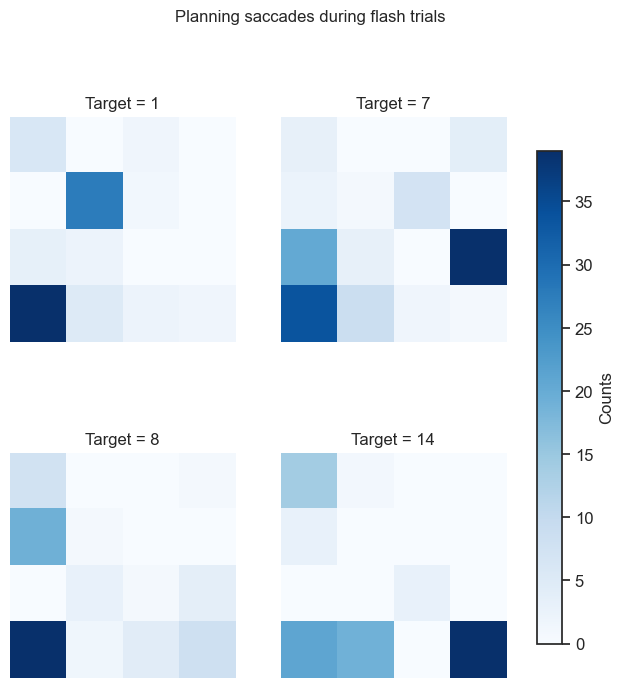

In [536]:
planning = flash_fix_df[flash_fix_df['target']!=flash_fix_df['fix_node']].query('duration>50')

plt.close('all')

targets = [1, 7, 8, 14]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, t in zip(axes.flat, targets):
    # Compute normalized counts (proportions) for fix_node 0–15
    counts = (
        planning.query(f'target == {t}')['fix_node']
        .value_counts()
        .reindex(range(16), fill_value=0)
        .values
        .reshape(4, 4)
    )
    
    im = ax.imshow(counts, cmap='Blues', vmin=0, vmax=counts.max())
    ax.set_title(f"Target = {t}")
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axes.flat:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Add a single shared colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label='Counts')
plt.suptitle('Planning saccades during flash trials')
plt.savefig('Planning saccades during flash trials')


In [187]:
# single trial dynamics
DATA_DIR = Path('D:/Teleworld/london/neural')
filename = DATA_DIR/"London_TeleWorld_4x4_092324_spikes.nwb/"
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 

fix_df = nwbfile.intervals["fixations"].to_dataframe().query("duration>50")
fix_df['planning'] = fix_df.active_prob<0.2
fix_df['choice'] = (fix_df.duration>300) & (fix_df.active_prob>0.2)
fix_df = fix_df.query("planning | choice")

# get good units
unitNames = nwbfile.units.to_dataframe()
unit_params = {"drift": 2, "min_fr": 1}
unit_idx = np.where((unitNames.region == 'OFC') & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]

neural_idx = 0
trial_df = nwbfile.trials.to_dataframe()

trial_cand = fix_df[(fix_df.trialerror==1) & (fix_df.fix_node!=fix_df.target)].trial.unique()

In [188]:
trial_cand = fix_df[(fix_df.trialerror==1)].trial.unique()

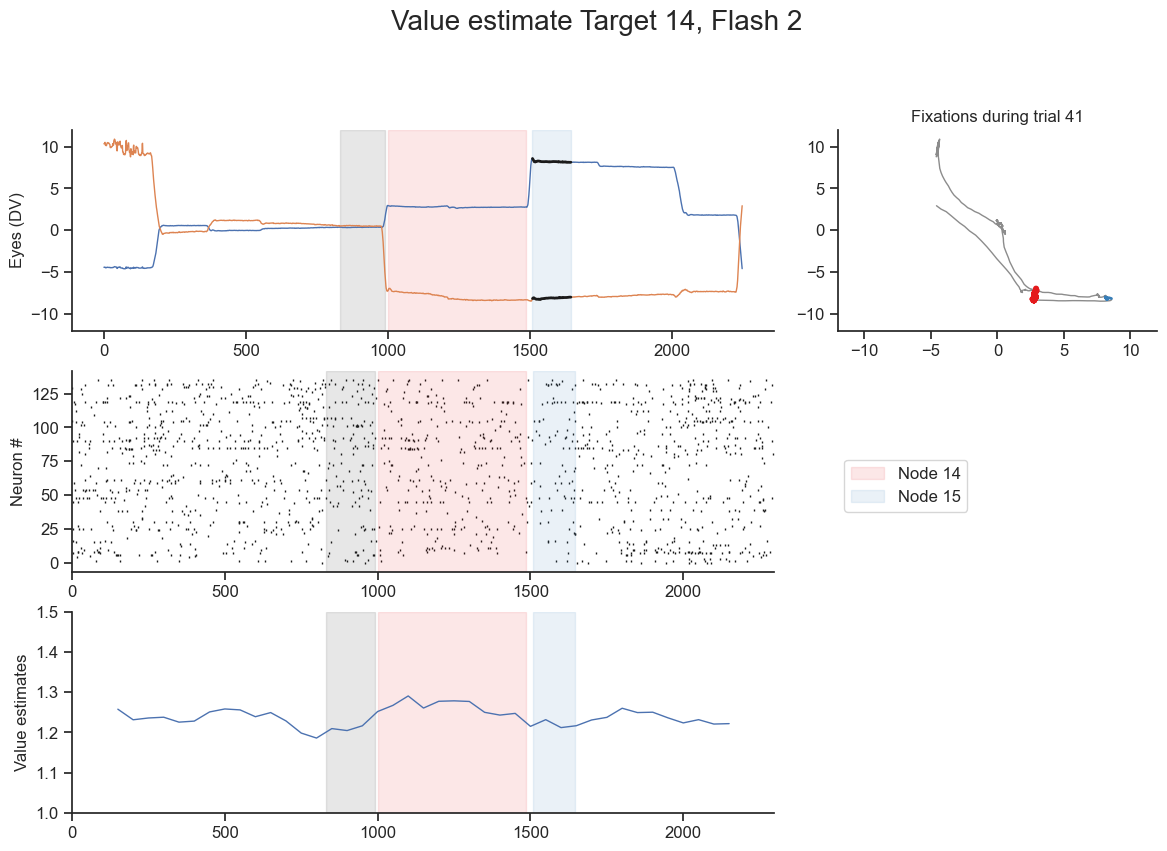

In [189]:
# train decoder on choice fixations

for trial in trial_cand[:10]:
        
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    FR = spikes.data[:,unit_idx]
    
    # get spikes between trial onset to 1st action onset 
    w=100
    eye_idx = 2
    neural_idx = 0
    
    # pull trial for a single trial
    # plot eye trace in 4*4 grid
    eyes = trial_df[trial_df.trial==trial].timeseries.iloc[0][eye_idx]
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    trial_on = trial_df[trial_df.trial==trial].start_time.values[0]
    
    fixations_during_trial = fix_df.query("trial == @ trial")
    
    node_df = nwbfile.intervals["node_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    node_on = node_df.t_on.values[0]-trial_on
    action_df = nwbfile.intervals["action_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    action_on = action_df.t_on.values[0]-trial_on
        
    color_seq = sns.color_palette('Set1',len(fixations_during_trial))
    
    plt.close('all')
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(nrows=4, ncols=3)
    ax=fig.add_subplot(gs[0,2])
    ax.plot(eyes.data[:, 0], eyes.data[:, 1], alpha=0.5, c="k", lw=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
        
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        if fix.planning:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=2)
        if fix.choice:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=4)
    
        ii=ii+1
    
    
    ax.set_ylim([-12, 12])
    ax.set_xlim([-12, 12])
    ax.set_title("Fixations during trial %i" % trial)
    
    # sns.despine(bottom=False,left=False)
    
    # plot eyetracking data separately for x, y, for alignment with neural data visualization
    ax = fig.add_subplot(gs[0,:2])
    ax.plot(eyes.timestamps-trial_on, eyes.data)
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
            
        if fix.planning:
            ax.plot(eyes.timestamps[idx]-trial_on,fixation_trace, c='k', ls='-',lw=2)
            
        ii=ii+1
    
    ax.set_ylabel("Eyes (DV)")
    ax.set_ylim([-12, 12])
    
    
    # plot spike raster
    FR = spikes.data[:, unit_idx]
    ax = fig.add_subplot(gs[1,:2])
    X, Y = np.where(FR)
    X = (X + spikes.timestamps[0]-trial_on)
    ax.scatter(X, Y, marker = "|", c="k", s=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
       
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1,label=f"Node {fix.fix_node}")
    
        ii=ii+1
    
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Neuron #")
    # ax.set_xlabel("Time in session (ms)")
    ax.legend(loc=(1.1,0.3))
    sns.despine()
    
    
    # plot predicted probability for node of interest only
    
    timestamps = np.arange(150,FR.shape[0]-150+50,50)
    w=150
        
    pred_val = np.zeros(len(timestamps))
    
    for ii,t in enumerate(timestamps): 
    
        pred_val[ii] = lasso_cv.predict(FR[t-w:t+w,:].mean(axis=0, keepdims=True))[0]
    
    
    colors16 = [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728",
        "#9467bd","#8c564b","#e377c2","#7f7f7f",
        "#bcbd22","#17becf","#a55194","#393b79",
        "#637939","#8c6d31","#843c39","#cedb9c"
    ]
    
    
    ax = fig.add_subplot(gs[2,:2])   
    ax.plot(timestamps,pred_val)  
    ax.set_ylim(1,1.5)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
    
        ii=ii+1
    
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Value estimates")
    # ax.set_ylim(0,0.15)
    # ax.set_xlabel("Time in session (ms)")
    # ax.legend(ncols=2,loc=(1.1,0.5))
    sns.despine()

    
    plt.suptitle('Value estimate Target %i, Flash %i' % (trial_df[trial_df.trial==trial].target.values[0],
                  trial_df[trial_df.trial==trial].blocktrialnumber.values[0]),fontsize=20)
    plt.savefig('Flash trial value estimates trial %i, target, session %s, OFC' % (trial, date))


In [640]:
choice_df, choice_spikes, neuron_df = combine_data('HPC','action_on',"(trialerror == 0)",'London')
flash_df, flash_spikes, neuron_df = combine_data('HPC','action_on',"(trialerror == 1)",'London')
flash_fix_df, flash_fix_spikes, _ = combine_data('HPC','fixations',"(trialerror == 1)",'London')
choice_df.loc[choice_df.graph_distance>2,'graph_distance']=3

In [636]:
flash_fix_df, flash_fix_spikes, _ = combine_data('HPC','fixations',"(trialerror == 1)",'London')

London_TeleWorld_4x4_101124_spikes.nwb


349it [00:00, 2646.19it/s]


London_TeleWorld_4x4_100324_spikes.nwb


324it [00:00, 5335.11it/s]


London_TeleWorld_4x4_092124_spikes.nwb


321it [00:00, 2239.78it/s]


London_TeleWorld_4x4_092324_spikes.nwb


311it [00:00, 2498.05it/s]


London_TeleWorld_4x4_092524_spikes.nwb


306it [00:00, 2278.23it/s]


London_TeleWorld_4x4_100124_spikes.nwb


318it [00:00, 1614.56it/s]


London_TeleWorld_4x4_100924_spikes.nwb


330it [00:00, 2515.27it/s]


In [637]:
choice_df, choice_spikes, neuron_df = combine_data('HPC','action_on',"(trialerror == 0)",'London')
flash_df, flash_spikes, neuron_df = combine_data('HPC','action_on',"(trialerror == 1)",'London')
flash_fix_df, flash_fix_spikes, _ = combine_data('HPC','fixations',"(trialerror == 1)",'London')
choice_df.loc[choice_df.graph_distance>2,'graph_distance']=3
flash_fix_df['graph_distance']=flash_fix_df['distance']
flash_fix_df.loc[flash_fix_df.graph_distance>2,'graph_distance']=3

In [491]:
nav_fix_df, nav_fix_spikes, _ = combine_data('HPC','fixations',"(trialerror == 0)",'London')

London_TeleWorld_4x4_101124_spikes.nwb


5751it [00:12, 471.40it/s]


London_TeleWorld_4x4_100324_spikes.nwb


5571it [00:09, 596.05it/s]


London_TeleWorld_4x4_092124_spikes.nwb


5739it [00:10, 537.99it/s]


London_TeleWorld_4x4_092324_spikes.nwb


5688it [00:07, 737.69it/s]


London_TeleWorld_4x4_092524_spikes.nwb


5364it [00:09, 566.80it/s]


London_TeleWorld_4x4_100124_spikes.nwb


5509it [00:09, 564.30it/s]


London_TeleWorld_4x4_100924_spikes.nwb


5647it [00:09, 585.51it/s]


In [15]:
def value_nav_flash(date,ss):
# split train and test for choice fixations

    ses_df = choice_df.query('Session==@date').copy()
    FR = choice_spikes[ss]
    
    # FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
    #      np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    ses_df['Neural']=list(FR)
    
    balanced_df = (
        ses_df
        .groupby('graph_distance', group_keys=False)
        .apply(lambda x: x.sample(1000, replace=True, random_state=42))
        .reset_index(drop=True)
    )
    
    y = balanced_df['graph_distance'].values   # stratification variable
    X = np.arange(len(y))  # or keep as DataFrame if you prefer
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    train_idx, test_idx = list(skf.split(X, y))[0]
    train_df = balanced_df.iloc[train_idx]
    test_df = balanced_df.iloc[test_idx]
    
    lasso_cv = predict_value_clf(train_df, 'train', lasso_cv=[])
    choice_trained = predict_value_clf(train_df, 'predict', lasso_cv=lasso_cv)
    choice_held_out = predict_value_clf(test_df, 'predict', lasso_cv=lasso_cv)
    nav1 = predict_value_clf(test_df.query('blocktrialnumber==3'), 'predict', lasso_cv=lasso_cv)
    nav2 = predict_value_clf(test_df.query('blocktrialnumber==4'), 'predict', lasso_cv=lasso_cv)
    
    
    # predict values of target nodes in flash trials, action on
    ses_df = flash_df.query('Session==@date').copy()
    FR = flash_spikes[ss]
    
    # FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
    #      np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    ses_df['Neural']=list(FR)
    
    flash1_target = predict_value_clf(ses_df.query('blocktrialnumber==1'), 'predict', lasso_cv=lasso_cv)
    flash2_target = predict_value_clf(ses_df.query('blocktrialnumber==2'), 'predict', lasso_cv=lasso_cv)
    flash1_target = np.concat([flash1_target,ses_df.query('blocktrialnumber==1').pre_distance.values.reshape(1,-1)])
    flash2_target = np.concat([flash2_target,ses_df.query('blocktrialnumber==2').pre_distance.values.reshape(1,-1)])

    # predict values of non-target nodes in flash trials
    ses_df = flash_fix_df.query('Session==@date').copy()
    FR = flash_fix_spikes[ss]
    
    # FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
    #      np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    ses_df['Neural']=list(FR)
    ses_df = ses_df[ses_df.fix_node!=ses_df.target].query('duration>50')
    flash1_nontarget = predict_value_clf(ses_df.query('blocktrialnumber==1'), 'predict', lasso_cv=lasso_cv,fix=1)
    flash2_nontarget = predict_value_clf(ses_df.query('blocktrialnumber==2'), 'predict', lasso_cv=lasso_cv,fix=1)
    flash1_nontarget = np.concat([flash1_nontarget,ses_df.query('blocktrialnumber==1').pre_distance.values.reshape(1,-1)])
    flash2_nontarget = np.concat([flash2_nontarget,ses_df.query('blocktrialnumber==2').pre_distance.values.reshape(1,-1)])
    
    return choice_trained, choice_held_out, np.concatenate([flash1_target,flash1_nontarget],axis=1), np.concatenate([flash2_target,flash2_nontarget],axis=1)

In [48]:
region='HPC'
choice_df, choice_spikes, neuron_df = combine_data(region,'action_on',"",'London')

London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


2735it [00:01, 1819.36it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


2597it [00:01, 2027.75it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


2581it [00:01, 1410.18it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


2630it [00:01, 1864.76it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


2606it [00:01, 1569.60it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


2614it [00:02, 1110.55it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


2616it [00:01, 1449.13it/s]


In [24]:
region='OFC'
choice_df, choice_spikes, neuron_df = combine_data(region,'action_on',"(trialerror == 0)",'London')
flash_df, flash_spikes, neuron_df = combine_data(region,'action_on',"(trialerror == 1)",'London')
flash_fix_df, flash_fix_spikes, _ = combine_data(region,'fixations',"(trialerror == 1)",'London')

choice_df.loc[choice_df.graph_distance>2,'graph_distance']=3
flash_df.loc[flash_df.graph_distance>2,'graph_distance']=3
flash_fix_df['graph_distance']=flash_fix_df['distance']
flash_fix_df.loc[flash_fix_df.graph_distance>2,'graph_distance']=3

London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


2545it [00:01, 1376.27it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


2417it [00:01, 1695.48it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


2401it [00:01, 1438.34it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


2450it [00:01, 1283.24it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


2427it [00:01, 1319.16it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


2432it [00:01, 1488.76it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


2434it [00:01, 1505.59it/s]


London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


190it [00:00, 1251.34it/s]

London_TeleWorld_4x4_100324_spikes.nwb


Building Spike Table


180it [00:00, 1517.05it/s]

London_TeleWorld_4x4_092124_spikes.nwb


Building Spike Table


180it [00:00, 1342.48it/s]

London_TeleWorld_4x4_092324_spikes.nwb


Building Spike Table


180it [00:00, 1406.23it/s]

London_TeleWorld_4x4_092524_spikes.nwb


Building Spike Table


179it [00:00, 1448.66it/s]

London_TeleWorld_4x4_100124_spikes.nwb


Building Spike Table


182it [00:00, 1172.72it/s]

London_TeleWorld_4x4_100924_spikes.nwb


Building Spike Table


182it [00:00, 1562.79it/s]

London_TeleWorld_4x4_101124_spikes.nwb



349it [00:00, 2442.45it/s]


London_TeleWorld_4x4_100324_spikes.nwb


324it [00:00, 3240.31it/s]


London_TeleWorld_4x4_092124_spikes.nwb


321it [00:00, 2516.62it/s]


London_TeleWorld_4x4_092324_spikes.nwb


311it [00:00, 2697.93it/s]


London_TeleWorld_4x4_092524_spikes.nwb


306it [00:00, 2498.36it/s]


London_TeleWorld_4x4_100124_spikes.nwb


318it [00:00, 2768.82it/s]


London_TeleWorld_4x4_100924_spikes.nwb


330it [00:00, 3108.06it/s]


In [10]:
def create_grid(n,barriers=[],teleports=[]):

    # create n*n grid, transition matrix
    T = np.zeros((n*n,n*n))
    block = np.diag(np.ones(n-1), k=1) + np.diag(np.ones(n-1), k=-1)
    
    for c in range(n):
        T[c*n:(c+1)*n,c*n:(c+1)*n] = block
        cols = np.arange(c, n*n, n)  
        row_idx, col_idx = np.meshgrid(cols, cols, indexing='ij')  # shape (4, 4)
        T[row_idx, col_idx] = block

    if len(barriers)>0:
        for barrier in barriers:
            T[barrier[0],barrier[1]]=0
            T[barrier[1],barrier[0]]=0

    if len(teleports)>0:
        for teleport in teleports:
            T[teleport[0],teleport[1]]=1
            T[teleport[1],teleport[0]]=1  
    
    return T


def distance_matrix(T):
    
    # calculate distance 
    n_state = T.shape[0]
    D=np.zeros((n_state,n_state))
    step=0
    connected = np.eye(n_state)
    nsteps = np.eye(n_state)

    if np.sum(T.mean(axis=0)==0)>0:

        D = np.nan    # check if all the nodes are reachable

    else:
    
        while connected.mean()<1:
        
            step=step+1
            nsteps = np.dot(nsteps,T)*(1-connected)
        
            D[nsteps>0]=step
            connected[nsteps>0]=1

    return D

In [11]:
T = create_grid(4,teleports=[[0,15]])
D = distance_matrix(T)

In [25]:
pre_distance_all = []

for ss, date in enumerate(choice_df.Session.unique()):

    pre_target = []
    ses_df = flash_fix_df[flash_fix_df.Session==date]
    for ii,bb in enumerate(ses_df.block.unique()):
        current = ses_df[ses_df.block==bb]
        if ii>0:
            previous = ses_df[ses_df.block==bb-1]
            pre_target.append(np.ones(len(current))*previous.target.unique()[0])
        else:
            pre_target.append(np.ones(len(current))*np.nan)
            
    pre_target = np.concat(pre_target)
    
    pre_distance = np.ones(len(ses_df))*np.nan
    for ii in range(len(ses_df)):
        if not np.isnan(pre_target[ii]):
            pre_distance[ii]=D[int(pre_target[ii]),int(ses_df.fix_node.values[ii])]
            if pre_distance[ii]>3:
                pre_distance[ii]=3

    pre_distance_all.append(pre_distance)
    
flash_fix_df['pre_distance'] = np.concat(pre_distance_all)

In [26]:
pre_distance_all = []

for ss, date in enumerate(choice_df.Session.unique()):

    pre_target = []
    ses_df = flash_df[flash_df.Session==date]
    for ii,bb in enumerate(ses_df.block.unique()):
        current = ses_df[ses_df.block==bb]
        if ii>0:
            previous = ses_df[ses_df.block==bb-1]
            pre_target.append(np.ones(len(current))*previous.target.unique()[0])
        else:
            pre_target.append(np.ones(len(current))*np.nan)
            
    pre_target = np.concat(pre_target)
    
    pre_distance = np.ones(len(ses_df))*np.nan
    for ii in range(len(ses_df)):
        if not np.isnan(pre_target[ii]):
            pre_distance[ii]=D[int(pre_target[ii]),int(ses_df.node.values[ii])]
            if pre_distance[ii]>3:
                pre_distance[ii]=3
                
    pre_distance_all.append(pre_distance)
    
flash_df['pre_distance'] = np.concat(pre_distance_all)

In [27]:
train=[]
test=[]
flash1=[]
flash2=[]

for ss,date in tqdm(enumerate(choice_df.Session.unique())):
    choice_trained, choice_held_out, flash1_value, flash2_value = value_nav_flash(date,ss)
    train.append(choice_trained)
    test.append(choice_held_out)
    flash1.append(flash1_value)
    flash2.append(flash2_value)

C:\Users\ML_4\AppData\Local\Temp\ipykernel_24304\2290146792.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1000, replace=True, random_state=42))
C:\Users\ML_4\AppData\Local\Temp\ipykernel_24304\2290146792.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1000, replace=True, random_state=42))
C:\Users\ML_4\AppData\Local\Temp\ipykernel_24304\2290146

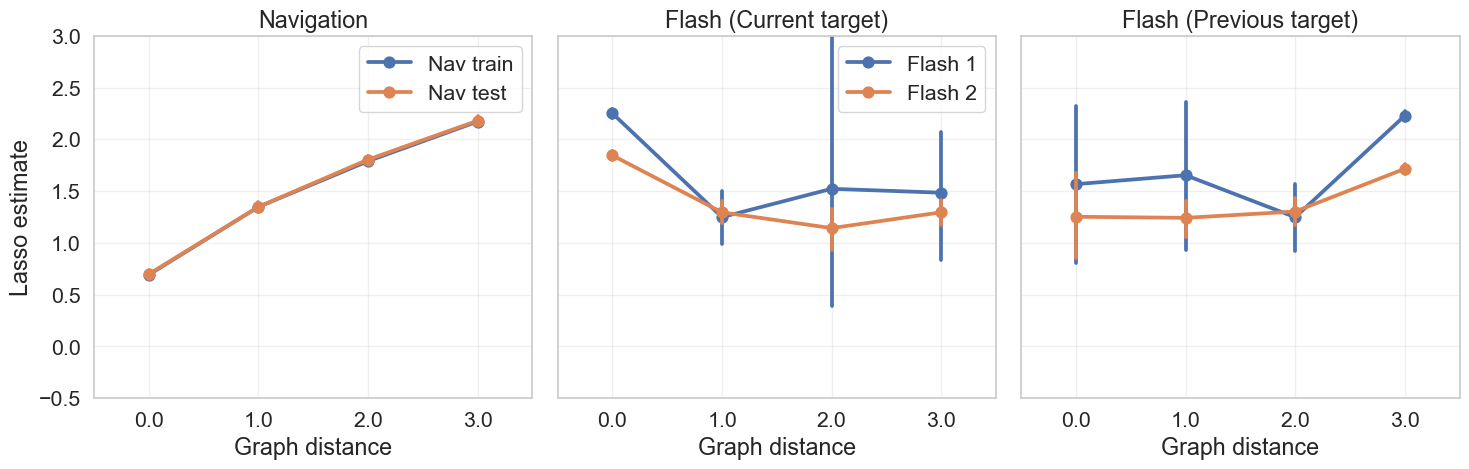

In [32]:
plt.close('all')

# --- Create subplots ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.set(style="whitegrid", font_scale=1.4) 

# --- 1. Nav train vs Nav test ---
sns.pointplot(
    data=plot_df[plot_df['group'].isin(['Nav train', 'Nav test'])],
    x='graph_distance',
    y='value',
    hue='group',
    ax=axes[0])
axes[0].set_title('Navigation')
axes[0].set_xlabel('Graph distance')
axes[0].set_ylabel('Lasso estimate')
axes[0].set_ylim(-0.5,3)

# --- 2. Flash 1 vs Flash 2 ---
sns.pointplot(
    data=plot_df[plot_df['group'].isin(['Flash 1', 'Flash 2'])],
    x='graph_distance',
    y='value',
    hue='group',
    ax=axes[1]
)
axes[1].set_title('Flash (Current target)')
axes[1].set_xlabel('Graph distance')
axes[1].set_ylabel('')
axes[1].set_ylim(-0.5,3)

# --- 3. Flash 1 pre vs Flash 2 pre ---
sns.pointplot(
    data=plot_df[plot_df['group'].isin(['Flash 1 pre', 'Flash 2 pre'])],
    x='graph_distance',
    y='value',
    hue='group',
    ax=axes[2],legend=False
)
axes[2].set_title('Flash (Previous target)')
axes[2].set_xlabel('Graph distance')
axes[2].set_ylabel('')
axes[2].set_ylim(-0.5,3)

# --- Layout and legend handling ---
for ax in axes[:2]:
    ax.legend().set_title('')
    ax.grid(True, alpha=0.3)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('Flash value estimates current and previous target, OFC 2')

In [46]:
gg='Flash 1'
plot_df.query('(group==@gg)').groupby('graph_distance').size()

graph_distance
0.0    634
1.0     62
2.0      3
3.0     10
dtype: int64

In [44]:
gg='Flash 1'
plot_df.query('(graph_distance==2)&(group==@gg)')

graph_distance     value    group session
4097              2.0  3.425801  Flash 1  101124
31173             2.0  0.752032  Flash 1  100924
31175             2.0  0.388984  Flash 1  100924

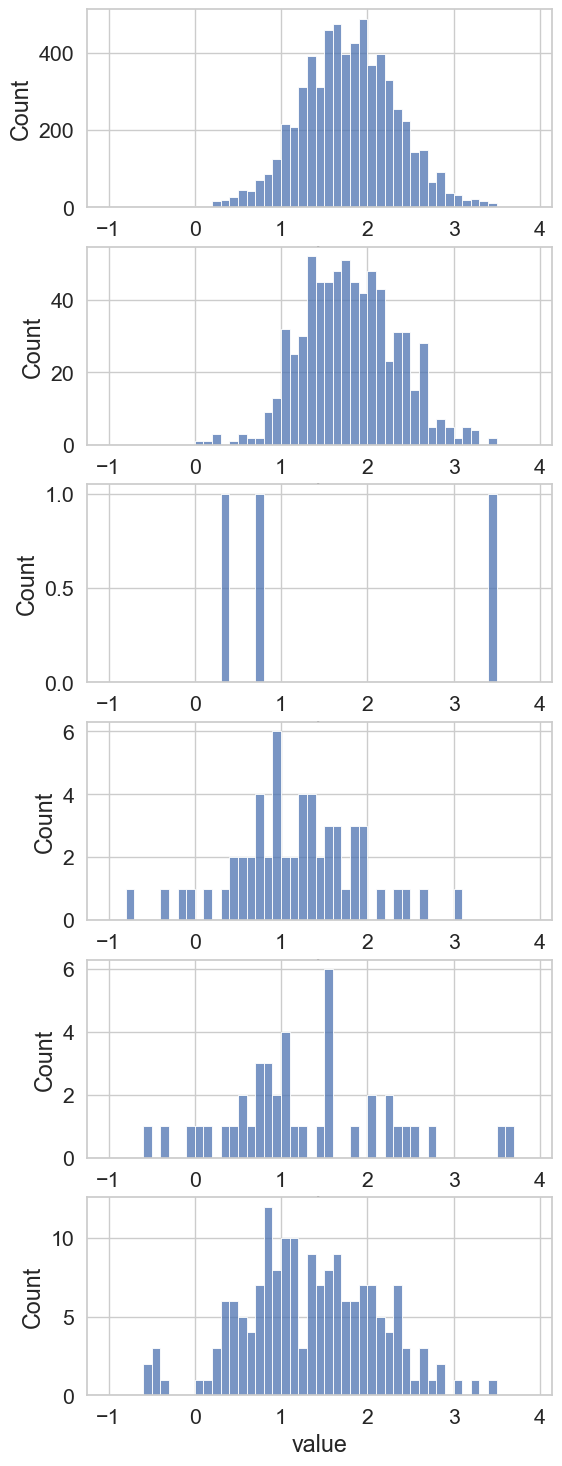

In [37]:
plt.close('all')
fig, axes = plt.subplots(6,1,figsize=(6,18))
for ii, gg in enumerate(plot_df.group.unique()):
    sns.histplot(data=plot_df.query('(graph_distance==2)&(group==@gg)'),x='value',ax=axes[ii],bins=np.arange(-1,4,0.1))

In [30]:
plt.close('all')

# --- Concatenate all sessions into one long-form DataFrame ---
all_data = []

for ss, date in enumerate(choice_df.Session.unique()):
    session_df = pd.DataFrame({
        'graph_distance': np.concatenate([
            train[ss][0],
            test[ss][0],
            flash1[ss][0],
            flash2[ss][0],
            flash1[ss][2],
            flash2[ss][2]
        ]),
        'value': np.concatenate([
            train[ss][1],
            test[ss][1],
            flash1[ss][1],
            flash2[ss][1],
            flash1[ss][1],
            flash2[ss][1]
        ]),
        'group': (['Nav train'] * len(train[ss][0])
                  + ['Nav test'] * len(test[ss][0])
                  + ['Flash 1'] * len(flash1[ss][0])
                  + ['Flash 2'] * len(flash2[ss][0])
                  + ['Flash 1 pre'] * len(flash1[ss][0])
                  + ['Flash 2 pre'] * len(flash2[ss][0])
                 ),
        'session': date  # optional, to keep track of which session it came from
    })
    all_data.append(session_df)

# Combine across sessions
plot_df = pd.concat(all_data, ignore_index=True)

# # --- Plot combined data ---
# plt.figure(figsize=(8, 6))
# sns.violinplot(
#     data=plot_df[(plot_df.group!='Flash 1 pre') & ()],
#     x='graph_distance',
#     y='value',
#     hue='group',
#     split=False,
#     inner=None,
#     linewidth=1,
#     cut=0
#     # palette=sns.color_palette('pastel',8)
# )

# plt.ylabel('Lasso estimate')
# plt.xlabel('Graph distance')
# plt.title('Flash trial value estimates (All sessions combined)')

# # Legend
# plt.legend(
#     title='Group',
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left',
#     frameon=False,
#     fontsize=12
# )

# plt.ylim(-1,5)
# plt.tight_layout()
# # plt.savefig('Flash trial value estimates - all sessions combined', dpi=300, bbox_inches='tight')
# plt.show()


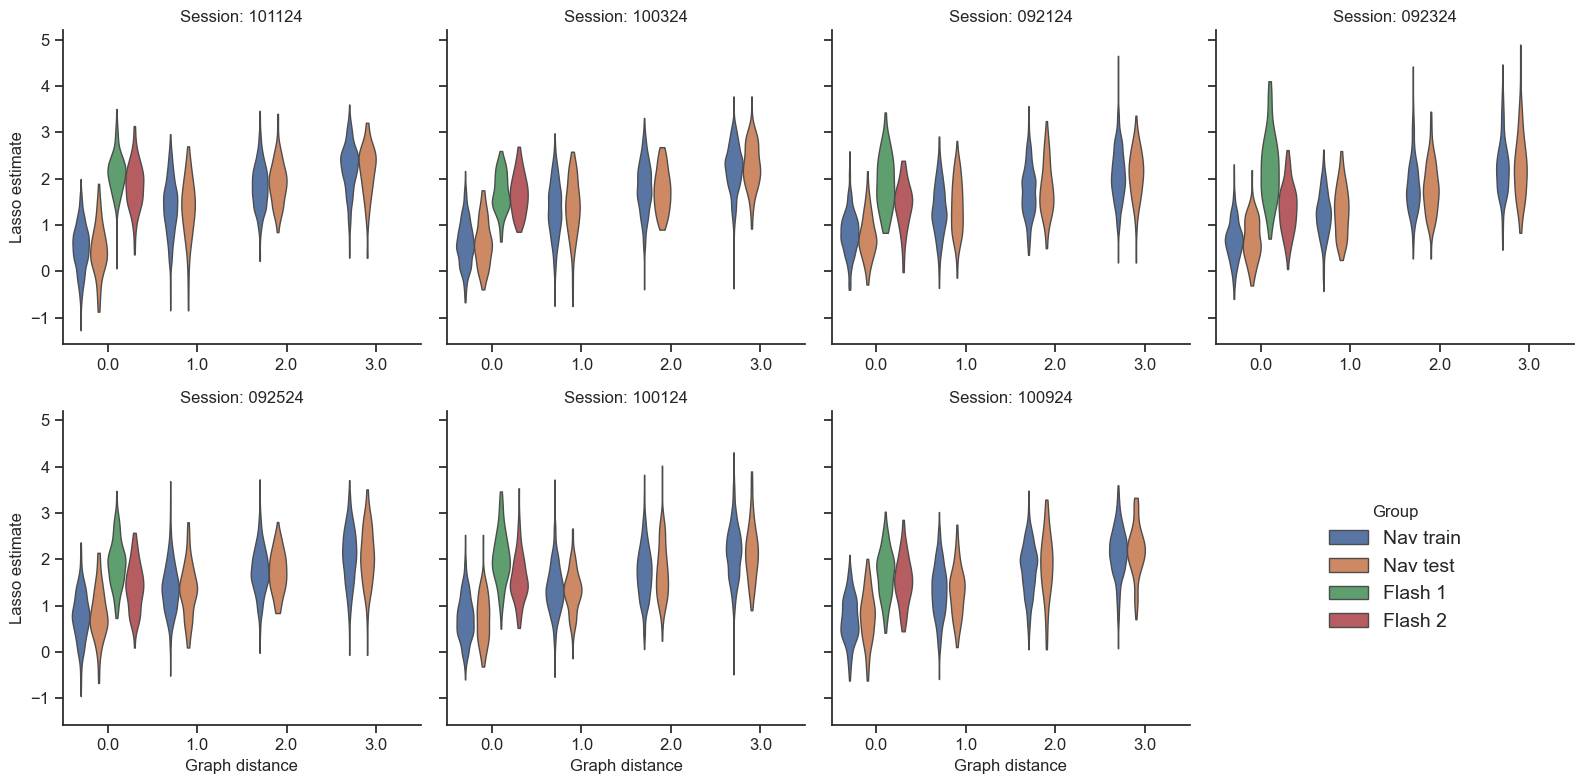

In [369]:
plt.close('all')

n_sessions = len(train)
ncols = 4  # adjust based on how many subplots you want per row
nrows = int(np.ceil(n_sessions / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharey=True)
axes = axes.flatten()

for ss, date in enumerate(choice_df.Session.unique()):
    # --- Combine data into one long-form DataFrame ---
    plot_df = pd.DataFrame({
        'graph_distance': np.concatenate([
            train[ss][0],
            test[ss][0],
            flash1[ss][0],
            flash2[ss][0]
        ]),
        'value': np.concatenate([
            train[ss][1],
            test[ss][1],
            flash1[ss][1],
            flash2[ss][1]
        ]),
        'group': (['Nav train'] * len(train[ss][0])
                  + ['Nav test'] * len(test[ss][0])
                  + ['Flash 1'] * len(flash1[ss][0])
                  + ['Flash 2'] * len(flash2[ss][0]))
    })
    
    # --- Plot ---
    ax = axes[ss]
    sns.violinplot(
        data=plot_df,
        x='graph_distance',
        y='value',
        hue='group',
        split=False,
        inner=None,
        linewidth=1,
        cut=0,
        ax=ax
    )
    ax.set_title(f"Session: {date}")
    ax.set_xlabel('')
    ax.set_ylabel('Lasso estimate')

    # Remove legend for all but one
    if ss != 0:
        ax.get_legend().remove()
    if np.floor(ss/4)==1:
        ax.set_xlabel('Graph distance')
        
# --- Place legend inside axes[7] ---
axes[7].clear()  # clear the violin if any
axes[7].set_axis_off()  # hide axes frame

# get handles/labels from first plot that has them
handles, labels = axes[0].get_legend_handles_labels()
axes[7].legend(
    handles,
    labels,
    loc='center',
    frameon=False,
    fontsize=14,
    title='Group'
)
axes[0].get_legend().remove()

plt.tight_layout()
plt.savefig('Flash trial value estimates, All sessions')


In [17]:
def predict_value_clf(df, mode, time=np.arange(600,900), lasso_cv=[], fix=0):

    if mode == 'train':
        lasso_cv = make_pipeline(
            StandardScaler(),
            LassoCV(cv=5, random_state=42, n_alphas=100)
        )    


    if fix==0:
        timepoints, cell_num = df.iloc[0]['Neural'].shape
        
        data_all = np.concatenate([
            np.stack(df['Neural'].values),
            np.stack(df['graph_distance'].values)[:, None, np.newaxis].repeat(timepoints, axis=1)
        ], axis=2)
        
        data = data_all[:,time,:].mean(axis=1)

    if fix==1:
        data = np.concatenate([
                np.stack(df['Neural'].values),
                np.stack(df['graph_distance'].values).reshape(-1,1)
                ], axis=1)
    
    if mode == 'train':
        lasso_cv.fit(data[:,:-1],data[:,-1])
        return lasso_cv 
        
    if mode == 'predict':
        pred_value = lasso_cv.predict(data[:,:-1])
        return [data[:,-1],pred_value]


In [124]:
def predict_value(rep = 2, ntrials = 1000, w = 150, slide = 50):

    
    timestamps = np.arange(w,1000-w+slide,slide)
    kf = KFold(n_splits=10, shuffle=True)
    lasso_cv = make_pipeline(
        StandardScaler(),
        LassoCV(cv=5, random_state=42, n_alphas=100)
    )    
    rsquare_all = []
    
    for ss, date in enumerate(choice_df.Session.unique()):
    
        print(ss,date)
    
        df = choice_df.query('Session==@date').copy()
        FR = choice_spikes[ss]

        FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
             np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
        
        df['Neural']=list(FR)
        
        rsquare = np.zeros((rep,len(timestamps)))
        
        for rr in tqdm(range(rep)):

            train_all = np.zeros((4,ntrials,FR.shape[1],FR.shape[2]+1))
            test_all = np.zeros((4,ntrials,FR.shape[1],FR.shape[2]+1))
            
            for ii in range(4):
                
                if ii<3:   
                    conditioned_beh = df.query('graph_distance==@ii')
                else:
                    conditioned_beh = df.query('graph_distance>2')
            
                trialNum = np.array(conditioned_beh.index)
                train_ind, test_ind = list(kf.split(trialNum))[0]
                
                train_set = conditioned_beh.iloc[train_ind]
                index = np.random.randint(len(train_set),size=ntrials)
                train_all[ii,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
                train_all[ii,:,:,-1] = ii
                
                test_set = conditioned_beh.iloc[test_ind]
                index = np.random.randint(len(test_set),size=ntrials)
                test_all[ii,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
                test_all[ii,:,:,-1] = ii
            
            
            for ii,t in enumerate(timestamps): 
            
                train = train_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                lasso_cv.fit(train[:,:-1],train[:,-1])
                
                test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                # pred_value_temp = lasso_cv.predict(test[:,:-1])
                # pred_value[ii,:] = np.array([pred_value_temp[test[:,-1]==ii].mean() for ii in range(4)])
                rsquare[rr,ii] = lasso_cv.score(test[:,:-1],test[:,-1])

        rsquare_all.append(rsquare)
            
    return rsquare_all 

In [22]:
choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,'HPC',"node_on","(blocktrialnumber == 2)")
choice_df['istarget'] = choice_df['target']==choice_df['node']
# choice_df['blocktrialnumber']=choice_df.groupby(['Session','block']).cumcount()+1

London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


95it [00:00, 349.81it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


90it [00:00, 472.87it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


90it [00:00, 383.89it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


90it [00:00, 368.47it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


89it [00:00, 405.87it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


91it [00:00, 378.46it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


90it [00:00, 724.74it/s]


In [23]:
chosen_accuracy_all = decode_target(choice_df, choice_spikes, LinearDiscriminantAnalysis(),rep=2)  #  # SVC(probability=True)
# np.save('target identity decoding accuracy %s trialerror %i' % (region,te), chosen_accuracy_all, allow_pickle=True)

0 101124


100%|██████████| 2/2 [00:11<00:00,  5.87s/it]


1 100324


100%|██████████| 2/2 [00:14<00:00,  7.39s/it]


2 092124


100%|██████████| 2/2 [00:34<00:00, 17.48s/it]


3 092324


100%|██████████| 2/2 [00:17<00:00,  8.96s/it]


4 092524


100%|██████████| 2/2 [00:25<00:00, 12.95s/it]


5 100124


100%|██████████| 2/2 [00:38<00:00, 19.04s/it]


6 100924


100%|██████████| 2/2 [00:35<00:00, 17.78s/it]


In [74]:
region='HPC'
te=1
chosen_accuracy_hpc = np.load('target identity decoding accuracy %s Flash %i.npy' % (region,te))

# region='HPC'
te=2
chosen_accuracy_ofc = np.load('target identity decoding accuracy %s Flash %i.npy' % (region,te))

In [53]:
chosen_accuracy_all.shape

(7, 20, 17)

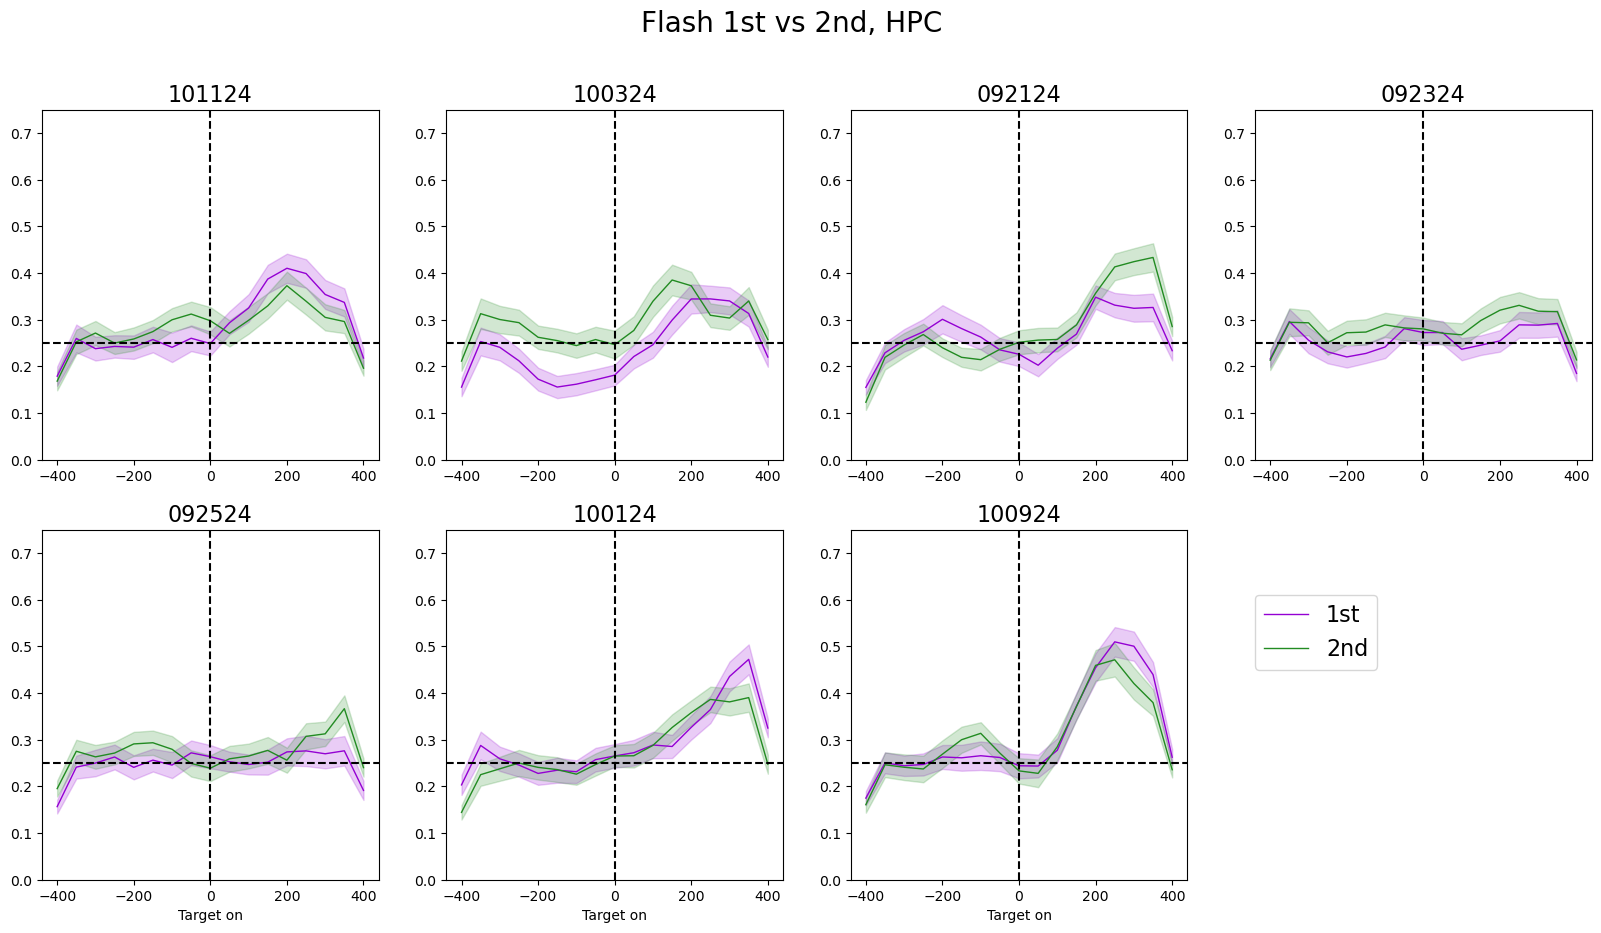

In [75]:
w=100
slide=50
timestamps = np.arange(w,1000-w+slide,slide)
Sessions = ['101124','100324','092124','092324','092524','100124','100924']
#choice_df0.Session.unique()

plt.close('all')
fig, axes = plt.subplots(2,4,figsize=(20,10))

for ss in range(7):

    # choice fixation accuracy, cross validated
    node_acc = chosen_accuracy_hpc[ss] #chosen_accuracy
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    
    axes[np.divmod(ss,4)].plot(timestamps-500,mean,color='darkviolet',lw=1,label='1st')
    axes[np.divmod(ss,4)].fill_between(timestamps-500,mean-sem,mean+sem,color='darkviolet',alpha=0.2)


    node_acc = chosen_accuracy_ofc[ss] #chosen_accuracy
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    
    axes[np.divmod(ss,4)].plot(timestamps-500,mean,color='forestgreen',lw=1,label='2nd')
    axes[np.divmod(ss,4)].fill_between(timestamps-500,mean-sem,mean+sem,color='forestgreen',alpha=0.2)
    
    axes[np.divmod(ss,4)].axvline(c='k',ls='--')
    axes[np.divmod(ss,4)].axhline(0.25,c='k',ls='--')
    axes[np.divmod(ss,4)].set_ylim(0,0.75)
    # axes[np.divmod(ss,4)].set_xlim(-300,300)
    axes[np.divmod(ss,4)].set_title(Sessions[ss],fontsize=16)

    if ss==6:
        axes[np.divmod(ss,4)].legend(fontsize=16,loc=(1.2,0.6))

    if np.divmod(ss,4)[0]==1:
        axes[np.divmod(ss,4)].set_xlabel('Target on')

axes[1,3].set_visible(False)

plt.suptitle('Flash 1st vs 2nd, HPC', fontsize=20)
plt.savefig('Flash 1st vs 2nd, HPC, target identity, London')

In [179]:
filename = DATA_DIR/"London_TeleWorld_4x4_101124_spikes.nwb/"
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 

fix_df = nwbfile.intervals["fixations"].to_dataframe().query("duration>50")
fix_df['planning'] = (fix_df.duration<300) & (fix_df.active_prob<0.2)
fix_df['choice'] = (fix_df.duration>300) & (fix_df.active_prob>0.2)
fix_df = fix_df.query("planning | choice")

# get good units
unitNames = nwbfile.units.to_dataframe()
unit_params = {"drift": 2, "min_fr": 1}
unit_idx = np.where((unitNames.region == 'OFC') & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]

neural_idx = 0
trial_df = nwbfile.trials.to_dataframe()

In [182]:
trial_cand = choice_df.query('Session==@date').trial.unique()

0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124
0 101124


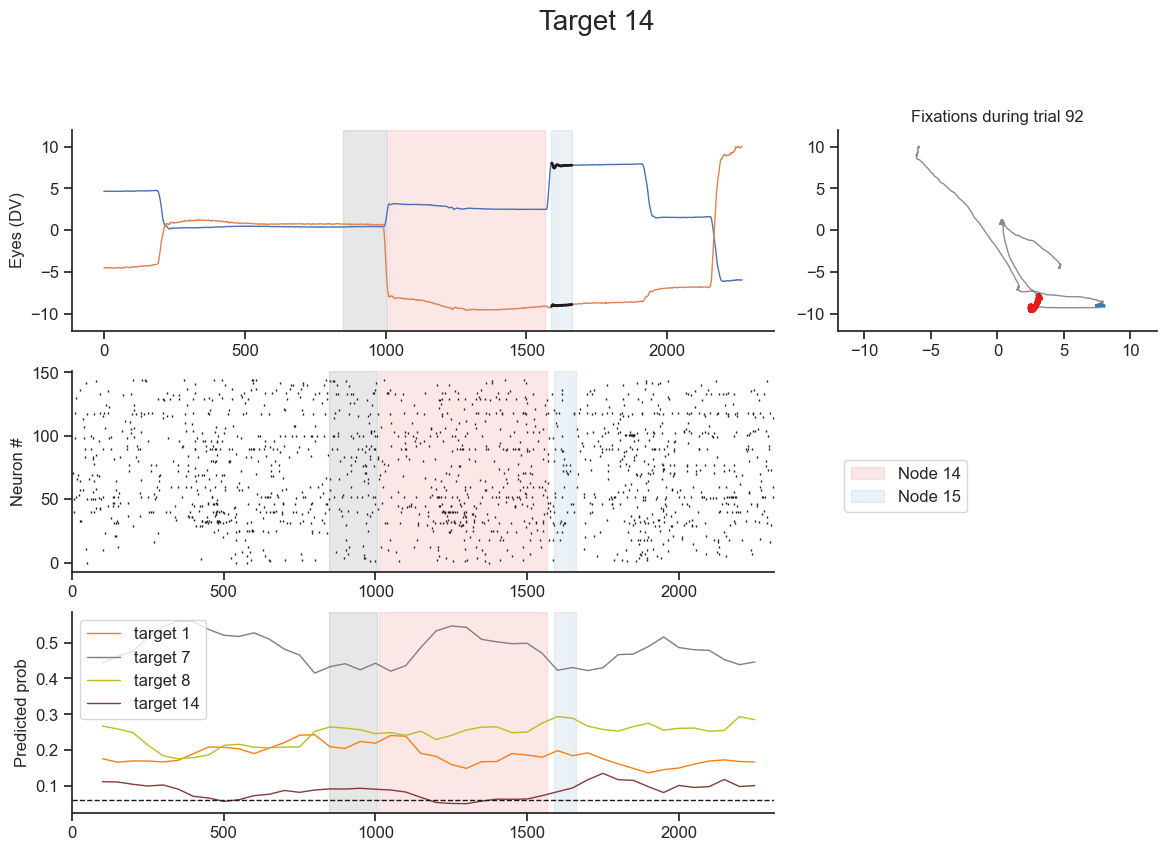

In [184]:
filename = DATA_DIR/"London_TeleWorld_4x4_101124_spikes.nwb/"
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 

fix_df = nwbfile.intervals["fixations"].to_dataframe().query("duration>50")
fix_df['planning'] = (fix_df.duration<300) & (fix_df.active_prob<0.2)
fix_df['choice'] = (fix_df.duration>300) & (fix_df.active_prob>0.2)
fix_df = fix_df.query("planning | choice")

# get good units
unitNames = nwbfile.units.to_dataframe()
unit_params = {"drift": 2, "min_fr": 1}
unit_idx = np.where((unitNames.region == 'OFC') & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]

neural_idx = 0
trial_df = nwbfile.trials.to_dataframe()

trial_cand = choice_df.query('Session==@date').trial.unique()

# train decoder on choice fixations

for trial in trial_cand[:20]:
        
    target_clf = get_target_clf(choice_df, choice_spikes, LogisticRegression(multi_class='multinomial'),trial)  #  # SVC(probability=True)
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    FR = spikes.data[:,unit_idx]
    
    # get spikes between trial onset to 1st action onset 
    w=100
    eye_idx = 2
    neural_idx = 0
    
    # pull trial for a single trial
    # plot eye trace in 4*4 grid
    eyes = trial_df[trial_df.trial==trial].timeseries.iloc[0][eye_idx]
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    trial_on = trial_df[trial_df.trial==trial].start_time.values[0]
    
    fixations_during_trial = fix_df.query("trial == @ trial")
    
    node_df = nwbfile.intervals["node_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    node_on = node_df.t_on.values[0]-trial_on
    action_df = nwbfile.intervals["action_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    action_on = action_df.t_on.values[0]-trial_on
        
    color_seq = sns.color_palette('Set1',len(fixations_during_trial))
    
    plt.close('all')
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(nrows=4, ncols=3)
    ax=fig.add_subplot(gs[0,2])
    ax.plot(eyes.data[:, 0], eyes.data[:, 1], alpha=0.5, c="k", lw=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
        
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        if fix.planning:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=2)
        if fix.choice:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=4)
    
        ii=ii+1
    
    
    ax.set_ylim([-12, 12])
    ax.set_xlim([-12, 12])
    ax.set_title("Fixations during trial %i" % trial)
    
    # sns.despine(bottom=False,left=False)
    
    # plot eyetracking data separately for x, y, for alignment with neural data visualization
    ax = fig.add_subplot(gs[0,:2])
    ax.plot(eyes.timestamps-trial_on, eyes.data)
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
            
        if fix.planning:
            ax.plot(eyes.timestamps[idx]-trial_on,fixation_trace, c='k', ls='-',lw=2)
            
        ii=ii+1
    
    ax.set_ylabel("Eyes (DV)")
    ax.set_ylim([-12, 12])
    
    
    # plot spike raster
    FR = spikes.data[:, unit_idx]
    ax = fig.add_subplot(gs[1,:2])
    X, Y = np.where(FR)
    X = (X + spikes.timestamps[0]-trial_on)
    ax.scatter(X, Y, marker = "|", c="k", s=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
       
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1,label=f"Node {fix.fix_node}")
    
        ii=ii+1
    
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Neuron #")
    # ax.set_xlabel("Time in session (ms)")
    ax.legend(loc=(1.1,0.3))
    sns.despine()
    
    
    # plot predicted probability for node of interest only
    
    timestamps = np.arange(100,FR.shape[0]-100+50,50)
    w=100
        
    pred_prob = np.zeros((len(timestamps),4))
    
    for ii,t in enumerate(timestamps): 
    
        pred_prob[ii,:] = target_clf.predict_proba(FR[t-w:t+w,:].mean(axis=0, keepdims=True))
    
    
    colors16 = [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728",
        "#9467bd","#8c564b","#e377c2","#7f7f7f",
        "#bcbd22","#17becf","#a55194","#393b79",
        "#637939","#8c6d31","#843c39","#cedb9c"
    ]
    
    
    ax = fig.add_subplot(gs[2,:2])   
    
    for jj,target in enumerate([1,7,8,14]):
        
        ax.plot(timestamps,pred_prob[:,jj],color=colors16[target],label=f"target {targets[jj]}")
        
    ax.axhline(1/16,color='k',ls='--')
    ax.legend()
    
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
    
        ii=ii+1
    
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Predicted prob")
    # ax.set_ylim(0,0.15)
    # ax.set_xlabel("Time in session (ms)")
    # ax.legend(ncols=2,loc=(1.1,0.5))
    sns.despine()
    
    
    plt.suptitle('Target %i' % trial_df[trial_df.trial==trial].target.values[0],fontsize=20)
    plt.savefig('Fixation trial decoding trial %i, target, session %s, OFC' % (trial, date))


In [20]:
for region in ['HPC']:
    for te in [0,1]:
        choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,region,"action_on","(trialerror == @te)")
        choice_df['istarget'] = choice_df['target']==choice_df['node']
        chosen_accuracy_all = decode_target(choice_df, choice_spikes, LinearDiscriminantAnalysis(),rep=10)  #  # SVC(probability=True)
        np.save('target identity decoding accuracy %s trialerror %i' % (region,te), chosen_accuracy_all, allow_pickle=True)

London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


2545it [00:04, 610.36it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


2417it [00:03, 681.74it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


2401it [00:05, 479.71it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


2450it [00:04, 582.25it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


2427it [00:04, 535.19it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


2432it [00:04, 540.41it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


2434it [00:03, 632.46it/s]


0 101124


100%|███████████████████████████████████████████| 10/10 [00:40<00:00,  4.01s/it]


1 100324


100%|███████████████████████████████████████████| 10/10 [01:25<00:00,  8.59s/it]


2 092124


100%|██████████████████████████████████████████| 10/10 [18:21<00:00, 110.18s/it]


3 092324


100%|███████████████████████████████████████████| 10/10 [05:21<00:00, 32.16s/it]


4 092524


100%|███████████████████████████████████████████| 10/10 [10:32<00:00, 63.26s/it]


5 100124


100%|██████████████████████████████████████████| 10/10 [20:32<00:00, 123.20s/it]


6 100924


100%|███████████████████████████████████████████| 10/10 [16:00<00:00, 96.09s/it]


London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


190it [00:00, 472.74it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


180it [00:00, 553.70it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


180it [00:00, 412.24it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


180it [00:00, 492.20it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


179it [00:00, 413.27it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


182it [00:00, 458.36it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


182it [00:00, 527.57it/s]


0 101124


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.71s/it]


1 100324


100%|███████████████████████████████████████████| 10/10 [00:47<00:00,  4.71s/it]


2 092124


100%|███████████████████████████████████████████| 10/10 [15:49<00:00, 94.97s/it]


3 092324


100%|███████████████████████████████████████████| 10/10 [03:34<00:00, 21.42s/it]


4 092524


100%|███████████████████████████████████████████| 10/10 [08:46<00:00, 52.69s/it]


5 100124


100%|██████████████████████████████████████████| 10/10 [18:36<00:00, 111.65s/it]


6 100924


100%|███████████████████████████████████████████| 10/10 [15:54<00:00, 95.42s/it]


London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


2545it [00:04, 535.56it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


2417it [00:03, 657.91it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


2401it [00:04, 503.73it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


2450it [00:04, 552.54it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


2427it [00:04, 513.33it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


2432it [00:04, 559.51it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


2434it [00:03, 673.68it/s]


0 101124


100%|███████████████████████████████████████████| 10/10 [16:10<00:00, 97.02s/it]


1 100324


100%|███████████████████████████████████████████| 10/10 [13:06<00:00, 78.63s/it]


2 092124


100%|███████████████████████████████████████████| 10/10 [11:06<00:00, 66.61s/it]


3 092324


100%|██████████████████████████████████████████| 10/10 [29:52<00:00, 179.24s/it]


4 092524


100%|███████████████████████████████████████████| 10/10 [11:58<00:00, 71.81s/it]


5 100124


100%|███████████████████████████████████████████| 10/10 [06:49<00:00, 40.96s/it]


6 100924


100%|███████████████████████████████████████████| 10/10 [07:44<00:00, 46.46s/it]


London_TeleWorld_4x4_101124_spikes.nwb
Building Spike Table


190it [00:00, 408.65it/s]


London_TeleWorld_4x4_100324_spikes.nwb
Building Spike Table


180it [00:00, 541.80it/s]


London_TeleWorld_4x4_092124_spikes.nwb
Building Spike Table


180it [00:00, 436.06it/s]


London_TeleWorld_4x4_092324_spikes.nwb
Building Spike Table


180it [00:00, 450.71it/s]


London_TeleWorld_4x4_092524_spikes.nwb
Building Spike Table


179it [00:00, 440.68it/s]


London_TeleWorld_4x4_100124_spikes.nwb
Building Spike Table


182it [00:00, 454.11it/s]


London_TeleWorld_4x4_100924_spikes.nwb
Building Spike Table


182it [00:00, 585.59it/s]


0 101124


100%|███████████████████████████████████████████| 10/10 [15:28<00:00, 92.84s/it]


1 100324


100%|██████████████████████████████████████████| 10/10 [28:42<00:00, 172.23s/it]


2 092124


100%|██████████████████████████████████████████| 10/10 [23:32<00:00, 141.28s/it]


3 092324


100%|██████████████████████████████████████████| 10/10 [35:28<00:00, 212.87s/it]


4 092524


100%|███████████████████████████████████████████| 10/10 [10:41<00:00, 64.10s/it]


5 100124


100%|██████████████████████████████████████████| 10/10 [27:19<00:00, 163.94s/it]


6 100924


100%|██████████████████████████████████████████| 10/10 [19:30<00:00, 117.06s/it]


In [ ]:
fix_df, fix_spikes, _ = combine_data(DATA_DIR,"HPC","fixations","trialerror == 0")

In [ ]:
chosen_accuracy_all, chosen_prob_all = decode_teleport(15)

In [53]:
chosen_accuracy_all1 = decode_target(choice_df1, choice_spikes1, LinearDiscriminantAnalysis())  #  # SVC(probability=True)

0 101124


100%|█████████████████████████████████████████████| 2/2 [01:52<00:00, 56.00s/it]


1 100324


100%|█████████████████████████████████████████████| 2/2 [01:21<00:00, 40.55s/it]


2 092124


100%|█████████████████████████████████████████████| 2/2 [01:24<00:00, 42.08s/it]


3 092324


100%|█████████████████████████████████████████████| 2/2 [01:51<00:00, 55.67s/it]


4 092524


100%|█████████████████████████████████████████████| 2/2 [01:22<00:00, 41.23s/it]


5 100124


100%|█████████████████████████████████████████████| 2/2 [01:05<00:00, 32.90s/it]


6 100924


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.33s/it]


In [85]:
kf = KFold(n_splits=10, shuffle=True)
list(kf.split(np.arange(100)))[0]

(array([ 0,  1,  2,  3,  4,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
        76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94,
        95, 96, 97, 98, 99]),
 array([ 5,  7,  8, 26, 33, 34, 45, 58, 78, 87]))

In [89]:
chosen_accuracy_all0 = decode_target(choice_df0, choice_spikes0, LinearDiscriminantAnalysis())  #  # SVC(probability=True), LinearDiscriminantAnalysis()

0 101124


100%|█████████████████████████████████████████████| 2/2 [00:10<00:00,  5.15s/it]


1 100324


100%|█████████████████████████████████████████████| 2/2 [00:12<00:00,  6.39s/it]


2 092124


100%|████████████████████████████████████████████| 2/2 [05:00<00:00, 150.12s/it]


3 092324


100%|█████████████████████████████████████████████| 2/2 [01:42<00:00, 51.10s/it]


4 092524


100%|█████████████████████████████████████████████| 2/2 [02:54<00:00, 87.05s/it]


5 100124


100%|████████████████████████████████████████████| 2/2 [07:30<00:00, 225.24s/it]


6 100924


100%|████████████████████████████████████████████| 2/2 [05:22<00:00, 161.40s/it]


In [58]:
chosen_accuracy_all0 = np.load('target identity decoding accuracy OFC trialerror 0.npy')
chosen_accuracy_all1 = np.load('target identity decoding accuracy OFC trialerror 1.npy')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


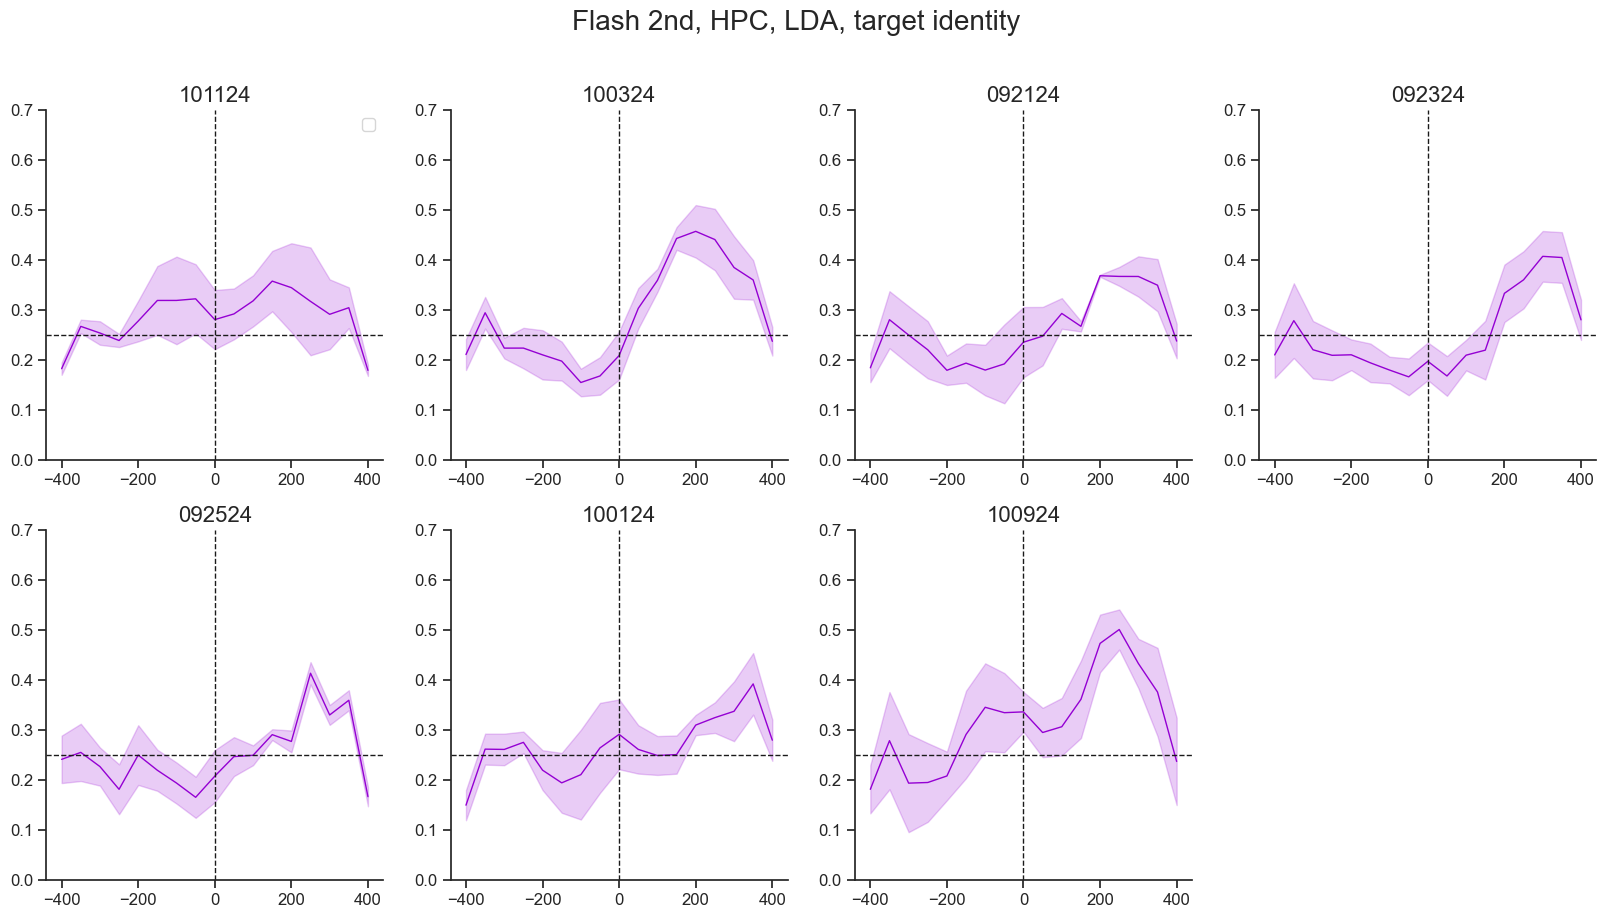

In [53]:
w=100
slide=50
timestamps = np.arange(w,1000-w+slide,slide)
Sessions = ['101124','100324','092124','092324','092524','100124','100924']
#choice_df0.Session.unique()

plt.close('all')
fig, axes = plt.subplots(2,4,figsize=(20,10))

for ss in range(7):

    # choice fixation accuracy, cross validated
    node_acc = chosen_accuracy_all[ss] #chosen_accuracy
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    
    axes[np.divmod(ss,4)].plot(timestamps-500,mean,color='darkviolet',lw=1)
    axes[np.divmod(ss,4)].fill_between(timestamps-500,mean-sem,mean+sem,color='darkviolet',alpha=0.2)

    # node_acc = chosen_accuracy_all1[ss] #chosen_accuracy
    # mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    # sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    
    # axes[np.divmod(ss,4)].plot(timestamps-500,mean,color='forestgreen',lw=1,label='Flash')
    # axes[np.divmod(ss,4)].fill_between(timestamps-500,mean-sem,mean+sem,color='forestgreen',alpha=0.2)
    
    axes[np.divmod(ss,4)].axvline(c='k',ls='--')
    axes[np.divmod(ss,4)].axhline(0.25,c='k',ls='--')
    axes[np.divmod(ss,4)].set_ylim(0,0.7)
    # axes[np.divmod(ss,4)].set_xlim(-300,300)
    axes[np.divmod(ss,4)].set_title(Sessions[ss],fontsize=16)

    if ss==0:
        axes[np.divmod(ss,4)].legend()

axes[1,3].set_visible(False)

plt.suptitle('Flash 2nd, HPC, LDA, target identity', fontsize=20)
plt.savefig('Flash 2nd, HPC, LDA, target identity, London')

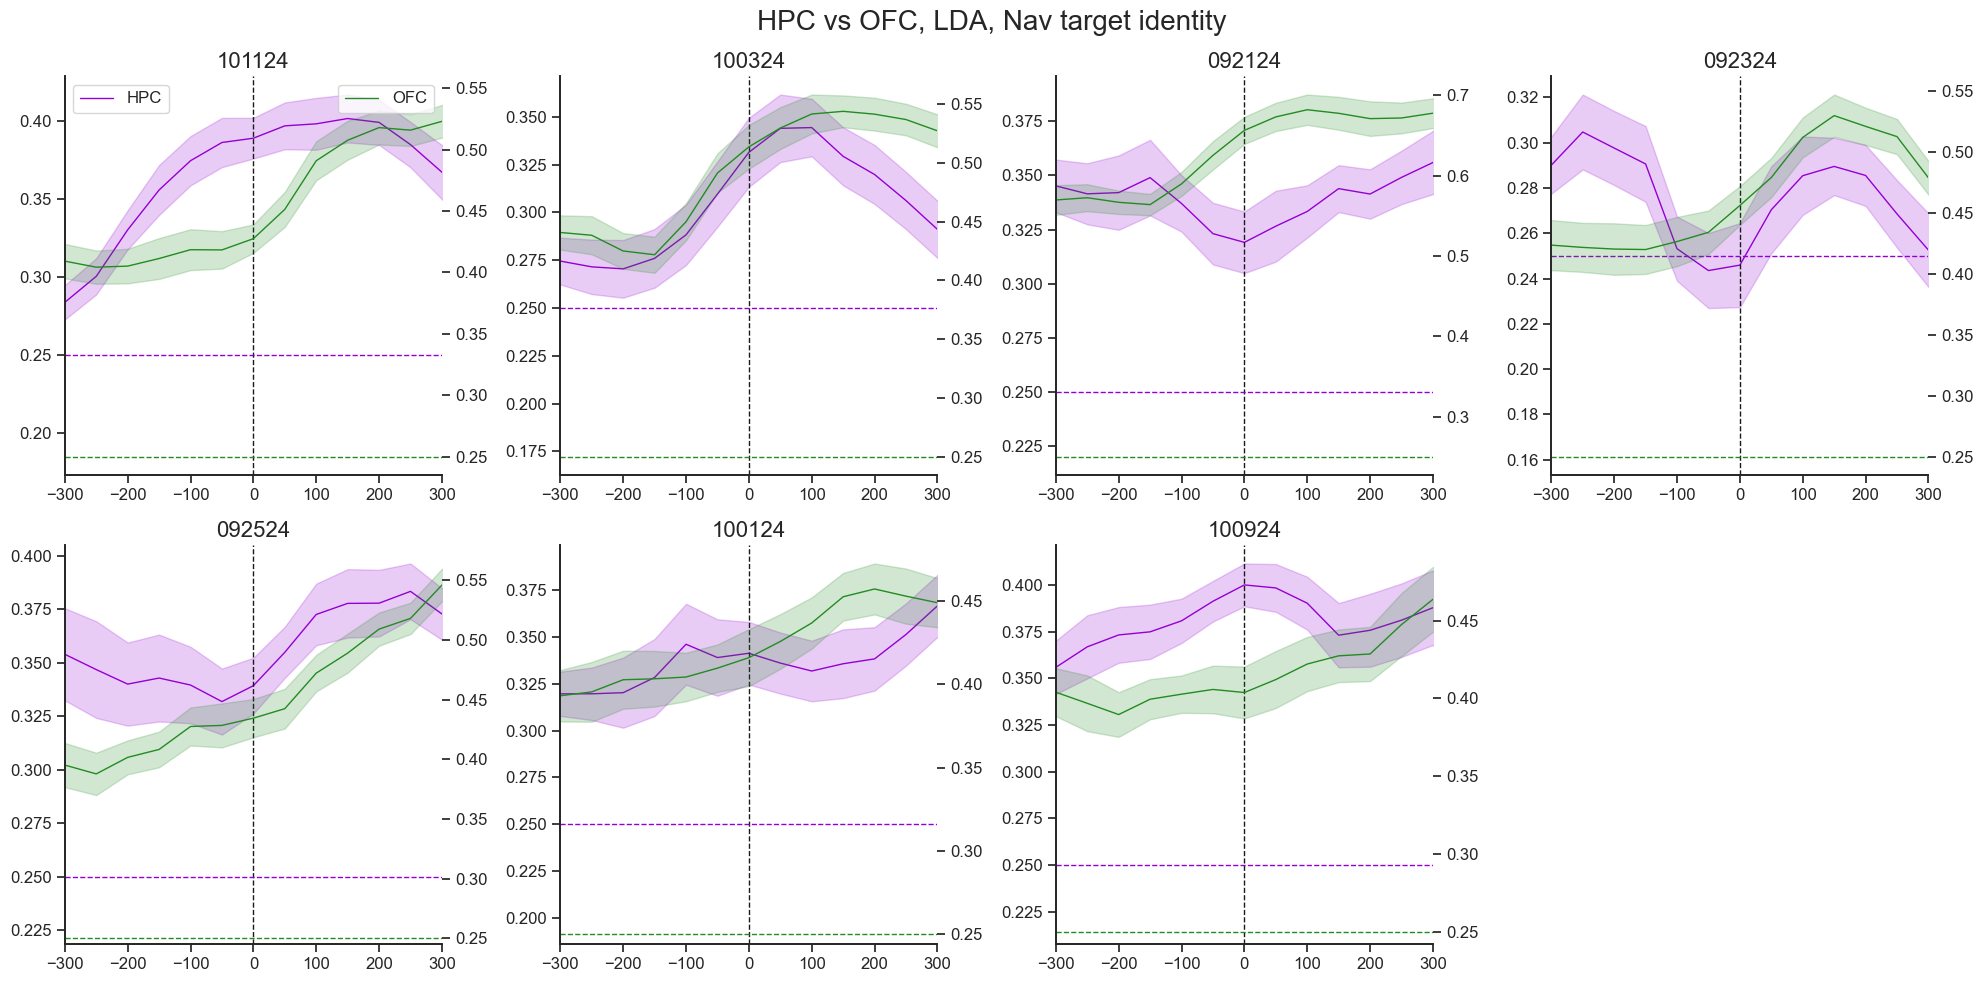

In [44]:
w=100
slide=50
timestamps = np.arange(w,1000-w+slide,slide)
Sessions = ['101124','100324','092124','092324','092524','100124','100924']

plt.close('all')
fig, axes = plt.subplots(2,4,figsize=(20,10))

for ss in range(7):

    ax = axes[np.divmod(ss,4)]
    ax2 = ax.twinx()   # twin axis on the right side

    # --- HPC (left y-axis) ---
    node_acc = chosen_accuracy_all0[ss]
    mean = np.convolve(node_acc.mean(axis=0), np.ones(3)/3, 'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]), np.ones(3)/3, 'same')

    ax.plot(timestamps-500, mean, color='darkviolet', lw=1, label='HPC')
    ax.fill_between(timestamps-500, mean-sem, mean+sem, color='darkviolet', alpha=0.2)

    # --- OFC (right y-axis) ---
    node_acc = chosen_accuracy_all1[ss]
    mean = np.convolve(node_acc.mean(axis=0), np.ones(3)/3, 'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]), np.ones(3)/3, 'same')

    ax2.plot(timestamps-500, mean, color='forestgreen', lw=1, label='OFC')
    ax2.fill_between(timestamps-500, mean-sem, mean+sem, color='forestgreen', alpha=0.2)

    # Formatting
    ax.axvline(c='k', ls='--')
    ax.axhline(0.25, c='darkviolet', ls='--')
    ax2.axhline(0.25, c='forestgreen', ls='--')
    # ax.set_ylim(0.1, 0.75)
    # ax2.set_ylim(0.1, 0.75)  # match ranges if you want

    ax.set_xlim(-300, 300)
    ax.set_title(Sessions[ss], fontsize=16)

    if ss==0:
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

axes[1,3].set_visible(False)
plt.suptitle('HPC vs OFC, LDA, Nav target identity', fontsize=20)
plt.tight_layout()
plt.savefig('HPC vs OFC, LDA, Nav target identity, London, twiny')


In [ ]:
w=100
slide=50
timestamps = np.arange(w,1000-w+slide,slide)
Sessions = choice_df.Session.unique()
colors = ['darkviolet','forestgreen']

plt.close('all')
fig, axes = plt.subplots(4,2,figsize=(10,20))

for ss in range(7):

    for ii in range(2):
        # --- Left column (chosen_prob) ---
        idx = np.repeat(np.arange(2),1000) == ii
        node_acc = chosen_prob_all[ss][:,:,idx,ii].mean(axis=2)
        
        mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
        sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
        
        axes[np.divmod(ss,2)].plot(timestamps-500,mean,color=colors[ii],lw=1,label='first step')
        axes[np.divmod(ss,2)].fill_between(timestamps-500,mean-sem,mean+sem,color=colors[ii],alpha=0.2)
    
    axes[np.divmod(ss,2)].axvline(c='k',ls='--')
    axes[np.divmod(ss,2)].axhline(0.5,c='k',ls='--')
    axes[np.divmod(ss,2)].set_ylim(0.2,0.48)
    axes[np.divmod(ss,2)].set_xlim(-300,300)
    axes[np.divmod(ss,2)].set_title(Sessions[ss])

# plt.suptitle('Node 15, binary, SVC, London')
# plt.savefig('Node 15, binary, SVC, London')

In [ ]:
choice_df.groupby(['target','use_tele']).count()

In [ ]:
def decode_teleport(tele, rep = 2, ntrials = 1000, w = 100, slide = 50):

    # decode teleport choice fixations
    # 0923 node 15
    # 1009 node 15
    
    
    # 5-fold, 16 way classification, logistic
    
    timestamps = np.arange(w,1000-w+slide,slide)
    kf = KFold(n_splits=10, shuffle=True)
    clf = LinearDiscriminantAnalysis() 
    # clf = SVC(kernel='linear',probability=True)
    
    chosen_accuracy_all = []
    chosen_prob_all = []
    # fix_accuracy_all = []
    # fix_prob_all = []
    
    for ss, date in enumerate(choice_df.Session.unique()):
    
        print(ss,date)
    
        df = choice_df.query('Session==@date').copy()
        FR = choice_spikes[ss]

        idx = df.target==14
        df = df.loc[idx]
        FR = FR[idx,:]
        
        FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
             np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
        df['Neural']=list(FR)
        
        
        # fix_ses = fix_df.query('Session==@date').copy()
        # idx = fix_ses.planning.values & (np.isnan(fix_spikes[ss]).sum(axis=(1,2))==0)
        # fix_ses = fix_ses.loc[idx,:]
        
        # fix_FR = fix_spikes[ss][idx,:,:]
        # fix_FR = (fix_FR-np.tile(fix_FR.mean(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1)))/ \
        #      np.tile(fix_FR.std(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1))
        # fix_ses['Neural']=list(fix_FR)

        
        chosen_accuracy = np.zeros((rep,len(timestamps)))
        chosen_prob = np.zeros((rep,len(timestamps),2*ntrials,2))
        # fix_accuracy = np.zeros((rep,len(timestamps)))
        # fix_prob = np.zeros((rep,len(timestamps),len(fix_ses),16))
        
        for rr in tqdm(range(rep)):

            train_all = np.zeros((2,ntrials,FR.shape[1],FR.shape[2]+1))
            test_all = np.zeros((2,ntrials,FR.shape[1],FR.shape[2]+1))
                
            for ii, conditioned_beh in enumerate([df[df.node==tele],df[df.node!=tele]]):

                trialNum = np.array(conditioned_beh.index)
                train_ind, test_ind = list(kf.split(trialNum))[0]
                
                train_set = conditioned_beh.iloc[train_ind]
                index = np.random.randint(len(train_set),size=ntrials)
                train_all[ii,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
                train_all[ii,:,:,-1] = ii
        
                test_set = conditioned_beh.iloc[test_ind]
                index = np.random.randint(len(test_set),size=ntrials)
                test_all[ii,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
                test_all[ii,:,:,-1] = ii

            train = train_all[:,:,500:800,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
            clf.fit(train[:,:-1],train[:,-1])      
            
            for ii,t in enumerate(timestamps): 
                
                test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                chosen_accuracy[rr,ii] = clf.score(test[:,:-1],test[:,-1])
                chosen_prob[rr,ii,:,:] = clf.predict_proba(test[:,:-1])
            
                # fix_pred = clf.predict(fix_FR[:,t-w:t+w,:].mean(axis=1))
                # fix_accuracy[rr,ii] = clf.score(fix_FR[:,t-w:t+w,:].mean(axis=1),fix_ses.node.values)
                # fix_prob[rr,ii,:,:] = clf.predict_proba(fix_FR[:,t-w:t+w,:].mean(axis=1))
    
        chosen_accuracy_all.append(chosen_accuracy)
        chosen_prob_all.append(chosen_prob)
        # fix_accuracy_all.append(fix_accuracy)
        # fix_prob_all.append(fix_prob)

    # Create a Python object
    # data = [chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all]
        
    # if isinstance(train_ts,list):
    #     fn = 'Tele, Train on %s, at %i %i, %s step, Session %s' % (choice_or_plan, train_ts[0], train_ts[1], which_step, date)
    # else:
    #     fn = 'Tele, Train on %s, at each timestamp, %s step, Session %s' % (choice_or_plan, which_step, date)

    # # Pickling the object to a file
    # with open(fn, 'wb') as f:
    #     pickle.dump(data, f)
            
    return chosen_accuracy_all, chosen_prob_all #, fix_accuracy_all, fix_prob_all

In [42]:
def decode_istarget(df, spikes, clf, time=, rep = 2, ntrials = 2000, w = 100, slide = 50):

    # decode teleport choice fixations
    # 0923 node 15
    # 1009 node 15
    
    # 5-fold, 16 way classification, logistic
    choice_df = df.copy()
    choice_spikes = spikes.copy()
    
    timestamps = np.arange(w,1000-w+slide,slide)
    kf = KFold(n_splits=10, shuffle=True)
    # clf = SVC(kernel='linear',probability=True)
    
    chosen_accuracy_all = []
    chosen_prob_all = []
    # fix_accuracy_all = []
    # fix_prob_all = []
    
    for ss, date in enumerate(choice_df.Session.unique()):
    
        print(ss,date)
    
        df = choice_df.query('Session==@date').copy()
        FR = choice_spikes[ss]
        
        FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
             np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
        df['Neural']=list(FR)
        
        
        # fix_ses = fix_df.query('Session==@date').copy()
        # idx = fix_ses.planning.values & (np.isnan(fix_spikes[ss]).sum(axis=(1,2))==0)
        # fix_ses = fix_ses.loc[idx,:]
        
        # fix_FR = fix_spikes[ss][idx,:,:]
        # fix_FR = (fix_FR-np.tile(fix_FR.mean(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1)))/ \
        #      np.tile(fix_FR.std(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1))
        # fix_ses['Neural']=list(fix_FR)

        
        chosen_accuracy = np.zeros((rep,len(timestamps)))
        # chosen_prob = np.zeros((rep,len(timestamps),2*ntrials,2))
        # fix_accuracy = np.zeros((rep,len(timestamps)))
        # fix_prob = np.zeros((rep,len(timestamps),len(fix_ses),16))
        
        for rr in tqdm(range(rep)):

            train_all = np.zeros((2,ntrials,FR.shape[1],FR.shape[2]+1))
            test_all = np.zeros((2,ntrials,FR.shape[1],FR.shape[2]+1))
                
            for ii, conditioned_beh in enumerate([df[df.istarget],df[~df.istarget]]):

                trialNum = np.array(conditioned_beh.index)
                train_ind, test_ind = list(kf.split(trialNum))[0]
                
                train_set = conditioned_beh.iloc[train_ind]
                index = np.random.randint(len(train_set),size=ntrials)
                train_all[ii,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
                train_all[ii,:,:,-1] = ii
        
                test_set = conditioned_beh.iloc[test_ind]
                index = np.random.randint(len(test_set),size=ntrials)
                test_all[ii,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
                test_all[ii,:,:,-1] = ii

            train = train_all[:,:,500:800,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
            clf.fit(train[:,:-1],train[:,-1])      
            
            for ii,t in enumerate(timestamps): 
                
                test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                chosen_accuracy[rr,ii] = clf.score(test[:,:-1],test[:,-1])
                # chosen_prob[rr,ii,:,:] = clf.predict_proba(test[:,:-1])
            
                # fix_pred = clf.predict(fix_FR[:,t-w:t+w,:].mean(axis=1))
                # fix_accuracy[rr,ii] = clf.score(fix_FR[:,t-w:t+w,:].mean(axis=1),fix_ses.node.values)
                # fix_prob[rr,ii,:,:] = clf.predict_proba(fix_FR[:,t-w:t+w,:].mean(axis=1))
    
        chosen_accuracy_all.append(chosen_accuracy)
        # chosen_prob_all.append(chosen_prob)
        # fix_accuracy_all.append(fix_accuracy)
        # fix_prob_all.append(fix_prob)

    # Create a Python object
    # data = [chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all]
        
    # if isinstance(train_ts,list):
    #     fn = 'Tele, Train on %s, at %i %i, %s step, Session %s' % (choice_or_plan, train_ts[0], train_ts[1], which_step, date)
    # else:
    #     fn = 'Tele, Train on %s, at each timestamp, %s step, Session %s' % (choice_or_plan, which_step, date)

    # # Pickling the object to a file
    # with open(fn, 'wb') as f:
    #     pickle.dump(data, f)
            
    return chosen_accuracy_all #, chosen_prob_all #, fix_accuracy_all, fix_prob_all

In [10]:
def decode_target(df, spikes, clf, rep = 2, ntrials = 1000, w = 100, slide = 50):

    # decode teleport choice fixations
    # 0923 node 15
    # 1009 node 15
    
    # 5-fold, 16 way classification, logistic

    choice_df = df.copy()
    choice_spikes = spikes.copy()
    
    timestamps = np.arange(w,1000-w+slide,slide)
    kf = KFold(n_splits=10, shuffle=True)
    # clf = SVC(kernel='linear',probability=True)
    
    chosen_accuracy_all = []
    # chosen_prob_all = []
    # fix_accuracy_all = []
    # fix_prob_all = []
    
    for ss, date in enumerate(choice_df.Session.unique()):
    
        print(ss,date)
    
        df = choice_df.query('Session==@date').copy()
        FR = choice_spikes[ss]

        idx = df.istarget
        df = df.loc[idx]
        FR = FR[idx,:]
        
        FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
             np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
        df['Neural']=list(FR)
        
        
        # fix_ses = fix_df.query('Session==@date').copy()
        # idx = fix_ses.planning.values & (np.isnan(fix_spikes[ss]).sum(axis=(1,2))==0)
        # fix_ses = fix_ses.loc[idx,:]
        
        # fix_FR = fix_spikes[ss][idx,:,:]
        # fix_FR = (fix_FR-np.tile(fix_FR.mean(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1)))/ \
        #      np.tile(fix_FR.std(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1))
        # fix_ses['Neural']=list(fix_FR)

        
        chosen_accuracy = np.zeros((rep,len(timestamps)))
        # chosen_prob = np.zeros((rep,len(timestamps),4*ntrials,4))
        # fix_accuracy = np.zeros((rep,len(timestamps)))
        # fix_prob = np.zeros((rep,len(timestamps),len(fix_ses),16))
        
        for rr in tqdm(range(rep)):

            train_all = np.zeros((4,ntrials,FR.shape[1],FR.shape[2]+1))
            test_all = np.zeros((4,ntrials,FR.shape[1],FR.shape[2]+1))
                
            for ii, target in enumerate([1,7,8,14]):

                conditioned_beh = df[df.node==target]
                trialNum = np.array(conditioned_beh.index)
                train_ind, test_ind = list(kf.split(trialNum))[0]
                
                train_set = conditioned_beh.iloc[train_ind]
                index = np.random.randint(len(train_set),size=ntrials)
                train_all[ii,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
                train_all[ii,:,:,-1] = ii
        
                test_set = conditioned_beh.iloc[test_ind]
                index = np.random.randint(len(test_set),size=ntrials)
                test_all[ii,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
                test_all[ii,:,:,-1] = ii

            
            for ii,t in enumerate(timestamps): 

                train = train_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                clf.fit(train[:,:-1],train[:,-1])  
                
                test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                chosen_accuracy[rr,ii] = clf.score(test[:,:-1],test[:,-1])
                # chosen_prob[rr,ii,:,:] = clf.predict_proba(test[:,:-1])
            
                # fix_pred = clf.predict(fix_FR[:,t-w:t+w,:].mean(axis=1))
                # fix_accuracy[rr,ii] = clf.score(fix_FR[:,t-w:t+w,:].mean(axis=1),fix_ses.node.values)
                # fix_prob[rr,ii,:,:] = clf.predict_proba(fix_FR[:,t-w:t+w,:].mean(axis=1))
    
        chosen_accuracy_all.append(chosen_accuracy)
        # chosen_prob_all.append(chosen_prob)
        # fix_accuracy_all.append(fix_accuracy)
        # fix_prob_all.append(fix_prob)

    # Create a Python object
    # data = [chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all]
        
    # if isinstance(train_ts,list):
    #     fn = 'Tele, Train on %s, at %i %i, %s step, Session %s' % (choice_or_plan, train_ts[0], train_ts[1], which_step, date)
    # else:
    #     fn = 'Tele, Train on %s, at each timestamp, %s step, Session %s' % (choice_or_plan, which_step, date)

    # # Pickling the object to a file
    # with open(fn, 'wb') as f:
    #     pickle.dump(data, f)
            
    return chosen_accuracy_all #, chosen_prob_all #, fix_accuracy_all, fix_prob_all

In [90]:
def get_target_clf(df, spikes, clf, trial, ntrials = 1000, w = 100, slide = 50):

    # decode teleport choice fixations
    # 0923 node 15
    # 1009 node 15
    
    choice_df = df.copy()
    choice_spikes = spikes.copy()
    
    timestamps = np.arange(w,1000-w+slide,slide)
    
    # for ss, date in enumerate(choice_df.Session.unique()):
    ss = 0
    date = choice_df.Session.unique()[ss]
    
    print(ss,date)

    df = choice_df.query('Session==@date').copy()
    FR = choice_spikes[ss]

    idx = df.istarget & df.trial!=trial
    df = df.loc[idx]
    FR = FR[idx,:]
    
    FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
         np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    df['Neural']=list(FR)


    train_all = np.zeros((4,ntrials,FR.shape[1],FR.shape[2]+1))
    
    for ii, target in enumerate([1,7,8,14]):
        
        train_set = df[df.node==target]
        index = np.random.randint(len(train_set),size=ntrials)
        train_all[ii,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
        train_all[ii,:,:,-1] = ii


    train = train_all[:,:,400:600,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
    clf.fit(train[:,:-1],train[:,-1])  
            
            
    return clf 

In [ ]:
# Unpickling the object from the file
with open(fn, 'rb') as f:
    chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all = pickle.load(f)

In [ ]:
choice_or_plan = 'choice'
train_ts = [500,800]
which_step = 'first'
fn = 'Train on %s, at %i %i, %s step' % (choice_or_plan, train_ts[0], train_ts[1], which_step)

# Unpickling the object from the file
with open(fn, 'rb') as f:
    choice_first = pickle.load(f)
    

which_step = 'all'
fn = 'Train on %s, at %i %i, %s step' % (choice_or_plan, train_ts[0], train_ts[1], which_step)

# Unpickling the object from the file
with open(fn, 'rb') as f:
    choice_all = pickle.load(f)

In [ ]:
timestamps = np.arange(100,950,50)
dates = ['031723','032823','033123','032023','040423','040723']

for ss, date in enumerate():

    print(ss,date)
    
    plt.close('all')
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    
    # choice fixation accuracy, cross validated
    node_acc = choice_first[0][ss] #.mean(axis=0) #chosen_accuracy
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    
    axes[0].plot(timestamps-500,mean,color='darkviolet',lw=1,label='first step')
    axes[0].fill_between(timestamps-500,mean-sem,mean+sem,color='darkviolet',alpha=0.2)
    axes[0].axvline(c='k',ls='--')
    
    node_acc = choice_all[0][ss]
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    axes[0].plot(timestamps-500,mean,color='forestgreen',lw=1,label='all steps')
    axes[0].fill_between(timestamps-500,mean-sem,mean+sem,color='forestgreen',alpha=0.2)
    axes[0].axhline(y=1/16,c='k',ls='--')
    axes[0].set_ylim(0,0.3)
    axes[0].set_yticks(np.arange(0,0.3,0.05))
    axes[0].set_title('Choice fixations')
    
    
    # planning fixation accuracy
    node_acc = choice_first[2][ss] #.mean(axis=0) #chosen_accuracy
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    
    axes[1].plot(timestamps-500,mean,color='darkviolet',lw=1,label='first step')
    axes[1].fill_between(timestamps-500,mean-sem,mean+sem,color='darkviolet',alpha=0.2)
    axes[1].axvline(c='k',ls='--')
    
    node_acc = choice_all[2][ss]
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    axes[1].plot(timestamps-500,mean,color='forestgreen',lw=1,label='all steps')
    axes[1].fill_between(timestamps-500,mean-sem,mean+sem,color='forestgreen',alpha=0.2)
    axes[1].axhline(y=1/16,c='k',ls='--')
    axes[1].set_ylim(0,0.3)
    axes[1].set_yticks(np.arange(0,0.3,0.05))
    axes[1].legend()
    axes[1].set_title('Planning fixations')
    
    
    title = 'Session %s\nDecoder trained on first step v.s. all steps' % date
    plt.suptitle(title)
    plt.tight_layout(rect=[0,0,0.9,0.95])
    
    title = 'Train on %s, at %i %i, all vs first, Session %s' % (choice_or_plan, train_ts[0], train_ts[1], date)
    plt.savefig(title)

In [ ]:
for choice_or_plan in ['planning']:
    for which_step in ['all','first']:
        for train_ts in ['each',[500,800]]:
            chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all = run_logistic_regression(choice_or_plan, which_step, train_ts, rep=10)
            plot_decoding_accuracy(choice_or_plan, which_step, train_ts, chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all)

In [ ]:
choice_or_plan = 'choice'
which_step = 'all'
train_ts=[500,800]
chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all = run_logistic_regression(choice_or_plan, which_step, train_ts, rep=10)
plot_decoding_accuracy(choice_or_plan, which_step, train_ts, chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all)

In [ ]:
def run_logistic_regression(choice_or_plan, which_step, train_ts, rep = 2, ntrials = 200, w = 100, slide = 50):
    
    # 5-fold, 16 way classification, logistic
    
    timestamps = np.arange(w,1000-w+slide,slide)
    kf = KFold(n_splits=3, shuffle=True)
    clf = LogisticRegression(multi_class='multinomial',random_state=0)
    
    chosen_accuracy_all = []
    chosen_prob_all = []
    fix_accuracy_all = []
    fix_prob_all = []
    
    dates = ['101124','100324','092124','092324','092524','100124','100924']
    # ['031723','032823','033123','032023','040423','040723']

    for ss, date in enumerate(dates):
    
        print(ss,date)
    
        if choice_or_plan=='choice':
            df = choice_df.query('Session==@date').copy()
            FR = choice_spikes[ss]
    
            if which_step=='first':
                idx = df.step==0   # only train on the first step
                df = df.loc[idx,:]
                FR = FR[idx,:,:]
            
            FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
                 np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
            df['Neural']=list(FR)
        
        
        fix_ses = fix_df.query('Session==@date').copy()
        idx = fix_ses.planning.values & (np.isnan(fix_spikes[ss]).sum(axis=(1,2))==0)
        fix_ses = fix_ses.loc[idx,:]
        
        fix_FR = fix_spikes[ss][idx,:,:]
        fix_FR = (fix_FR-np.tile(fix_FR.mean(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1)))/ \
             np.tile(fix_FR.std(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1))
        fix_ses['Neural']=list(fix_FR)

        if choice_or_plan=='planning':
            FR = fix_FR.copy()
        
        chosen_accuracy = np.zeros((rep,len(timestamps)))
        chosen_prob = np.zeros((rep,len(timestamps),16*ntrials,16))
        fix_accuracy = np.zeros((rep,len(timestamps)))
        fix_prob = np.zeros((rep,len(timestamps),len(fix_ses),16))
        
        for rr in tqdm(range(rep)):

            train_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
            test_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
                
            for node in range(16):

                if choice_or_plan=='choice':
                    conditioned_beh = df[df.node==node]  # construct training sets from choice fixations
                if choice_or_plan=='planning':
                    conditioned_beh = fix_ses[fix_ses.node==node] # construct training sets from planning fixations
                    
                trialNum = np.array(conditioned_beh.index)
                train_ind, test_ind = list(kf.split(trialNum))[0]
                
                train_set = conditioned_beh.iloc[train_ind]
                index = np.random.randint(len(train_set),size=ntrials)
                train_all[node,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
                train_all[node,:,:,-1] = node
        
                test_set = conditioned_beh.iloc[test_ind]
                index = np.random.randint(len(test_set),size=ntrials)
                test_all[node,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
                test_all[node,:,:,-1] = node

            if isinstance(train_ts,list):
                train = train_all[:,:,train_ts[0]:train_ts[1],:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                clf.fit(train[:,:-1],train[:,-1])      
            
            for ii,t in enumerate(timestamps): 

                if train_ts=='each':
                    train = train_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                    clf.fit(train[:,:-1],train[:,-1])
                
                test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                chosen_accuracy[rr,ii] = clf.score(test[:,:-1],test[:,-1])
                chosen_prob[rr,ii,:,:] = clf.predict_proba(test[:,:-1])
            
                fix_pred = clf.predict(fix_FR[:,t-w:t+w,:].mean(axis=1))
                fix_accuracy[rr,ii] = clf.score(fix_FR[:,t-w:t+w,:].mean(axis=1),fix_ses.node.values)
                fix_prob[rr,ii,:,:] = clf.predict_proba(fix_FR[:,t-w:t+w,:].mean(axis=1))
    
        chosen_accuracy_all.append(chosen_accuracy)
        chosen_prob_all.append(chosen_prob)
        fix_accuracy_all.append(fix_accuracy)
        fix_prob_all.append(fix_prob)

    # Create a Python object
    data = [chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all]
        
    if isinstance(train_ts,list):
        fn = 'Train on %s, at %i %i, %s step, Session %s' % (choice_or_plan, train_ts[0], train_ts[1], which_step, date)
    else:
        fn = 'Train on %s, at each timestamp, %s step, Session %s' % (choice_or_plan, which_step, date)

    # Pickling the object to a file
    with open(fn, 'wb') as f:
        pickle.dump(data, f)
            
    return chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all

In [ ]:
def plot_decoding_accuracy(choice_or_plan, which_step, train_ts, chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all):

    w = 100
    slide = 50
    timestamps = np.arange(w,1000-w+slide,slide)
    #['031723','032823','033123','032023','040423','040723']
    dates = ['101124','100324','092124','092324','092524','100124','100924']
    
    for ss, date in enumerate(dates):
        
        node_acc = chosen_accuracy_all[ss] #.mean(axis=0) #chosen_accuracy
        mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
        sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
        
        plt.close('all')
        plt.plot(timestamps-500,mean,color='darkviolet',lw=1,label='choice')
        plt.fill_between(timestamps-500,mean-sem,mean+sem,color='darkviolet',alpha=0.2)
        plt.axvline(c='k',ls='--')
        
        node_acc = fix_accuracy_all[ss]
        mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
        sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
        plt.plot(timestamps-500,mean,color='forestgreen',lw=1,label='planning')
        plt.fill_between(timestamps-500,mean-sem,mean+sem,color='forestgreen',alpha=0.2)
        
        plt.axhline(y=1/16,c='k',ls='--')
        # plt.ylim(0.05,0.9)
        # plt.yticks(np.arange(0.25,1,0.25))
        plt.legend()

        if isinstance(train_ts,list):
            title = 'Train on %s, at %i %i, %s step, Session %s' % (choice_or_plan, train_ts[0], train_ts[1], which_step, date)
        else:
            title = 'Train on %s, at each timestamp, %s step, Session %s' % (choice_or_plan, which_step, date)
        
        plt.title(title)
        plt.savefig(title)
        

        # plt.close('all')
        # fig, axes = plt.subplots(16, 2, figsize=(12, 96), sharex=True, sharey=True)
        # colors16 = [
        #     "#1f77b4","#ff7f0e","#2ca02c","#d62728",
        #     "#9467bd","#8c564b","#e377c2","#7f7f7f",
        #     "#bcbd22","#17becf","#a55194","#393b79",
        #     "#637939","#8c6d31","#843c39","#cedb9c"
        # ]
    
        # fix_ses = fix_df.query('Session==@date').copy()
        # idx = fix_ses.planning.values & (np.isnan(fix_spikes[ss]).sum(axis=(1,2))==0)
        # fix_ses = fix_ses.loc[idx,:]
        
        # for ii in range(16):
        #     # --- Left column (chosen_prob) ---
        #     idx = test[:, -1] == ii
        #     node_acc = chosen_prob_all[ss][:, :, idx, :].mean(axis=(0, 2))
        #     for jj in range(node_acc.shape[1]):  # loop over lines
        #         axes[ii, 0].plot(timestamps-500,node_acc[:,jj], color=colors16[jj], label=f"{jj}")
                
        #     axes[ii, 0].set_title(f"Planning: Node {ii}")
        #     axes[ii, 0].legend(labels=np.arange(node_acc.shape[0]), loc=(1.02,0.1))
        
        #     # --- Right column (fix_prob) ---
        #     idx = fix_ses.node.values == ii
        #     node_acc = fix_prob_all[ss][:, :, idx, :].mean(axis=(0, 2))
        #     for jj in range(node_acc.shape[1]):  # loop over lines
        #         axes[ii, 1].plot(timestamps-500,node_acc[:,jj], color=colors16[jj])
        #     axes[ii, 1].set_title(f"Planning: Node {ii}")
        
        # if isinstance(train_ts,list):
        #     title = 'Train on %s, at %i %i, %s step, Session %s, node-wise' % (choice_or_plan, train_ts[0], train_ts[1], which_step, date)
        # else:
        #     title = 'Train on %s, at each timestamp, %s step, Session %s, node-wise' % (choice_or_plan, which_step, date)
        
        # plt.suptitle(title)
        # plt.savefig(title)

In [77]:
os.chdir('D:/')
session = '031723'
filename = "Bart_TeleWorld_v13_%s.nwb" % session  # Replace with your NWB file path
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 
trial_df = nwbfile.trials.to_dataframe()

In [94]:
node_df = nwbfile.intervals['node_on'].to_dataframe()

In [98]:
node_df

start_time  stop_time  trial  step  trialerror  nsteps  start  target  \
id                                                                            
0        20456.0    21456.0      0     0         1.0     0.0    7.0     7.0   
1        24071.0    25071.0      1     0         1.0     0.0    7.0     7.0   
2        28170.0    29170.0      2     0         0.0     3.0    9.0     7.0   
3        29336.0    30336.0      2     1         0.0     3.0    9.0     7.0   
4        30269.0    31269.0      2     2         0.0     3.0    9.0     7.0   
...          ...        ...    ...   ...         ...     ...    ...     ...   
1722   5361319.0  5362319.0   1053     0         0.0     2.0   10.0     8.0   
1723   5362535.0  5363535.0   1053     1         0.0     2.0   10.0     8.0   
1724   5363584.0  5364584.0   1053     2         0.0     2.0   10.0     8.0   
1725   5366967.0  5367967.0   1054     0         1.0     0.0   14.0    14.0   
1726   5370382.0  5371382.0   1055     0         1.0     0.0   14.0    14.0   

      block  blocktrialnumber  node     t_on  graph_distance  \
id                                                             
0       1.0               1.0     7    20956               0   
1       1.0               2.0     7    24571               0   
2       1.0               3.0     9    28670               3   
3       1.0               3.0    10    29836               2   
4       1.0               3.0    11    30769               1   
...     ...               ...   ...      ...             ...   
1722  146.0               8.0    10  5361819               2   
1723  146.0               8.0     9  5363035               1   
1724  146.0               8.0     8  5364084               0   
1725  147.0               1.0    14  5367467               0   
1726  147.0               2.0    14  5370882               0   

      spatial_distance  window_size      nodes  \
id                                               
0                    0          500          7   
1                    0          500          7   
2                    3          500  9,10,11,7   
3                    2          500  9,10,11,7   
4                    1          500  9,10,11,7   
...                ...          ...        ...   
1722                 2          500     10,9,8   
1723                 1          500     10,9,8   
1724                 0          500     10,9,8   
1725                 0          500         14   
1726                 0          500         14   

                                             timeseries  
id                                                       
0     [(20456, 1000, neural pynwb.base.TimeSeries at...  
1     [(24071, 1000, neural pynwb.base.TimeSeries at...  
2     [(28170, 1000, neural pynwb.base.TimeSeries at...  
3     [(29336, 1000, neural pynwb.base.TimeSeries at...  
4     [(30269, 1000, neural pynwb.base.TimeSeries at...  
...                                                 ...  
1722  [(5361319, 1000, neural pynwb.base.TimeSeries ...  
1723  [(5362535, 1000, neural pynwb.base.TimeSeries ...  
1724  [(5363584, 1000, neural pynwb.base.TimeSeries ...  
1725  [(5366967, 1000, neural pynwb.base.TimeSeries ...  
1726  [(5370382, 1000, neural pynwb.base.TimeSeries ...  

[1727 rows x 17 columns]

In [97]:
node_df.start_time[0]+500

np.float64(20956.0)

In [83]:
eventcodes = trial_df.iloc[0].timeseries[1]

In [99]:
idx = eventcodes.data==30

In [101]:
eventcodes.timestamps

array([20277., 20307., 20314., 20488., 20495., 20911., 20940., 20956.,
       21176., 21478., 21478., 21807., 22359., 22389., 22394.])

In [ ]:
# session = '031723'
# filename = "Bart_TeleWorld_v13_%s.nwb" % session  # Replace with your NWB file path
# nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 
# trial_df = nwbfile.trials.to_dataframe()
# choice_spikes, choice_df, _ = get_spike_table(nwbfile, 'HPC', 'action_on', query = 'trialerror==0', window_size = 0)

# fix_df = nwbfile.intervals["fixations"].to_dataframe().query("duration>50")
# fix_df['planning'] = (fix_df.duration<300) & (fix_df.active_prob<0.2)
# fix_df['choice'] = (fix_df.duration>300) & (fix_df.active_prob>0.2)
# fix_df = fix_df.query("planning | choice")
# trial_cand = fix_df.query('fix_node==0').trial.unique()

# get good units
unitNames = nwbfile.units.to_dataframe()
unit_params = {"drift": 2, "min_fr": 1}
unit_idx = np.where((unitNames.region == 'HPC') & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    


In [ ]:
chosen_accuracy = np.zeros(len(timestamps)) 
chosen_prob = np.zeros((len(timestamps),16*ntrials,16))

for ii, tt in enumerate(timestamps):
    test = train_all[:,:,tt-w:tt+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)                
    chosen_accuracy[ii] = clf.score(test[:,:-1],test[:,-1])
    chosen_prob[ii,:,:] = clf.predict_proba(test[:,:-1])

In [ ]:
# plot prediction probability

ss=0
date='031723'
timestamps=np.arange(100,950,50)

plt.close('all')
fig, axes = plt.subplots(16, 2, figsize=(12, 96), sharex=True, sharey=True)
colors16 = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728",
    "#9467bd","#8c564b","#e377c2","#7f7f7f",
    "#bcbd22","#17becf","#a55194","#393b79",
    "#637939","#8c6d31","#843c39","#cedb9c"
]


for ii in range(16):
    # --- Left column (chosen_prob) ---
    idx = np.repeat(np.arange(16),200) == ii
    node_acc = chosen_prob [:, idx, :].mean(axis=1)
    for jj in range(node_acc.shape[1]):  # loop over lines
        axes[ii, 0].plot(timestamps-500,node_acc[:,jj], color=colors16[jj], label=f"{jj}")
        
    axes[ii, 0].set_title(f"Choice: Node {ii}")
    axes[ii, 0].legend(labels=np.arange(node_acc.shape[0]), loc=(0.95,0.1))

# plt.suptitle(title)
# plt.savefig(title)

In [ ]:
df = choice_df[idx].copy()
FR = choice_spikes[idx,:,:].copy()

train_ts=[500,800]
ntrials = 200
w = 100
slide = 50

# decode single trial dynamics, therefore training the decoder on all the other trials
timestamps = np.arange(w,1000-w+slide,slide)
clf = LogisticRegression(multi_class='multinomial',random_state=0)

FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
     np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
df['Neural']=list(FR)

train_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
test_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
    
for node in range(16):
    
    train_set = df[df.node==node]
    index = np.random.randint(len(train_set),size=ntrials)
    train_all[node,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
    train_all[node,:,:,-1] = node


train = train_all[:,:,train_ts[0]:train_ts[1],:].mean(axis=2).reshape(-1,FR.shape[2]+1)
clf.fit(train[:,:-1],train[:,-1]) 

In [ ]:
def leave_one_trial_out(df, FR, mode='node', ntrials = 200, w = 100, slide = 50):
    
    # decode single trial dynamics, therefore training the decoder on all the other trials
    timestamps = np.arange(w,1000-w+slide,slide)
    clf = SVC(kernel='linear',probability=True) #LogisticRegression(multi_class='multinomial',random_state=0)
 
    FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
         np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    df['Neural']=list(FR)

    if mode=='node':
        train_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
            
        for node in range(16):
            
            train_set = df[df.node==node]
            index = np.random.randint(len(train_set),size=ntrials)
            train_all[node,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
            train_all[node,:,:,-1] = node

    if mode=='tele':
        
        train_all = np.zeros((2,ntrials,FR.shape[1],FR.shape[2]+1))
            
        for ii,train_set in enumerate([df[df.node==15],df[df.node!=15]]):
            
            index = np.random.randint(len(train_set),size=ntrials)
            train_all[ii,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
            train_all[ii,:,:,-1] = ii
    
    train = train_all[:,:,500:800,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
    clf.fit(train[:,:-1],train[:,-1])      
        
    return clf

In [ ]:
# w=100
# node=15
# filename = DATA_DIR/"London_TeleWorld_4x4_100924_spikes.nwb/"
# # filename = "Bart_TeleWorld_v13_031723.nwb"  # Replace with your NWB file path
# nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 
# choice_spikes, choice_df,  _ = get_spike_table(nwbfile, 'HPC', 'action_on', query = 'trialerror==0', window_size = 0)

# trial_df = nwbfile.trials.to_dataframe()
# fix_df = nwbfile.intervals["fixations"].to_dataframe().query("duration>50")
# fix_df['planning'] = (fix_df.duration<300) & (fix_df.active_prob<0.2)
# fix_df['choice'] = (fix_df.duration>300) & (fix_df.active_prob>0.2)
# fix_df = fix_df.query("planning | choice")
# trial_cand = fix_df.query('fix_node==@node').trial.unique()

# # get good units
# unitNames = nwbfile.units.to_dataframe()
# unit_params = {"drift": 2, "min_fr": 1}
# unit_idx = np.where((unitNames.region == 'HPC') & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]

for trial in [trial_cand[0]]:

    idx = choice_df.trial!=trial
    decoder = leave_one_trial_out(choice_df[idx].copy(), choice_spikes[idx,:,:],mode='tele')
    plot_eye_tele_decoder(trial_df,fix_df,unit_idx,trial,node,decoder)

In [ ]:
def plot_eye_tele_decoder(trial_df,fix_df,unit_idx,trial,node,decoder):
    # train decoder on choice fixations
    
    # get spikes between trial onset to 1st action onset 
    w=100
    eye_idx = 2
    neural_idx = 0
    
    # pull trial for a single trial
    # plot eye trace in 4*4 grid
    eyes = trial_df[trial_df.trial==trial].timeseries.iloc[0][eye_idx]
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    trial_on = trial_df[trial_df.trial==trial].start_time.values[0]
    
    fixations_during_trial = fix_df.query("trial == @ trial")
    
    node_df = nwbfile.intervals["node_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    node_on = node_df.t_on.values[0]-trial_on
    action_df = nwbfile.intervals["action_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    action_on = action_df.t_on.values[0]-trial_on
        
    color_seq = sns.color_palette('Set1',len(fixations_during_trial))
    
    plt.close('all')
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(nrows=3, ncols=3)
    ax=fig.add_subplot(gs[0,2])
    ax.plot(eyes.data[:, 0], eyes.data[:, 1], alpha=0.5, c="k", lw=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
        
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        if fix.planning:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=2)
        if fix.choice:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=4)
    
        ii=ii+1
    
    
    ax.set_ylim([-12, 12])
    ax.set_xlim([-12, 12])
    ax.set_title("Fixations during trial %i" % trial)
    
    # sns.despine(bottom=False,left=False)
    
    # plot eyetracking data separately for x, y, for alignment with neural data visualization
    ax = fig.add_subplot(gs[0,:2])
    ax.plot(eyes.timestamps-trial_on, eyes.data)
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
            
        if fix.planning:
            ax.plot(eyes.timestamps[idx]-trial_on,fixation_trace, c='k', ls='-',lw=2)
            
        ii=ii+1
    
    ax.set_ylabel("Eyes (DV)")
    ax.set_ylim([-12, 12])
    
    
    # plot spike raster
    FR = spikes.data[:, unit_idx]
    ax = fig.add_subplot(gs[1,:2])
    X, Y = np.where(FR)
    X = (X + spikes.timestamps[0]-trial_on)
    ax.scatter(X, Y, marker = "|", c="k", s=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
       
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1,label=f"Node {fix.fix_node}")
    
        ii=ii+1

    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Neuron #")
    # ax.set_xlabel("Time in session (ms)")
    ax.legend(loc=(1.1,0.3))
    sns.despine()
    

    # plot predicted probability for node of interest only
    timestamps = np.arange(100,FR.shape[0]-100+50,50)
    planning = np.zeros((len(timestamps),2))
    
    for ii,t in enumerate(timestamps): 
    
        planning[ii,:] = decoder.predict_proba(FR[t-w:t+w,:].mean(axis=0, keepdims=True))
            
    
    colors16 = [
        "#1f77b4","r","#2ca02c","#d62728",
        "#9467bd","#8c564b","#e377c2","#7f7f7f",
        "#bcbd22","#17becf","#a55194","#393b79",
        "#637939","#8c6d31","#843c39","coral"
    ]
    
    # plot predicted probability for all nodes
    ax = fig.add_subplot(gs[2,:2])
    for ii in range(2):
        ax.plot(timestamps,planning[:,ii],color=colors16[ii],label=f"Node {ii}")
        ax.axhline(1/16,color='k',ls='--')
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
    
        ii=ii+1

    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    #ax.set_ylim(1/16-0.04,1/16+0.04)
    # ax.set_ylim(0,0.15)
    ax.set_ylabel("Predicted prob")
    ax.set_xlabel("Time in session (ms)")
    ax.legend(ncols=2,loc=(1.1,0.8))
    sns.despine()

    plt.suptitle('Fixation trial decoding trial %i, node 15, session 100124' % (trial))
    plt.savefig('Fixation trial decoding trial %i, node 15, session 100124' % (trial))


In [ ]:
def plot_eye_decoder(trial_df,fix_df,unit_idx,trial,node,decoder):
    # train decoder on choice fixations
    
    # get spikes between trial onset to 1st action onset 
    w=100
    eye_idx = 2
    neural_idx = 0
    
    # pull trial for a single trial
    # plot eye trace in 4*4 grid
    eyes = trial_df[trial_df.trial==trial].timeseries.iloc[0][eye_idx]
    spikes = trial_df[trial_df.trial==trial].timeseries.iloc[0][neural_idx]
    trial_on = trial_df[trial_df.trial==trial].start_time.values[0]
    
    fixations_during_trial = fix_df.query("trial == @ trial")
    
    node_df = nwbfile.intervals["node_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    node_on = node_df.t_on.values[0]-trial_on
    action_df = nwbfile.intervals["action_on"].to_dataframe().query("(trial == @ trial) & (step==0)")
    action_on = action_df.t_on.values[0]-trial_on
        
    color_seq = sns.color_palette('Set1',len(fixations_during_trial))
    
    plt.close('all')
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(nrows=4, ncols=3)
    ax=fig.add_subplot(gs[0,2])
    ax.plot(eyes.data[:, 0], eyes.data[:, 1], alpha=0.5, c="k", lw=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
        
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        if fix.planning:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=2)
        if fix.choice:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=4)
    
        ii=ii+1
    
    
    ax.set_ylim([-12, 12])
    ax.set_xlim([-12, 12])
    ax.set_title("Fixations during trial %i" % trial)
    
    # sns.despine(bottom=False,left=False)
    
    # plot eyetracking data separately for x, y, for alignment with neural data visualization
    ax = fig.add_subplot(gs[0,:2])
    ax.plot(eyes.timestamps-trial_on, eyes.data)
    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
            
        if fix.planning:
            ax.plot(eyes.timestamps[idx]-trial_on,fixation_trace, c='k', ls='-',lw=2)
            
        ii=ii+1
    
    ax.set_ylabel("Eyes (DV)")
    ax.set_ylim([-12, 12])
    
    
    # plot spike raster
    FR = spikes.data[:, unit_idx]
    ax = fig.add_subplot(gs[1,:2])
    X, Y = np.where(FR)
    X = (X + spikes.timestamps[0]-trial_on)
    ax.scatter(X, Y, marker = "|", c="k", s=1)
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
       
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1,label=f"Node {fix.fix_node}")
    
        ii=ii+1

    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Neuron #")
    # ax.set_xlabel("Time in session (ms)")
    ax.legend(loc=(1.1,0.3))
    sns.despine()
    

    # plot predicted probability for node of interest only
    timestamps = np.arange(100,FR.shape[0]-100+50,50)
    planning = np.zeros((len(timestamps),16))
    
    for ii,t in enumerate(timestamps): 
    
        planning[ii,:] = decoder.predict_proba(FR[t-w:t+w,:].mean(axis=0, keepdims=True))
            
    
    colors16 = [
        "#1f77b4","r","#2ca02c","#d62728",
        "#9467bd","#8c564b","#e377c2","#7f7f7f",
        "#bcbd22","#17becf","#a55194","#393b79",
        "#637939","#8c6d31","#843c39","coral"
    ]
    
    ax = fig.add_subplot(gs[2,:2])   
    print(node)
    ax.plot(timestamps,planning[:,node],color=colors16[node],label=f"Node {node}")
    ax.axhline(1/16,color='k',ls='--')
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
    
        ii=ii+1

    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    ax.set_ylabel("Predicted prob")
    ax.set_ylim(0,0.15)
    # ax.set_xlabel("Time in session (ms)")
    # ax.legend(ncols=2,loc=(1.1,0.5))
    sns.despine()

    # plot predicted probability for all nodes
    ax = fig.add_subplot(gs[3,:2])
    for ii in range(16):
        ax.plot(timestamps,planning[:,ii],color=colors16[ii],label=f"Node {ii}")
        ax.axhline(1/16,color='k',ls='--')
    
    ii=0
    for _, fix in fixations_during_trial.iterrows():
            
        ax.axvspan(fix.start_time-trial_on, fix.stop_time-trial_on, color=color_seq[ii], alpha=0.1)
    
        ii=ii+1

    ax.axvspan(node_on,action_on,color='k',alpha=0.1)
    ax.set_xlim(spikes.timestamps[0]-trial_on, spikes.timestamps[-1]-trial_on)
    #ax.set_ylim(1/16-0.04,1/16+0.04)
    ax.set_ylim(0,0.15)
    ax.set_ylabel("Predicted prob")
    ax.set_xlabel("Time in session (ms)")
    ax.legend(ncols=2,loc=(1.1,0.8))
    sns.despine()

    plt.suptitle('Fixation trial decoding trial %i, all nodes, session 100124' % (trial))
    plt.savefig('Fixation trial decoding trial %i, all nodes, session 100124' % (trial))


In [ ]:
# for single trial dynamics, which decoder to choose? also average across multiple decoders?

In [ ]:
def get_decoder(which_step, train_ts, rep = 10, ntrials = 200, w = 100, slide = 50):

    # train on choice fixations, and try to decode planning fixations, and possibly covert planning as well
    # therefore, using all the trials from choice fixations, not split
    # 5-fold, 16 way classification, logistic
    
    timestamps = np.arange(w,1000-w+slide,slide)
    clf = LogisticRegression(multi_class='multinomial',random_state=0)
    all_decoders = []

    # ['031723','032823','033123','032023','040423','040723']
    
    for ss, date in enumerate(['031723']):
    
        print(ss,date)
        decoders = [[] for ii in range(rep)]
    
        df = choice_df.query('Session==@date').copy()
        FR = choice_spikes[ss]

        if which_step=='first':
            idx = df.step==0   # only train on the first step
            df = df.loc[idx,:]
            FR = FR[idx,:,:]
        
        FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
             np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
        df['Neural']=list(FR)
        
        
        for rr in tqdm(range(rep)):

            train_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
                
            for node in range(16):

                train_set = df[df.node==node]  # construct training sets from choice fixations
                index = np.random.randint(len(train_set),size=ntrials)
                train_all[node,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
                train_all[node,:,:,-1] = node

 
            if isinstance(train_ts,list):
                train = train_all[:,:,train_ts[0]:train_ts[1],:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                clf.fit(train[:,:-1],train[:,-1])     
                decoders[rr]=clf

            if train_ts=='each': 
                for ii,t in enumerate(timestamps): 
                    train = train_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
                    clf.fit(train[:,:-1],train[:,-1])
                    decoders[rr].append(clf)
    
        joblib.dump(decoders, "Session %s decoders.pkl" % date)
        all_decoders.append(decoders)
    
        # # Later
        # loaded = joblib.load("decoders.pkl")
    
    return all_decoders

In [ ]:
# train on first, test on other steps

rep = 10
ntrials = 200
w = 100
slide = 50


# 5-fold, 16 way classification, logistic

timestamps = np.arange(w,1000-w+slide,slide)
kf = KFold(n_splits=3, shuffle=True)
clf = LogisticRegression(multi_class='multinomial',random_state=0)

chosen_accuracy_all = []
chosen_prob_all = []


for ss, date in enumerate(['031723','032823','033123','032023','040423','040723']):

    print(ss,date)

    df = choice_df.query('Session==@date').copy()
    FR = choice_spikes[ss]
    FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
         np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    df['Neural']=list(FR)
    
    chosen_accuracy = np.zeros((rep,len(timestamps)))
    chosen_prob = np.zeros((rep,len(timestamps),16*ntrials,16))

    
    for rr in tqdm(range(rep)):

        train_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
        test_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
            
        for node in range(16):

            conditioned_beh = df[df.node==node]  # construct training sets from choice fixations
            
            train_set = conditioned_beh.query('step==0')
            index = np.random.randint(len(train_set),size=ntrials)
            train_all[node,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
            train_all[node,:,:,-1] = node
    
            test_set = conditioned_beh.query('step>0')
            index = np.random.randint(len(test_set),size=ntrials)
            test_all[node,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
            test_all[node,:,:,-1] = node

        train = train_all[:,:,500:800,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
        clf.fit(train[:,:-1],train[:,-1])      
        
        for ii,t in enumerate(timestamps): 
            
            test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
            chosen_accuracy[rr,ii] = clf.score(test[:,:-1],test[:,-1])
            chosen_prob[rr,ii,:,:] = clf.predict_proba(test[:,:-1])
        

    chosen_accuracy_all.append(chosen_accuracy)
    chosen_prob_all.append(chosen_prob)


    # Create a Python object
    data = [chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all]
        
    fn = 'Train on first step, test on the other steps, Session %s' % date

    # Pickling the object to a file
    with open(fn, 'wb') as f:
        pickle.dump(data, f)
        

In [ ]:
w = 100
slide = 50
timestamps = np.arange(w,1000-w+slide,slide)
# ['031723','032823','033123','032023','040423','040723']

for ss, date in enumerate(['031723']):

    plt.close('all')
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    
    node_acc = chosen_accuracy_all[ss] #.mean(axis=0) #chosen_accuracy
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    
    axes[0].plot(timestamps-500,mean,color='blue',lw=1,label='train on first, test on others')
    axes[0].fill_between(timestamps-500,mean-sem,mean+sem,color='blue',alpha=0.2)
    axes[0].axvline(c='k',ls='--')

    # choice fixation accuracy, cross validated
    node_acc = choice_first[0][ss] #.mean(axis=0) #chosen_accuracy
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    
    axes[0].plot(timestamps-500,mean,color='darkviolet',lw=1,label='train on first, test on first')
    axes[0].fill_between(timestamps-500,mean-sem,mean+sem,color='darkviolet',alpha=0.2)
    axes[0].axvline(c='k',ls='--')
    
    node_acc = choice_all[0][ss]
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    axes[0].plot(timestamps-500,mean,color='forestgreen',lw=1,label='train on all, test on all')
    axes[0].fill_between(timestamps-500,mean-sem,mean+sem,color='forestgreen',alpha=0.2)
    axes[0].axhline(y=1/16,c='k',ls='--')
    axes[0].set_ylim(0,0.3)
    axes[0].set_yticks(np.arange(0,0.3,0.05))
    axes[0].set_title('Choice fixations')
    
    # node_acc = fix_accuracy_all[ss]
    # mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    # sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    # plt.plot(timestamps-500,mean,color='forestgreen',lw=1,label='planning')
    # plt.fill_between(timestamps-500,mean-sem,mean+sem,color='forestgreen',alpha=0.2)
    
    axes[0].axhline(y=1/16,c='k',ls='--')
    # plt.ylim(0.05,0.9)
    # plt.yticks(np.arange(0.25,1,0.25))
    axes[0].legend(loc=(1.2,0.5))

    axes[1].set_visible(False)

    title = 'Train on first step, test on the other steps, Session %s' % date
    
    plt.suptitle(title)
    # plt.savefig(title)

In [ ]:
w = 100
rep = len(all_decoders[0])
timestamps = np.arange(100,FR.shape[0]-100+50,50)
pred_node = np.zeros((rep,len(timestamps)))
planning = np.zeros((rep,len(timestamps),16))

for rr in range(rep):
    
    clf = all_decoders[0][rr]

    for ii,t in enumerate(timestamps): 
    
        # pred_node[rr,ii] = clf.predict(FR[t-w:t+w,:].mean(axis=0, keepdims=True))
        planning[rr,ii,:] = clf.predict_proba(FR[t-w:t+w,:].mean(axis=0, keepdims=True))

In [ ]:
fix_df, fix_spikes, _ = combine_data(DATA_DIR,"HPC","fixations","trialerror == 0")

In [ ]:
# plot prediction probability

# chosen_accuracy_all, chosen_prob_all, fix_accuracy_all, fix_prob_all

dates = ['101124','100324','092124','092324','092524','100124','100924']

timestamps=np.arange(100,950,50)

for ss, date in enumerate(dates):

    plt.close('all')
    fig, axes = plt.subplots(16, 2, figsize=(12, 96), sharex=True, sharey=True)
    colors16 = [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728",
        "#9467bd","#8c564b","#e377c2","#7f7f7f",
        "#bcbd22","#17becf","#a55194","#393b79",
        "#637939","#8c6d31","#843c39","#cedb9c"
    ]
    
    fix_ses = fix_df.query('Session==@date').copy()
    idx = fix_ses.planning.values & (np.isnan(fix_spikes[ss]).sum(axis=(1,2))==0)
    fix_ses = fix_ses.loc[idx,:]
    
    for ii in range(16):
        # --- Left column (chosen_prob) ---
        idx = np.repeat(np.arange(16),200) == ii
        node_acc = chosen_prob_all[ss][:, :, idx, :].mean(axis=(0, 2))
        for jj in range(node_acc.shape[1]):  # loop over lines
            axes[ii, 0].plot(timestamps-500,node_acc[:,jj], color=colors16[jj], label=f"{jj}")
            
        axes[ii, 0].set_title(f"Choice: Node {ii}")
        axes[ii, 0].legend(labels=np.arange(node_acc.shape[0]), loc=(0.95,0.1))
    
        # --- Right column (fix_prob) ---
        idx = fix_ses.node.values == ii
        node_acc = fix_prob_all[ss][:, :, idx, :].mean(axis=(0, 2))
        for jj in range(node_acc.shape[1]):  # loop over lines
            axes[ii, 1].plot(timestamps-500,node_acc[:,jj], color=colors16[jj])
        axes[ii, 1].set_title(f"Planning: Node {ii}")
    
    # if isinstance(train_ts,list):
    #     title = 'Train on %s, at %i %i, %s step, Session %s, node-wise' % (choice_or_plan, train_ts[0], train_ts[1], which_step, date)
    # else:
    #     title = 'Train on %s, at each timestamp, %s step, Session %s, node-wise' % (choice_or_plan, which_step, date)

    title = 'Train on choice, at 500 800, all steps, Session %s, node-wise' % date
    plt.suptitle(title)
    plt.savefig(title)

In [ ]:
# plot prediction probability

date='100124'
ss = np.where(np.array(dates)==date)[0][0]
timestamps=np.arange(100,950,50)

plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
colors16 = [
    "#1f77b4","r","#2ca02c","#d62728",
    "#9467bd","#8c564b","#e377c2","#7f7f7f",
    "#bcbd22","#17becf","#a55194","#393b79",
    "#637939","#8c6d31","#843c39","coral"
]

fix_ses = fix_df.query('Session==@date').copy()
idx = fix_ses.planning.values & (np.isnan(fix_spikes[ss]).sum(axis=(1,2))==0)
fix_ses = fix_ses.loc[idx,:]

for ii in range(16):
    # --- Left column (chosen_prob) ---
    idx = np.repeat(np.arange(16),200) == ii
    node_acc = chosen_prob_all[ss][:, :, idx, :].mean(axis=(0, 2))
    axes[0].plot(timestamps-500,node_acc[:,ii], color=colors16[ii])
    axes[0].axhline(1/16,color='k',ls='--')
        
    axes[0].set_title(f"Choice")
    axes[0].set_ylabel('Decoding accuracy')
    axes[0].set_xlabel('Action on (ms)')

    # --- Right column (fix_prob) ---
    idx = fix_ses.node.values == ii
    node_acc = fix_prob_all[ss][:, :, idx, :].mean(axis=(0, 2))
    axes[1].plot(timestamps-500,node_acc[:,ii], color=colors16[ii], label=f"Node {ii}")
    axes[1].axhline(1/16,color='k',ls='--')
    axes[1].set_title(f"Planning")
    axes[1].set_xlabel('Action on (ms)')
    axes[1].legend(loc=(0.97,0.01))

plt.tight_layout(rect=[0,0,0.9,0.95])
    
# if isinstance(train_ts,list):
#     title = 'Train on %s, at %i %i, %s step, Session %s, node-wise' % (choice_or_plan, train_ts[0], train_ts[1], which_step, date)
# else:
#     title = 'Train on %s, at each timestamp, %s step, Session %s, node-wise' % (choice_or_plan, which_step, date)

# plt.suptitle(title)
plt.savefig('Train on 500 800, all steps, Session %s, node-wise, choice vs planning' % date)

In [ ]:
w=100
node=0
filename = DATA_DIR/"London_TeleWorld_4x4_100124_spikes.nwb/"
# filename = "Bart_TeleWorld_v13_031723.nwb"  # Replace with your NWB file path
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 
choice_spikes, choice_df,  _ = get_spike_table(nwbfile, 'HPC', 'action_on', query = 'trialerror==0', window_size = 0)

trial_df = nwbfile.trials.to_dataframe()
fix_df = nwbfile.intervals["fixations"].to_dataframe().query("duration>50")
fix_df['planning'] = (fix_df.duration<300) & (fix_df.active_prob<0.2)
fix_df['choice'] = (fix_df.duration>300) & (fix_df.active_prob>0.2)
fix_df = fix_df.query("planning | choice")
trial_cand = fix_df.query('fix_node==@node').trial.unique()

# get good units
unitNames = nwbfile.units.to_dataframe()
unit_params = {"drift": 2, "min_fr": 1}
unit_idx = np.where((unitNames.region == 'HPC') & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]

for trial in trial_cand:

    idx = choice_df.trial!=trial
    decoder = leave_one_trial_out(choice_df[idx].copy(), choice_spikes[idx,:,:])
    plot_eye_decoder(trial_df,fix_df,unit_idx,trial,node,decoder)

In [ ]:
os.chdir(Path('/Users/lianghexin/Documents/Berkeley/Teleworld/Code'))

In [ ]:
# 5-fold, 16 way classification, SVC

rep = 2
ntrials = 200
w = 100
slide = 50
date='031723'

# chosen_accuracy = np.zeros((rep,choice_spikes.shape[1]))
kf = KFold(n_splits=3, shuffle=True)
clf = SVC(kernel='linear',probability=True)

chosen_accuracy = np.zeros((rep,int((1000-2*w)/slide)))
cfs_mtx = np.zeros((rep,int((1000-2*w)/slide),16,16))
fix_accuracy = np.zeros((rep,int((1000-2*w)/slide)))
fix_cfs_mtx = np.zeros((rep,int((1000-2*w)/slide),16,16))

df = choice_df.query('Session==@date').copy()
FR = choice_spikes[0]
FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
     np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))

fix_ses = fix_df.query('Session==@date').copy()
idx = fix_ses.planning.values & (np.isnan(fix_spikes[0]).sum(axis=(1,2))==0)
fix_ses = fix_ses.loc[idx,:]

fix_FR = fix_spikes[0][idx,:,:]
fix_FR = (fix_FR-np.tile(fix_FR.mean(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1)))/ \
     np.tile(fix_FR.std(axis=(0,1),keepdims=True),(fix_FR.shape[0],fix_FR.shape[1],1))

df['Neural']=list(FR)

for rr in tqdm(range(rep)):

    train_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
    test_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))

    for node in range(16):

        conditioned_beh = df[df.node==node]
        trialNum = np.array(conditioned_beh.index)
        train_ind, test_ind = list(kf.split(trialNum))[0]
        
        train_set = conditioned_beh.iloc[train_ind]
        index = np.random.randint(len(train_set),size=ntrials)
        train_all[node,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
        train_all[node,:,:,-1] = node

        test_set = conditioned_beh.iloc[test_ind]
        index = np.random.randint(len(test_set),size=ntrials)
        test_all[node,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
        test_all[node,:,:,-1] = node

        # temp = np.zeros((len(test_ind),FR.shape[1],choice_spikes.shape[2]+1))
        # temp[:,:,:-1] = np.stack(conditioned_beh.iloc[test_ind]['Neural'].values)
        # temp[:,:,-1] = node
        # if node==0:
        #     test_all = temp
        # else:
        #     test_all = np.concatenate((test,temp))
        
    train = train_all[:,:,500:800,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
    clf.fit(train[:,:-1],train[:,-1])
    
    for ii,t in enumerate(range(w,1000-w,slide)): #range(choice_spikes.shape[1]):
        
        test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
        chosen_accuracy[rr,ii] = accuracy_score(test[:,-1],clf.predict(test[:,:-1]))

        fix_pred = clf.predict(fix_FR[:,t-w:t+w,:].mean(axis=1))
        fix_accuracy[rr,ii] = accuracy_score(fix_ses.node.values,fix_pred)
        cfs_mtx[rr,ii,:,:] = confusion_matrix(test[:,-1],clf.predict(test[:,:-1]),labels=np.arange(16))
        fix_cfs_mtx[rr,ii,:,:] = confusion_matrix(fix_ses.node.values,fix_pred,labels=np.arange(16))


In [ ]:
for node in range(16):
    
    node_acc = cfs_mtx[:,:,node,node]/200
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    time = np.arange(w,1000-w,slide)-500

    plt.close('all')
    plt.plot(time,mean,color='darkviolet',lw=1,label='choice')
    plt.fill_between(time,mean-sem,mean+sem,color='darkviolet',alpha=0.2)

    node_acc = fix_cfs_mtx[:,:,node,node]/200
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    time = np.arange(w,1000-w,slide)-500
    plt.plot(time,mean,color='forestgreen',lw=1,label='planning')
    plt.fill_between(time,mean-sem,mean+sem,color='forestgreen',alpha=0.2)
    
    plt.axvline(c='k',ls='--')
    plt.axhline(y=1/16,c='k',ls='--')
    plt.legend()
    plt.title('All steps, Node %i, trained on choice'%node)
    plt.savefig('Session %s, 5-fold trained on choice period, Decoding Node %i' % (date,node))

In [ ]:
for ii, node in enumerate([1,7,8,14]):
    
    node_acc = cfs_mtx[:,:,ii,ii]/200
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    time = np.arange(w,1000-w,slide)-500

    plt.close('all')
    plt.plot(time,mean,color='darkviolet',lw=1)
    plt.fill_between(time,mean-sem,mean+sem,color='darkviolet',alpha=0.2)
    plt.axvline(c='k',ls='--')
    plt.axhline(y=1/4,c='k',ls='--')
    plt.title('Last step, Node %i, trained on choice'%node)
    plt.savefig('Session %i, last step, 5-fold trained on choice period, Decoding Node %i' % (ses,node))

In [ ]:
# 16-way classifier decoder, leave one out, 

ntrials = 1000
clf = SVC(kernel='linear',probability=True)
w=100
chosen_accuracy=np.zeros((len(choice_df),int(1000/w)-1))
all_label = choice_df.node.values


for node in [0]: #range(16):

    for trial in tqdm(range(len(choice_df))):

        FR = np.delete(choice_spikes,trial,axis=0)
        labels = np.delete(choice_df.node.values,trial)

        for ii,t in enumerate(range(w,1000,w)): #range(choice_spikes.shape[1]):
            clf.fit(FR[:,t-w:t+w,:].mean(axis=1),labels)
            chosen_accuracy[trial,ii] = accuracy_score([labels[trial]],
                                                    clf.predict(choice_spikes[trial,t-w:t+w,:].mean(axis=0,keepdims=True)))
        
    plt.close('all')
    plt.plot(np.arange(w,1000,w)-500,chosen_accuracy.mean(axis=0))
    plt.plot([-500,500],[0.5,0.5],'k--')
    plt.plot([0,0],[0,1],'k--')
    plt.ylim(0,1)
    plt.title('Node: '+str(node))
    # plt.savefig('Decoding node '+str(node))

In [ ]:
# binary decoder, half split, balanced trial number between node v.s. non-node

rep = 1
ntrials = 100

# chosen_accuracy = np.zeros((rep,choice_spikes.shape[1]))
kf = KFold(n_splits=2, shuffle=True)
clf = SVC(kernel='linear')


for node in range(16):

# for rr in range(rep):


    train_X = np.zeros((2,ntrials,choice_spikes.shape[1],choice_spikes.shape[2]))
    train_noX = np.zeros((2,ntrials,choice_spikes.shape[1],choice_spikes.shape[2]))

    conditioned_beh = choice_df[choice_df.node==node]
    trialNum = np.array(conditioned_beh.index)
    
    for ii, train_ind in enumerate(list(kf.split(trialNum))[0]):
    
        split_set = conditioned_beh.iloc[train_ind]
        index = np.random.randint(len(split_set),size=ntrials)
        train_X[ii,:,:] = np.stack(split_set.iloc[index]['Neural'].values)

    
    conditioned_beh = choice_df[choice_df.node!=node]
    trialNum = np.array(conditioned_beh.index)
    
    for ii, train_ind in enumerate(list(kf.split(trialNum))[0]):
    
        split_set = conditioned_beh.iloc[train_ind]
        index = np.random.randint(len(split_set),size=ntrials)
        train_noX[ii,:,:] = np.stack(split_set.iloc[index]['Neural'].values)
        

    w=100
    chosen_accuracy=np.zeros(int(1000/w)-1)
    
    for ii,t in enumerate(range(w,1000,w)):#range(choice_spikes.shape[1]):
        clf.fit(np.concatenate((train_X[0,:,t-w:t+w,:].mean(axis=1),
                                train_noX[0,:,t-w:t+w,:].mean(axis=1))),
                np.concatenate((np.ones(ntrials),np.zeros(ntrials))))
        chosen_accuracy[ii] = balanced_accuracy_score(np.concatenate((np.ones(ntrials),np.zeros(ntrials))),
                                                        clf.predict(np.concatenate((train_X[1,:,t-w:t+w,:].mean(axis=1),
                                                        train_noX[1,:,t-w:t+w,:].mean(axis=1)))))
    
    plt.close('all')
    plt.plot(np.arange(w,1000,w)-500,chosen_accuracy)
    plt.plot([-500,500],[0.5,0.5],'k--')
    plt.plot([0,0],[0.4,0.7],'k--')
    plt.title('Node: '+str(node))
    plt.savefig('decoding node '+str(node))

In [ ]:
# 0->15

# find all transitions to node 15, from its direct neighbors
node = 15
goals = [7,14]


plt.close('all')
plt.figure(figsize=(8,6))
t = np.arange(-500,500)

for ii,nn in enumerate(goals):
    fix_idx = (choice_df.node==node) & (choice_df.prenode==0) & (choice_df.target==nn)
    trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='0 -> 15 -> Goal: '+str(nn))

fix_idx = (choice_df.node==node) & (choice_df.prenode>0) 
trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='k',label='11 or 14 -> 15 -> Goals')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

fix_idx = (choice_df.node!=0) & (choice_df.node!=15) 
trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='gray',label='Chosen node: not teleports')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

plt.legend(loc=(0.7,0.75))
plt.title('Chosen node: '+str(node))
plt.plot([0,0],[5,45],'k--')
plt.ylim(5,45)
plt.xlabel('Action on')


In [ ]:
# sort spikes by node

fix_idx = (fix_df.fix_node==15) & (fix_df.choice)

cell_spikes = (fix_spikes[fix_idx,:,31]+fix_spikes[fix_idx,:,34])>0

# plot spike raster
X, Y = np.where(cell_spikes)
plt.close('all')
plt.figure(figsize=(5,10))
plt.scatter(Y-500, X, marker = "|", c="k", s=5)
sns.despine()

choice_starts = fix_df[fix_idx].start_time.values
choice_stops = fix_df[fix_idx].stop_time.values

for ii in range(cell_spikes.shape[0]):
    
        choice_start = choice_starts[ii]
        choice_stop = choice_stops[ii]
        fixations_per_choice = fix_df[(fix_df.start_time>choice_start-500) & 
                                             (fix_df.stop_time<choice_stop+500) ]
    
        fixation_starts = fixations_per_choice.start_time.values - choice_start 
        fixation_stops = fixations_per_choice.stop_time.values - choice_start 
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for jj in range(len(fixations_per_choice)):
            if fixation_nodes[jj] == 15:
                color = 'b'
            elif fixation_nodes[jj] == 0:
                color = 'r'
            else:
                color = 'gray'
            plt.fill_betweenx([ii, ii+1],fixation_starts[jj],fixation_stops[jj],color = color,alpha=0.1)


plt.xlim(-500,500)
# plt.savefig('HPC Unit '+str(cell)+' fixation.jpg')

In [ ]:
choice_spikes.shape, choice_df.shape, unitNames.shape

In [ ]:
plt.imshow(choice_df['node'].value_counts(normalize=True).sort_index().values.reshape(4,4))
plt.colorbar()

In [ ]:
# Pi = probability of occupying a given node
# lamda_i = mean FR for a given node
# lamda = mean FR across all nodes

def information_score(cell,labels,timestamps,w=100):

    """
    timestamps: center of the window
    w: 1/2 width of the window
    """

    Pi = np.array([np.mean(labels==g) for g in np.arange(16)])
    IC = np.zeros(len(timestamps))
    FRpass = np.zeros(len(timestamps))
    ICpass = np.zeros(len(timestamps))

    for ii, ts in enumerate(timestamps):
        
        lamda = choice_spikes[:, ts-w:ts+w, cell].mean(axis=(0, 1))*1000
        lamda_i = np.array([choice_spikes[labels == g, ts-w:ts+w, cell].mean() 
                  for g in np.arange(16)])*1000
        IC[ii] = np.sum(Pi*lamda_i*np.log2(lamda_i/lamda))

        if lamda > 1:
            FRpass[ii] = 1
        else:
            FRpass[ii] = 0
            
        if IC[ii] > 0.2:
            ICpass[ii] = 1
        else:
            ICpass[ii] = 0

    
    return IC, FRpass, ICpass

In [ ]:
def shuffle_node(cell,labels,timestamps,n=1000):

    null = np.zeros((n,len(timestamps)))

    for i in tqdm(range(n)):
        shuffled_label = np.random.permutation(labels)
        null[i,:],_,_ = information_score(cell,shuffled_label,timestamps)

    return null

In [ ]:
data_labels = choice_df['node'].values
timestamps = np.arange(100,1000,100)

N_cell = choice_spikes.shape[2] # number of cells
N_shuffle = 1000
N_ts = len(timestamps)

score = np.zeros((N_cell,N_ts))
FRpass = np.zeros((N_cell,N_ts))
ICpass = np.zeros((N_cell,N_ts))
null = np.zeros((N_cell,N_shuffle,N_ts))
sig = np.zeros((N_cell,N_ts))

for cell in range(N_cell):

    print('Neuron #', cell)

    score[cell,:],FRpass[cell,:], ICpass[cell,:] = information_score(cell,data_labels,timestamps)
    null[cell,:,:] = shuffle_node(cell,data_labels,timestamps, n = N_shuffle)

    sig[cell,:] = score[cell,:] > np.percentile(null[cell,:,:], 95,axis=0)

In [ ]:
np.savez('IC.npz', score, FRpass, null, sig)

In [ ]:
# sort cells according to IC
t_max = np.argmax(sig.mean(axis=0))
ind = np.argsort(score[:,t_max])

In [ ]:
colors = sns.color_palette('Set1',16)

In [ ]:
# sort spikes by node
node_sorted = np.sort(choice_df.node.values)
node_ind = np.argsort(choice_df.node.values)
choice_spikes_sorted = choice_spikes[node_ind,:,:]

cell=1
cell_spikes = choice_spikes_sorted[:,:,cell]

# plot spike raster
X, Y = np.where(cell_spikes)
plt.close('all')
plt.figure(figsize=(10,20))
plt.scatter(Y-500, X, marker = "|", c="k", s=1)
# ax[1].set_xlim(spikes.timestamps[0], spikes.timestamps[-1])
# ax[1].set_ylabel("Neuron #")
# ax[1].set_xlabel("Time in session (ms)")
sns.despine()

# for nn in range(16):
#     y = np.where(node_sorted==nn)[0]
#     plt.fill_between([-500,500],y[0],y[-1],color=colors[nn],alpha=0.1)

choice_starts = choice_df.start_time.values
choice_stops = choice_df.stop_time.values

for ii in range(choice_spikes.shape[0]):
    
        n_choice = node_ind[ii]
        choice_start = choice_starts[n_choice]
        choice_stop = choice_stops[n_choice]
        fixations_per_choice = all_fixations[(all_fixations.start_time>choice_start-500) & 
                                             (all_fixations.stop_time<choice_stop+500) ]
    
        fixation_starts = fixations_per_choice.start_time.values - choice_start - 500
        fixation_stops = fixations_per_choice.stop_time.values - choice_start - 500
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for jj in range(len(fixations_per_choice)):
            plt.fill_betweenx([ii, ii+1],fixation_starts[jj],fixation_stops[jj],color = colors[fixation_nodes[jj]],alpha=0.1)


y11 = np.where(node_sorted==7)[0]
plt.ylim(y11[0],y11[-1])
plt.xlim(-500,500)
# plt.savefig('HPC Unit '+str(cell)+' fixation.jpg')

In [ ]:
# sort spikes by chosen node
node_sorted = np.sort(choice_df.node.values)
node_ind = np.argsort(choice_df.node.values)
choice_spikes_sorted = choice_spikes[node_ind,:,:]

cell=1
cell_spikes = choice_spikes_sorted[:,:,cell]

# plot spike raster
X, Y = np.where(cell_spikes)
plt.close('all')
plt.figure(figsize=(10,20))
plt.scatter(Y-500, X, marker = "|", c="k", s=1)
sns.despine()

choice_starts = choice_df.start_time.values
choice_stops = choice_df.stop_time.values

for ii in range(choice_spikes.shape[0]):
    
        n_choice = node_ind[ii]
        choice_start = choice_starts[n_choice]
        choice_stop = choice_stops[n_choice]
        fixations_per_choice = all_fixations[(all_fixations.start_time>choice_start-500) & 
                                             (all_fixations.stop_time<choice_stop+500) ]
    
        fixation_starts = fixations_per_choice.start_time.values - choice_start - 500
        fixation_stops = fixations_per_choice.stop_time.values - choice_start - 500
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for jj in range(len(fixations_per_choice)):
            plt.fill_betweenx([ii, ii+1],fixation_starts[jj],fixation_stops[jj],color = colors[fixation_nodes[jj]],alpha=0.1)


y11 = np.where(node_sorted==11)[0]
plt.ylim(y11[0],y11[-1])
plt.xlim(-500,500)
# plt.savefig('HPC Unit '+str(cell)+' fixation.jpg')

In [ ]:
# define fav state
cell = 1
lamda_i = np.array([choice_spikes[data_labels == g, 450:550, cell].mean() 
          for g in np.arange(16)])*1000
print(lamda_i)
print(np.argsort(lamda_i))

In [ ]:
lamda_i = np.array([choice_spikes[data_labels == g, 750:850, cell].mean() 
          for g in np.arange(16)])*1000
print(lamda_i)
print(np.argsort(lamda_i))

In [ ]:
cell = 1
trace7 = movmean(choice_spikes[choice_df.node==7, :, cell].mean(axis=0)*1000, w=75).flatten() 
trace11 = movmean(choice_spikes[choice_df.node==11, :, cell].mean(axis=0)*1000, w=75).flatten() 
trace15 = movmean(choice_spikes[choice_df.node==15, :, cell].mean(axis=0)*1000, w=75).flatten() 

plt.close('all')
plt.figure()
plt.plot(trace7,label='node 7')
plt.plot(trace11,label='node 11')
plt.plot(trace15,label='node 15')
plt.legend()

In [ ]:
# whether from node 7 or not?

cell = 1
node = 11

ind11 = np.where(choice_df.node.values==11)[0]
pre_node = choice_df.iloc[ind11 - 1,:].node.values

plt.close('all')
plt.figure()

trace = movmean(choice_spikes[choice_df.node==node, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='All',color='k')

temp_ind = ind11[pre_node==7]
trace = movmean(choice_spikes[temp_ind, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='From node 7')

temp_ind = ind11[pre_node!=7]
trace = movmean(choice_spikes[temp_ind, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='Not from node 7')

plt.legend()
plt.plot([0,0],[0,50],'k--')
plt.title('node = '+str(node))
plt.ylim([20,40])

In [ ]:
# check when the FR rates

In [ ]:
# whether going to node 7 or not?

cell = 1
node = 11

ind11 = np.where(choice_df.node.values==11)[0]
pre_node = choice_df.iloc[ind11 + 1,:].node.values

plt.close('all')
plt.figure()

trace = movmean(choice_spikes[choice_df.node==node, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='All',color='k')

temp_ind = ind11[pre_node==7]
trace = movmean(choice_spikes[temp_ind, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='To node 7')

temp_ind = ind11[pre_node!=7]
trace = movmean(choice_spikes[temp_ind, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='Not to node 7')

plt.legend()
plt.plot([0,0],[0,50],'k--')
plt.title('node = '+str(node))
plt.ylim([20,40])

In [ ]:
# is node 11 goal dependent?

cell = 1
node = 11
goals = choice_df.target.unique()

plt.close('all')
plt.figure()

trace = movmean(choice_spikes[choice_df.node==node, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='All',color='k')

for gg in goals:
    trace = movmean(choice_spikes[(choice_df.node==node) & (choice_df.target==gg), 
                      :, cell].mean(axis=0)*1000, w=75).flatten() 
    plt.plot(np.linspace(-500,500,len(trace)),trace,label='Goal='+str(gg))

plt.legend()
plt.plot([0,0],[0,50],'k--')
plt.title('node = '+str(node))

In [ ]:
choice_df.query('node==11').groupby('target').count()

In [ ]:
all_fixations = nwbfile.intervals["fixations"].to_dataframe().query("(duration >= 50) & (trialerror == 0)")

In [ ]:
choice_spikes.shape[2]

In [ ]:
null.shape

In [ ]:
for cell in range(choice_spikes.shape[2]):
    IC = calculate_IC(choice_spikes, choice_df, cell)
    plt.close('all')
    fig, ax = plot_psth(choice_spikes, choice_df, cell)
    fig.suptitle("HPC Unit %i, Spatial Information Content = %.3f" 
                 % (cell, IC))
    plt.savefig('Session 3, HPC Unit '+str(cell)+'.jpg')

In [ ]:
plt.close('all')
plt.plot(np.arange(-400,500,100),sig.mean(axis=0))
plt.plot(np.arange(-400,500,100),np.mean(sig*FRpass*(score>0.1),axis=0))

In [ ]:
def calculate_IC(spikes, df, cell):
    """
    Calculate the spatial information content of a cell during the 300ms choice fixation period.

    Parameters:
    data : object
        An object containing the spike data and step information.
    cell : int
        The index of the cell for which the information content is calculated.

    Returns:
    float
        The spatial information content in bits per second.
    """
    #n_units = len(cell_list)
    mean_fr_by_node = np.zeros(16)
    p_node = np.zeros(16)
    for node in range(16):
        idx = df.node.values == node
        mean_fr_by_node[node] = spikes[idx, 500:800, cell].mean(axis=(0, 1))
        p_node[node] = idx.sum()/len(idx)
    mean_fr = spikes[:, 500:800, cell].mean(axis=(0, 1)).mean()

    term1 = mean_fr_by_node
    term2 = np.log2(mean_fr_by_node/mean_fr)
    term3 = p_node
    IC = (np.sum(term1*term2*term3))*1000
    
    return IC

def plot_psth(spikes, df, cell):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), width_ratios=[1, 1, 1])
    mean_fr = np.zeros([16])
    for node in np.arange(0, 16):
        idx = df.node.values == node
        x, y = xy(node, 4, 4)
        ax[1].scatter(x, y, s=1000, color = cmap_2d[x, y])
        ax[1].text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')
        trace = movmean(spikes[idx, :, cell].mean(axis=0)*1000, w=75).flatten()
        mean_fr[node] = trace[500:800].mean()
        t = np.arange(-500, 500)
        ax[0].plot(t, trace, c= cmap_2d[x, y])
    mean_fr = mean_fr.reshape(4, 4)
    ax[0].axvline(0, color='k', linestyle='--')
    
    ax[1].set_xlim([-0.5, 3.5])
    ax[1].set_ylim([-0.5, 3.5])
    ax[1].set_xticks([0, 1, 2, 3], labels = ["", "", "", ""])
    ax[1].set_yticks([0, 1, 2, 3], labels = ["", "", "", ""])
    ax[1].invert_yaxis()  # Invert the y-axis
    ax[2].imshow(mean_fr, cmap='viridis', vmin=mean_fr.min(), vmax=mean_fr.max())
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    sns.despine()
    return fig, ax 

cell = 28
IC = calculate_IC(choice_spikes, choice_df, cell)
fig, ax = plot_psth(choice_spikes, choice_df, cell)
fig.suptitle("HPC Unit %i, Spatial Information Content = %.3f" % (cell, IC))

# Fixation table

In [ ]:
# get neural data associated with a trial:
# timeseries in the 'timeseries' column must be indexed with integers
neural_idx = 0
eye_idx = 2

unitNames = nwbfile.units.to_dataframe()
# get good units
unit_idx = np.where((unitNames.region == "HPC") & (unitNames.group == "good") & (unitNames.drift <= 2) & (unitNames.fr >= 1))[0]


# pull trial for a single trial
trial = 60
spikes = trial_df.iloc[trial, :].timeseries[neural_idx]
eyes = trial_df.iloc[trial, :].timeseries[eye_idx]

fig, ax = plt.subplots(2, 1, figsize=(10, 3), height_ratios=[1, 1], sharex=True)
# plot eyetracking data
ax[0].plot(eyes.timestamps, eyes.data)
ax[0].set_ylabel("Eyes (DV)")
ax[0].set_ylim([-12, 12])

# plot spike raster
X, Y = np.where(spikes.data[:, unit_idx])
X = (X + spikes.timestamps[0])
ax[1].scatter(X, Y, marker = "|", c="k", s=1)
ax[1].set_xlim(spikes.timestamps[0], spikes.timestamps[-1])
ax[1].set_ylabel("HPC Neuron #")
ax[1].set_xlabel("Time in session (ms)")
sns.despine()

fixations_during_trial = nwbfile.intervals["fixations"].to_dataframe().query("(trial == @ trial) & (duration >= 50)")
for k in range(2):
    for _, fix in fixations_during_trial.iterrows():
        if fix.active_prob > 0.1:
            ax[k].axvspan(fix.start_time, fix.stop_time, color='r', alpha=0.2)
        else:
            ax[k].axvspan(fix.start_time, fix.stop_time, color='b', alpha=0.2)
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(eyes.data[:, 0], eyes.data[:, 1], alpha=0.5, c="k", lw=1)
for k in range(2):
    for _, fix in fixations_during_trial.iterrows():
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        if fix.active_prob > 0.1:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c='r', lw=2)
        else:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c='b', lw=2)

ax.set_ylim([-12, 12])
ax.set_xlim([-12, 12])
ax.set_title("Fixations during trial %i" % trial)
sns.despine()

In [ ]:
trial_df.iloc[trial, :].nodes